# Rainfall variability

Code and text partially sourced from Ridge to Reef Chapter 2. Why are we doing the Mann-Kendall tests? To show whether we can expect increasing or decreasing trends for a maize growing study area larger than in Franz et al. 2010 AWR. Either want to confirm this or show something new. 

Changes made to `CETRADMetadata` csv as of 26/5/20:
- Got the UTM coords for stations without coordinates from [2016 Master's thesis](https://occrdata.unibe.ch/students/theses/msc/150.pdf). Interesting that this master's thesis has a lot more stations than we have. Worth reading this at some point. The locations do look rounded off though.

#### Table of Contents:

0. [Rainfall Dynamics Write-Up](#intro)
1. [Import Model](#import)
2. [Light Data Cleaning](#qaqc)
3. [Mann-Kendall](#min_max)
4. [Test for Autocorrelation](#auto)
5. [Sen's Method](#sen)
6. [Trenton's Figure](#fig)
7. [Scatterplot Figure](#scatter)
8. [Extract Values](#extract)
9. [Excess Code](#excess)
10. [Dark Background Figures](#prez)

Last updated: 4 November 2020


<a id='intro'></a>
## 0. Rainfall Dynamics Write-Up

We examined rainfall patterns in the study site using daily station rainfall data provided by CETRAD in Nanyuki, Kenya. The gauges, show in [Map of study site], have record lengths between 7 to 81 years ([here](#min_max)). For computing statistics in Table 1, we used stations with records of 40+ years. We considered temporal trends in two parameters: $\alpha$, the average rain depth per rain event greater than 0 mm and $\lambda$, the average storm frequency per day during the two rainy seasons: long (March-May) and short (Oct.-Dec.) rains. In accordance with Franz et al. (2010), we found significant trends for "increasing $\alpha$ and decreasing $\lambda$ (p < 0.05) using the Mann-Kendall statistical test." ([here](#mannk))

<a id='import'></a>
## 1. Import model

In [3]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import sys
from datetime import datetime
from dateutil.relativedelta import *
import proplot as plot
import seaborn as sns
import scipy
from statsmodels.stats.stattools import durbin_watson

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# os.chdir("../")

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *
from farm.climate import check_exponential
from scripts import mkt

## 2. _Light_ Data Cleaning <a id='qaqc'></a>

Steps:
1. Records only 40 years and longer.
2. No outrageously high values, no events over 200mm or under 0.2 mm.
3. Incomplete years (2015).

Suggested Data cleaning from Master's thesis, Ch. 3. Quality control daily dataset to detect erroneous amounts using nine closest rain gauges exhbiting similar records for:

    - Unrealistically high values w/ threshold of 300 mm per day.
    - unusually high values.
    - unusual zero values (where neighboring stations show high values).

   Monthly data: compare to 9 closes rain gauges:
   
    - Unusual monthly zero values.
    - Number of wet says.
    - Ratio of total monthly precip: Flagged as suspicious if ratio is below or above 4 standard deviations of the mean. 

These outlying values are excluded from the dataset.

### Prepare historical rainfall using CETRAD dataset

In [4]:
def import_data(df=None):
    """ Function to import CETRAD rainfall data.
        inputs: rainfall CSV: 'CETRAD_rainfall'
        outputs: dataframe with all stations
    """
    df = pd.read_csv("../data/CETRAD/CETRAD_rainfall.csv")  # Read in the raw csv data.

    # Step 1. Convert text strings into datetime objects.
    format = '%m/%d/%y' # Column RDate has data in M/D/YY
    df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

    # 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
    # Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
    # We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
    # their value. This requires using the relativedelta function, which handles weird stuff like leap years.
    df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

    # Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
    df['Year'] = [dt.year for dt in df['Datetime']]
    df['Month'] = [dt.month for dt in df['Datetime']]

    # Step 4. Use the Datetime values as the index for this dataframe.
    df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

    # Step 5.  Delete the old RDate column, which we no longer need. 
    # We will keep the Datetime column, in case we need it later.
    df = df.drop(['RDate'], axis=1)
    return df

df_raw = import_data()

In [5]:
df = df_raw
station_list = [station for station in df.columns if station not in ['Year', 'Day', 'Month', 'Datetime']]

# what stations aare in this dataset?
print(station_list)

# how many stations are there?
len(station_list)

['ARCHERS POST', 'ARDENCAPLE FARM', 'CASTLE FOREST STN', 'CHOGORIA FOREST STN', 'CHUKA FOREST STN', 'COLCHECCIO', 'DOL DOL DAO', 'EL KARAMA', 'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'GATHIURU FOREST STN', 'HOMBE FOREST STN', 'IRANGI FOREST STN', 'ISIOLO DAO', 'JACOBSON FARM', 'JUNCTION (EWASO NAROK)', 'KABARU FOREST STN', 'KAGURU', 'KALALU (NRM)', 'KAMWAKI FARM', 'KARURI (NRM)', 'KINAMBA MOW', 'KISIMA FARM', 'LAMURIA MET STN', 'LARIAK FOREST STN', 'LOGILADO (NRM)', 'LOLDAIGA FARM', 'LOLDOTO FARM', 'LOLMARIK FARM', 'LORUKU FARM', 'MARALAL DC', 'MARIENE CRS', 'MATANYA (NRM)', 'MERU FOREST STN', 'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH', 'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MURINGATO FOREST STN', 'MUTARA ADC FARM', 'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NANYUKI KAF', 'NARO MORU FG POST', 'NARO MORU FOREST STN', 'NARO MORU GATE STN', 'NARO MORU MET STN', 'NDARAGWA FOREST STN', 'NGENIA (NRM)', 'NGENIA B', 'NICOLSON FARM', 'NYERI MOW', 'OL ARABEL FOREST STN

80

### Are there unrealistically high values?

In [6]:
df.nlargest(10,[station for station in df.columns if station not in ['Year', 'Day', 'Month', 'Datetime']])

,ARCHERS POST,ARDENCAPLE FARM,CASTLE FOREST STN,CHOGORIA FOREST STN,CHUKA FOREST STN,COLCHECCIO,DOL DOL DAO,EL KARAMA,EMBORI FARM,EMBU MET STN,...,SOUTH MARMANET FOREST STN,SUGUROI ESTATE,TELEKI (MT KENYA),TELESWANI (NRM),THARUA FARM,TIMAU MARANIA,TRENCH FARM,Datetime,Year,Month
Datetime,,,,,,,,,,,,,,,,,,,,,
1961-11-24,120.7,17.3,23.9,NaN,NaN,NaN,12.2,19.0,NaN,NaN,...,9.7,NaN,NaN,NaN,13.90000,25.3,NaN,1961-11-24,1961,11
1990-10-19,111.5,20.7,13.0,34.2,9.8,6.6,35.3,13.0,20.5,12.20000,...,0.0,30.1,5.5,NaN,0.00000,48.7,0.0,1990-10-19,1990,10
1967-04-03,87.9,0.0,14.7,NaN,NaN,0.0,NaN,0.0,38.0,NaN,...,13.7,0.0,NaN,NaN,NaN,2.5,0.0,1967-04-03,1967,4
1998-02-12,87.2,1.9,0.0,6.5,9.1,0.0,NaN,0.0,3.5,75.89998,...,30.2,NaN,15.7,3.6,0.00000,0.0,0.0,1998-02-12,1998,2
2010-05-11,79.4,16.2,NaN,NaN,NaN,0.0,NaN,0.0,22.5,59.09998,...,0.0,NaN,NaN,NaN,21.79999,22.9,NaN,2010-05-11,2010,5
1966-04-16,79.2,0.0,6.1,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,6.3,0.7,NaN,NaN,NaN,1.2,0.0,1966-04-16,1966,4
1968-02-29,77.7,0.0,15.2,NaN,NaN,0.0,30.0,0.0,0.0,NaN,...,10.2,0.0,NaN,NaN,NaN,0.0,0.0,1968-02-29,1968,2
1957-10-28,76.2,26.6,NaN,NaN,NaN,NaN,31.8,0.0,NaN,NaN,...,23.6,NaN,NaN,NaN,7.60000,4.0,NaN,1957-10-28,1957,10
1973-04-17,71.8,25.7,63.1,NaN,NaN,10.2,0.0,41.4,7.6,NaN,...,24.5,0.0,NaN,NaN,NaN,10.2,0.0,1973-04-17,1973,4


In [7]:
for station in df.columns:
    print(df.nlargest(10,station))

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1961-11-24         120.7             17.3               23.9   
1990-10-19         111.5             20.7               13.0   
1967-04-03          87.9              0.0               14.7   
1998-02-12          87.2              1.9                0.0   
2010-05-11          79.4             16.2                NaN   
1966-04-16          79.2              0.0                6.1   
1968-02-29          77.7              0.0               15.2   
1957-10-28          76.2             26.6                NaN   
1973-04-17          71.8             25.7               63.1   
2002-04-29          71.3             42.6                6.4   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1961-11-24                  NaN               NaN         NaN         12.2 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
2001-01-06           0.0              0.0                0.0   
2002-11-07           0.0             17.3               20.8   
1967-11-26          51.3              4.8                5.6   
1973-05-24           0.0              0.0                4.8   
1993-01-29          17.2             37.7               10.1   
1977-05-02           0.3             14.5               26.6   
1977-11-07          47.0             23.0               19.0   
1969-05-03           0.0             18.0                9.7   
1972-06-26           0.0              9.1                0.0   
1990-12-08          10.5              9.2               12.3   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
2001-01-06                 24.0              11.8         1.0          NaN 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
2013-10-14           0.0              0.0                NaN   
1982-03-09           0.0              0.0                0.0   
1990-10-19         111.5             20.7               13.0   
1975-04-17           NaN              0.0               20.0   
1983-04-26          71.0             14.2               54.0   
1987-04-22           1.1              0.0                5.7   
1992-01-30           0.0              0.0                0.0   
1968-11-26          62.5              3.0                3.3   
1991-12-21          23.5              1.6                5.8   
1963-11-14          63.5             25.3                0.0   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
2013-10-14                  NaN               NaN         0.0          NaN 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
2010-04-03           2.0        36.400000                NaN   
1998-06-09           0.0        26.400000                0.6   
2010-01-01           0.0         0.000000                NaN   
1998-05-06          12.0        29.000000               56.7   
1997-06-19           0.0        40.000000                0.0   
2011-08-12           1.0         7.000001                NaN   
2011-09-05           0.0         3.500000                NaN   
2013-04-13          14.8        25.599990                NaN   
2004-04-07           0.0         3.200000                NaN   
2007-04-18          46.4        23.900000                8.0   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
2010-04-03                  NaN               NaN    9.000002          NaN 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
2006-11-18           0.0              5.1               38.5   
1998-02-11           0.0             19.2                0.0   
1985-09-20           0.0              0.0               13.5   
1998-11-18          12.6              0.0                0.0   
1961-08-05           0.0              1.8                8.9   
1989-07-18           0.0              0.0                0.0   
1990-03-08           0.0              0.0                1.4   
1973-08-09           0.0              0.0                4.5   
2003-04-28           5.9             20.4               18.0   
1972-01-08           0.0              0.0               15.5   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
2006-11-18                  NaN              10.0        16.0          NaN 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1998-05-14           0.0              0.0                4.9   
1997-03-26           0.0              0.0                0.0   
1995-08-24           0.0              0.0                0.0   
1986-06-19           0.1              3.7                5.6   
1997-04-07           0.7             34.8                2.3   
1972-05-02           5.7              5.8                3.7   
1978-07-01           NaN              0.0                3.7   
1978-09-29           NaN              0.0               16.7   
1979-05-09           0.0              7.1               31.2   
2003-06-11           0.0              0.0                0.0   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1998-05-14                 32.5               0.0         3.0          NaN 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1983-04-23           6.0             31.1               15.0   
1990-04-02          38.0              9.1               28.2   
1961-11-19           0.0              6.1               26.7   
1971-04-09           0.0              1.3                8.4   
1989-04-16           0.0              0.0               10.6   
1995-12-18           0.0              0.0                NaN   
1964-04-20           1.5             24.6                6.9   
1979-01-29          14.5              0.0               79.5   
1989-03-22           0.0              0.0                0.0   
1958-04-25           0.0              0.0                NaN   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1983-04-23                  NaN               NaN         0.0          0.0 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1968-04-25           0.0             28.1               92.2   
1995-05-15           1.8              9.4                9.2   
2006-11-09          12.3              0.0               66.8   
1961-11-08          57.9             35.6               93.0   
1966-04-12           0.0             18.2               80.5   
2009-10-17           0.0              0.5                NaN   
1961-10-14           0.0             19.8               33.5   
2010-05-02           1.1              0.0                NaN   
1998-05-04           0.0             19.9                0.0   
2006-12-25          19.9             13.4               11.4   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1968-04-25                  NaN               NaN   14.500000          0.0 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1991-08-20           0.0              0.0                0.0   
1982-11-25           0.5              0.0                0.0   
1975-05-15          15.2              0.0               44.7   
1988-06-07           0.0              0.0                1.0   
1989-11-17          32.1              7.0                0.9   
1995-04-27          33.6             10.4                6.8   
2010-03-20          12.6              2.0                NaN   
1983-04-23           6.0             31.1               15.0   
1979-01-27           0.0              0.0               20.0   
1990-05-18           0.0              2.1               10.2   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1991-08-20                  0.0               0.0         0.0          0.0 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
2001-04-07           6.7              0.0                3.9   
2002-12-21           0.0              1.7               14.6   
1998-05-04           0.0             19.9                0.0   
1990-02-21           0.0              0.0                2.2   
1998-03-09           0.0              0.0                0.0   
2003-04-30           0.0              9.9               15.6   
1983-08-16           0.0              0.0                0.0   
1987-06-07           2.4             12.3               12.6   
1990-04-01           4.8              2.0               12.8   
2002-03-10           7.0              0.0                0.0   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
2001-04-07                 20.3              18.1         4.5          NaN 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1968-12-04           5.8              0.0               19.3   
1968-04-23           2.8             42.4               36.8   
1963-11-14          63.5             25.3                0.0   
1991-03-26          37.0              6.7               16.2   
1991-12-22           0.0              0.0                8.5   
1989-04-24           0.1             16.8                0.0   
1966-04-24           0.0              0.0               19.8   
1994-07-15           0.0              0.0                NaN   
1982-11-26           1.6              0.0               10.0   
1991-02-22           0.0              0.0                0.0   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1968-12-04                  NaN               NaN         NaN         42.2 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
2016-01-01           0.0              NaN                NaN   
2016-01-02           0.0              NaN                NaN   
2016-01-03           0.0              NaN                NaN   
2016-01-04          14.0              NaN                NaN   
2016-01-05           7.4              NaN                NaN   
2016-01-06           0.0              NaN                NaN   
2016-01-07           0.0              NaN                NaN   
2016-01-08           0.0              NaN                NaN   
2016-01-09           0.0              NaN                NaN   
2016-01-10           0.0              NaN                NaN   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
2016-01-01                  NaN               NaN         NaN          NaN 

**Decision**: I think this data has been cleaned already. High values look okay.

### Are there any values above 200 mm? How about below 0.02 mm?

This is fine.

In [6]:
# df_tmp = df.drop(['Datetime','Year','Month'], axis=1).dropna(how='all')
# df_tmp.fillna(0, inplace=True) # replace NaN with 0 in a temporary variable
# df_tmp
# #df_tmp > 100

# #df_tmp = [df_tmp > 2]
# #df_tmp.str.contains('True')

# #df_tmp
# #type(df_tmp)

# matching = [s for s in df_tmp if "True" in s]

### Incomplete years (e.g. Ol Jogi 2015)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdc1a17f40>]],
      dtype=object)

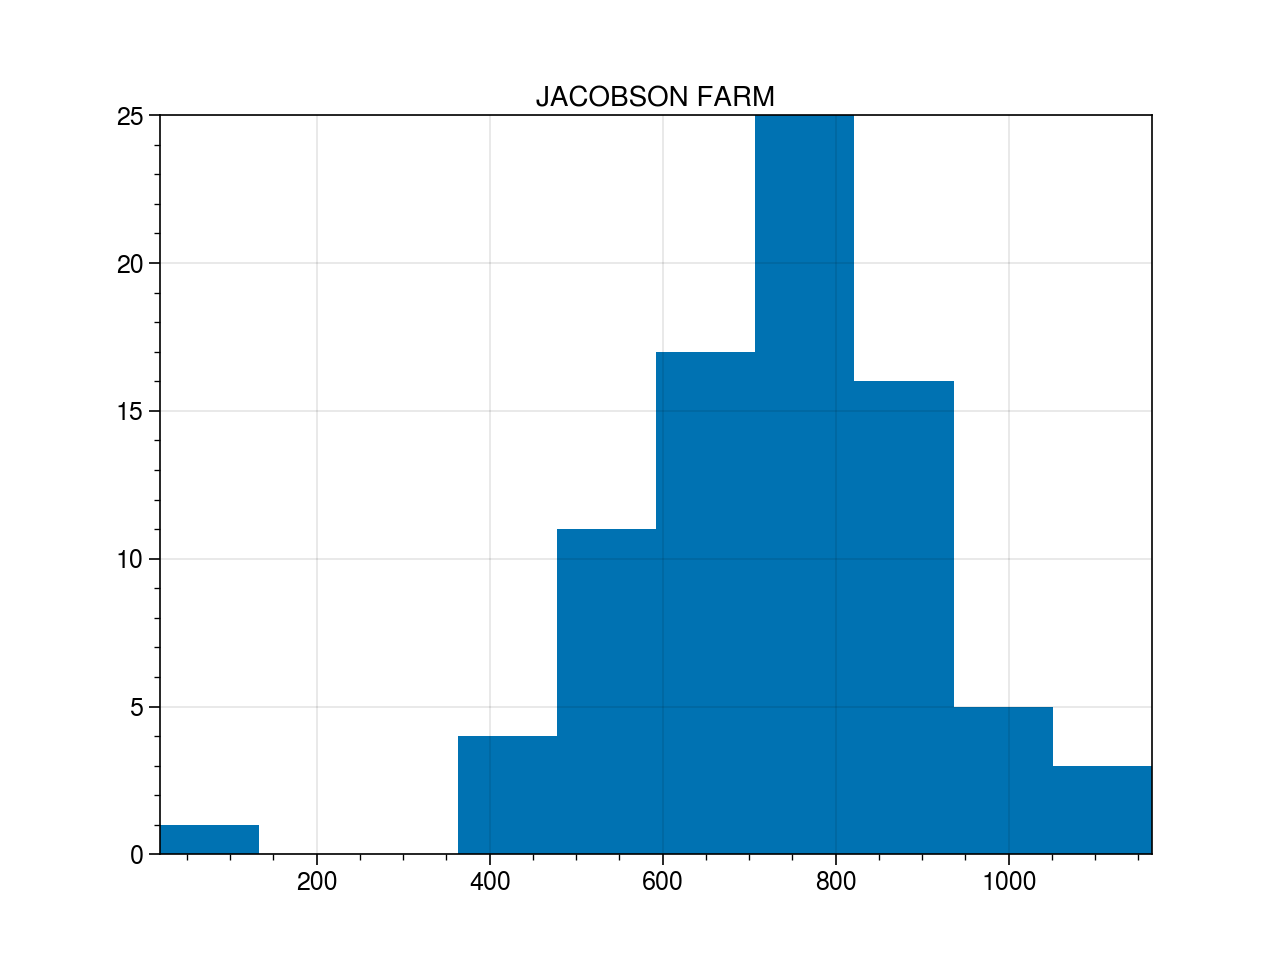

In [7]:
df[['OL JOGI FARM','Year']].dropna()
# oops! maybe shouldn't be using ol jogi

df[['JACOBSON FARM','Year']].dropna().groupby(['Year']).sum().hist()
# Need to remove that outlier which is 2015, TODO

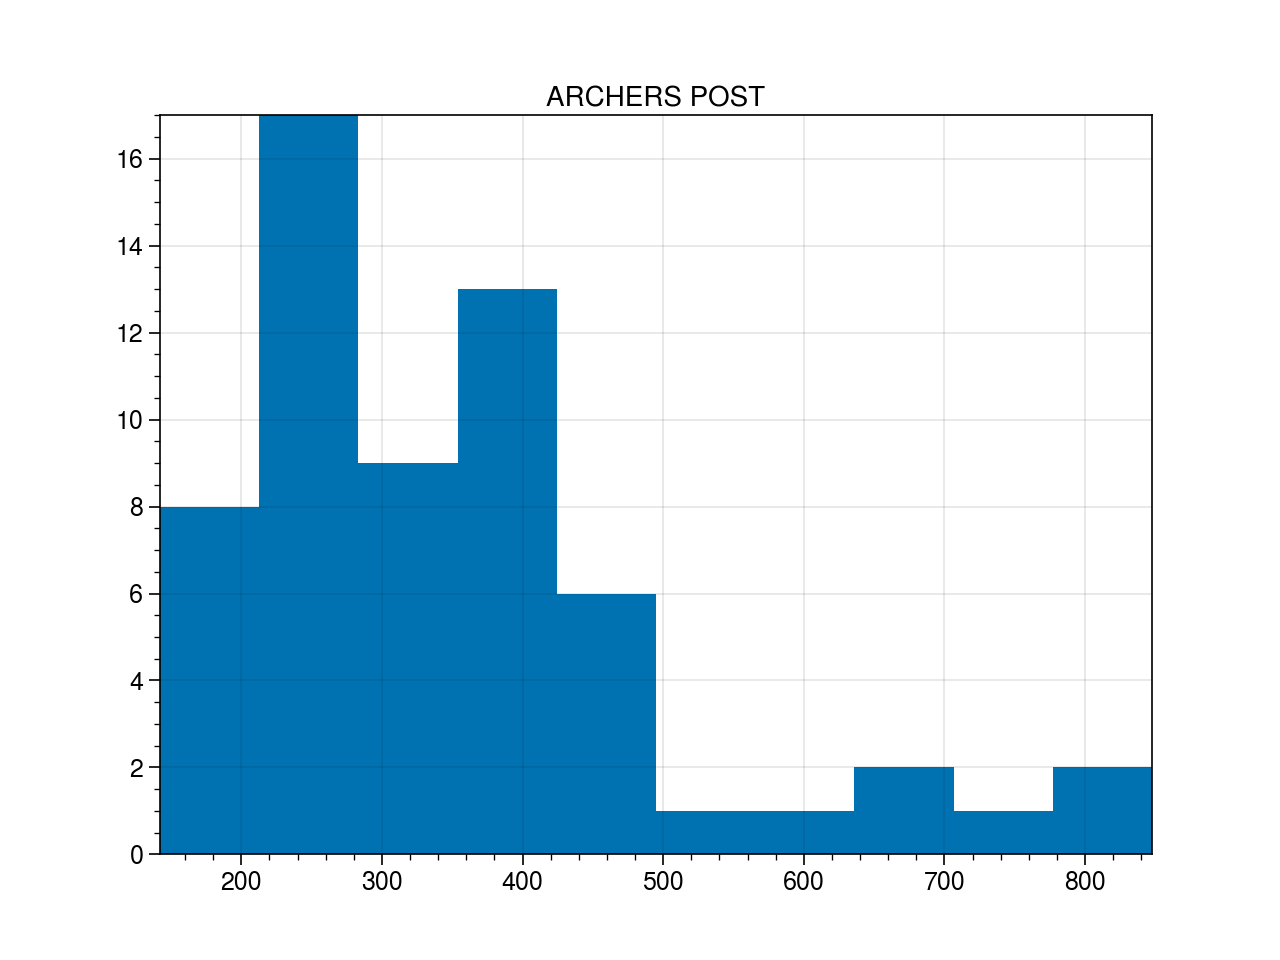

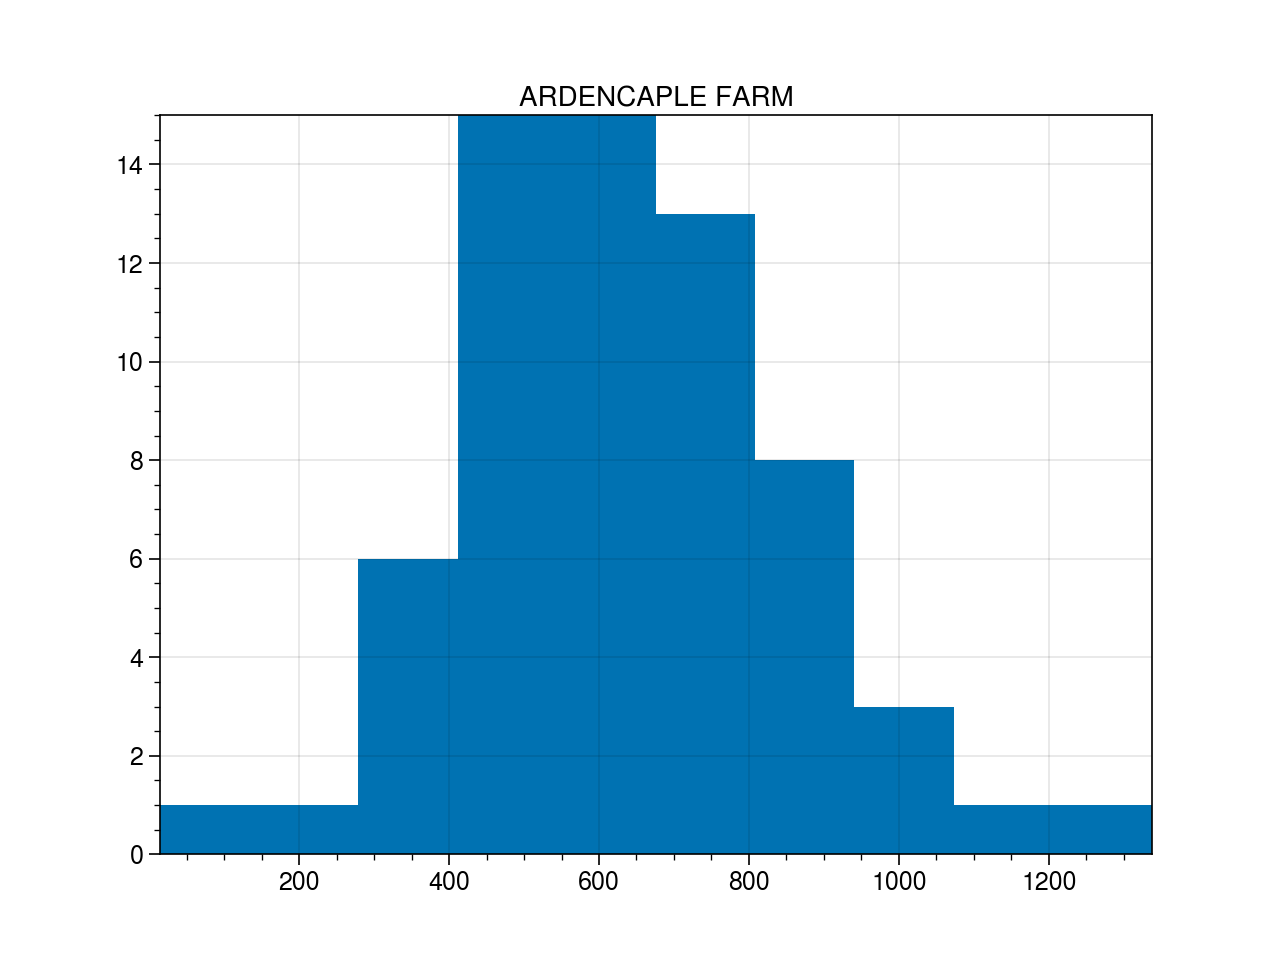

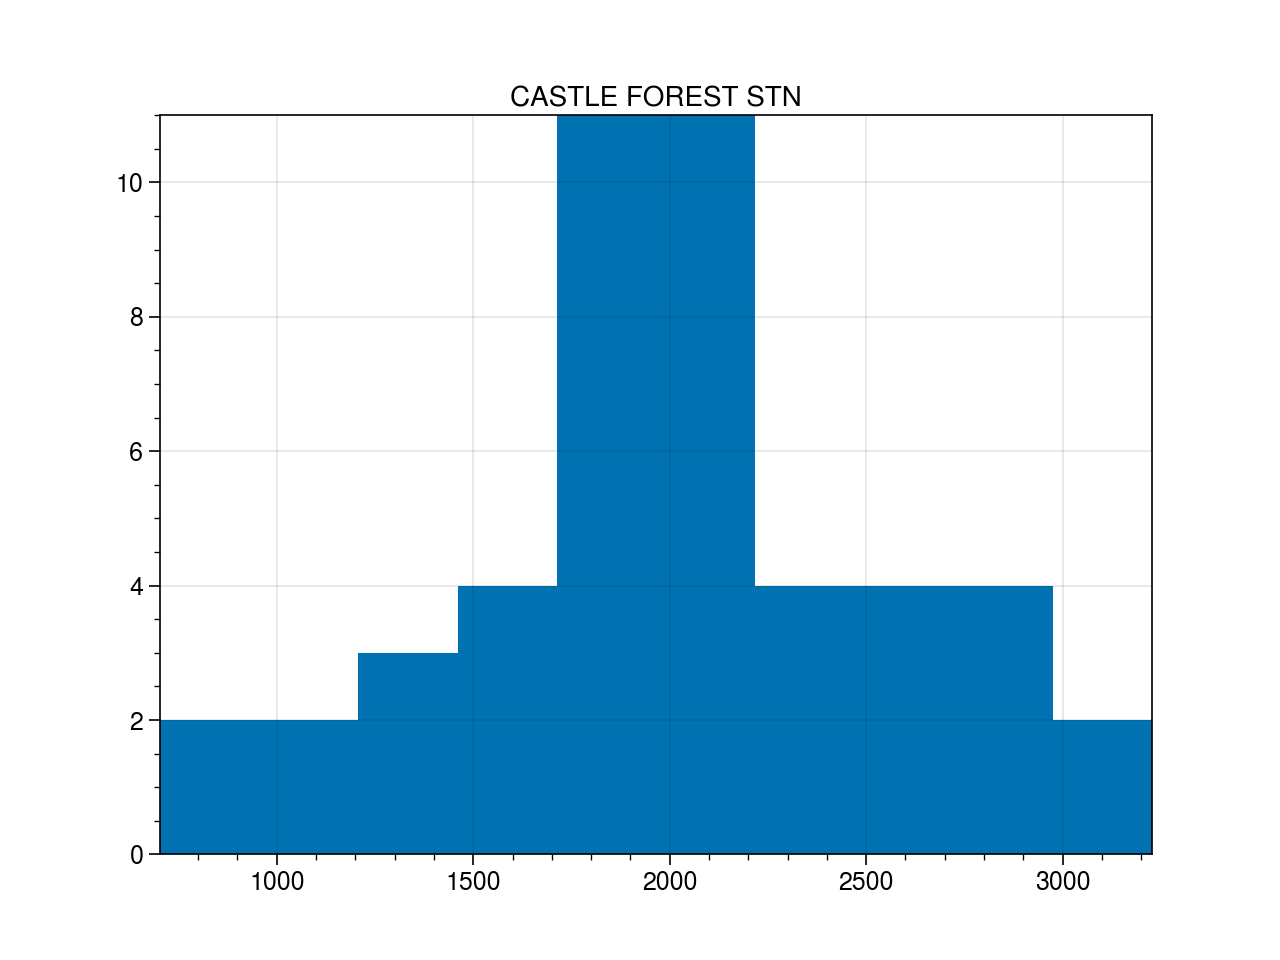

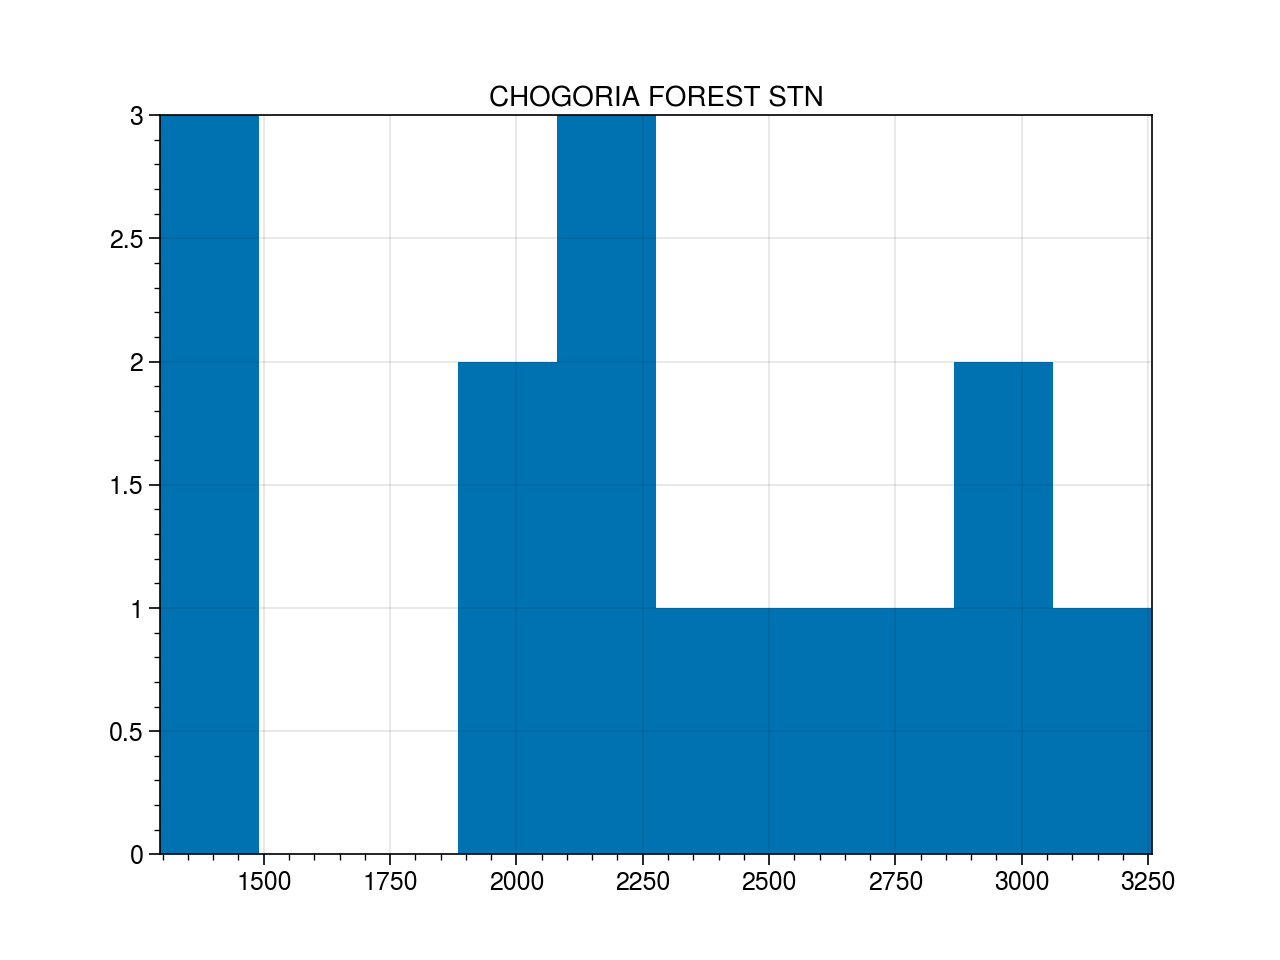

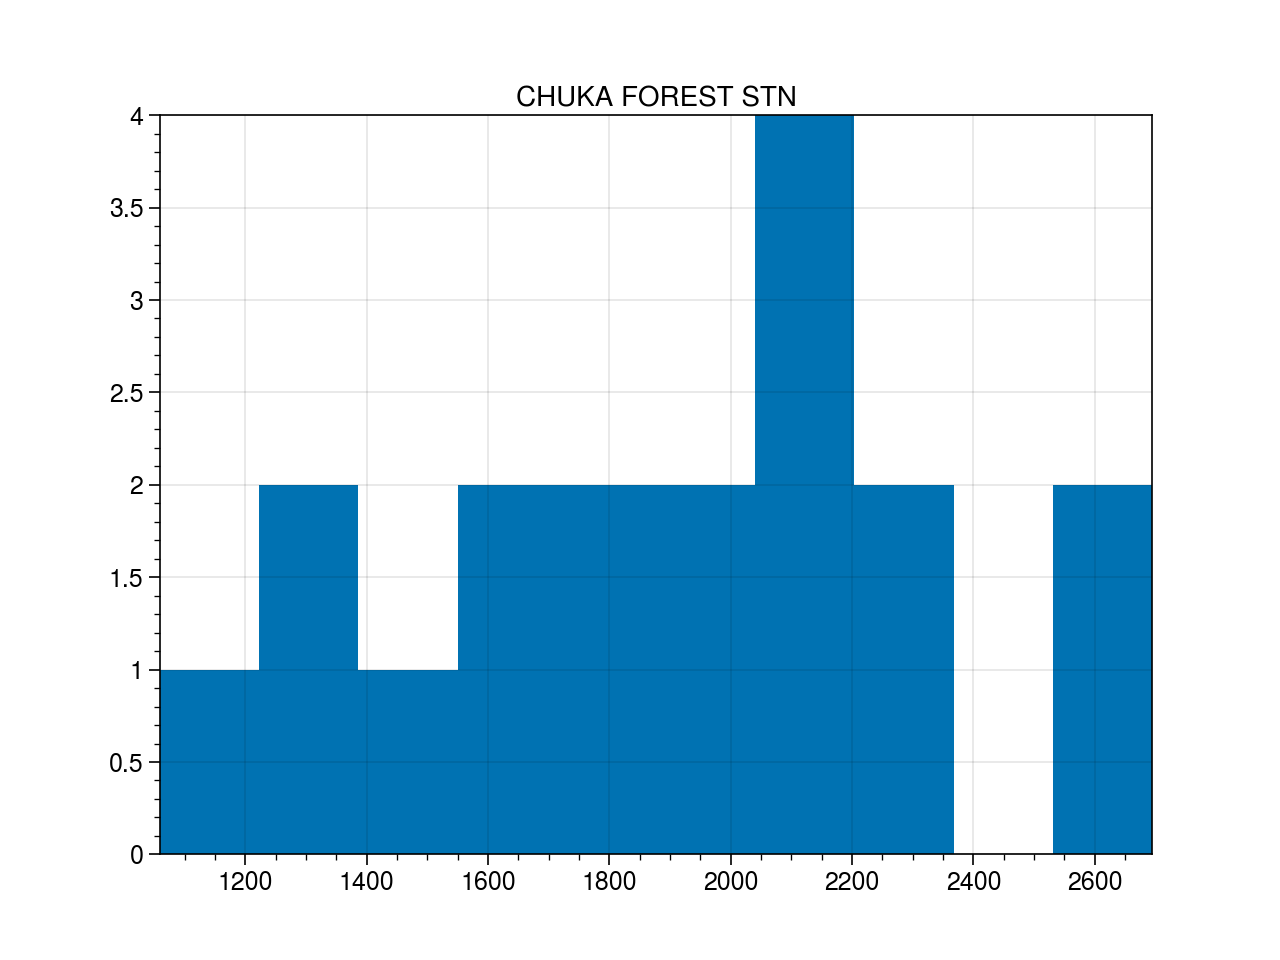

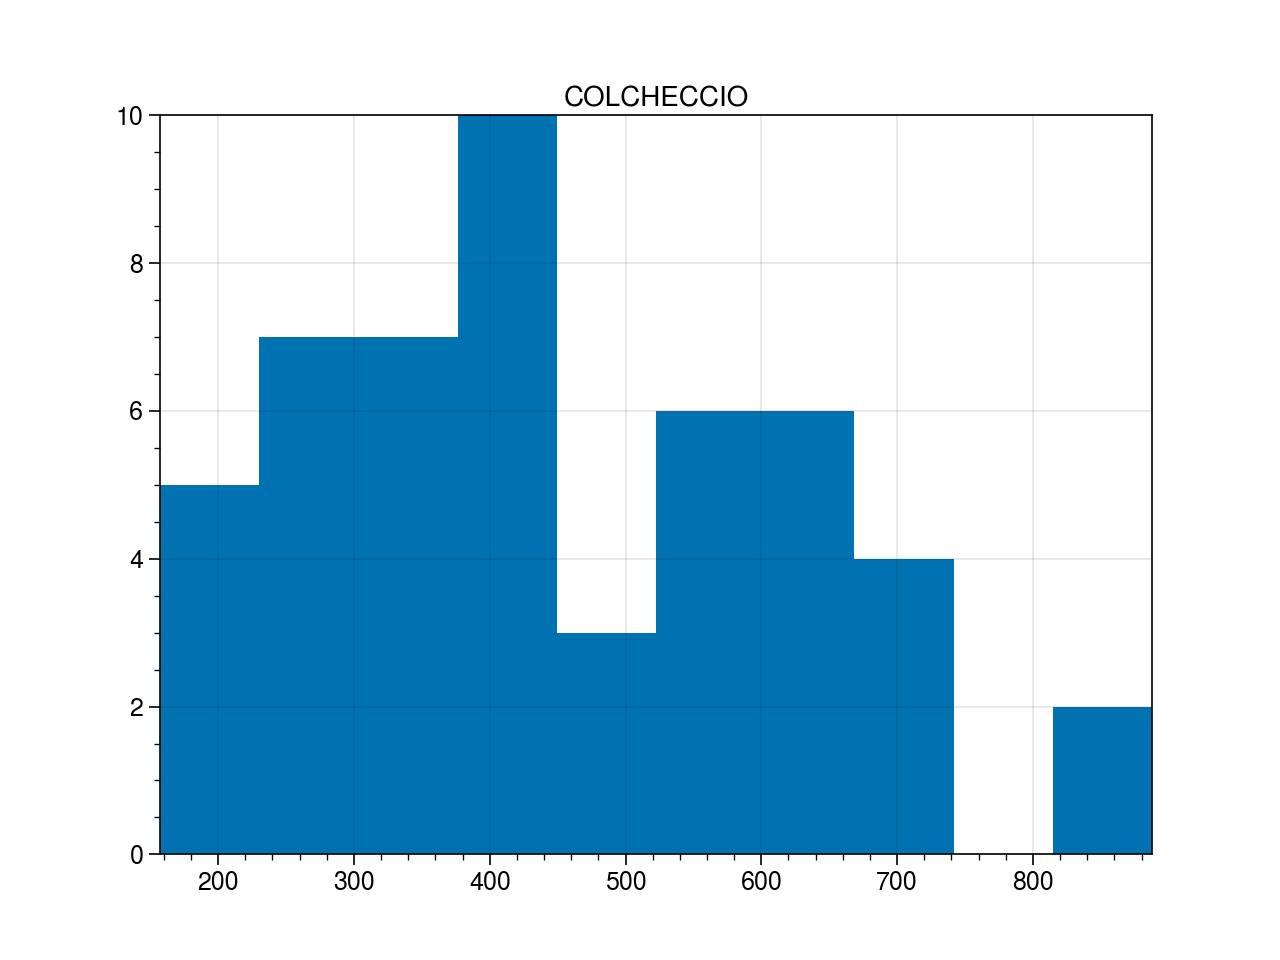

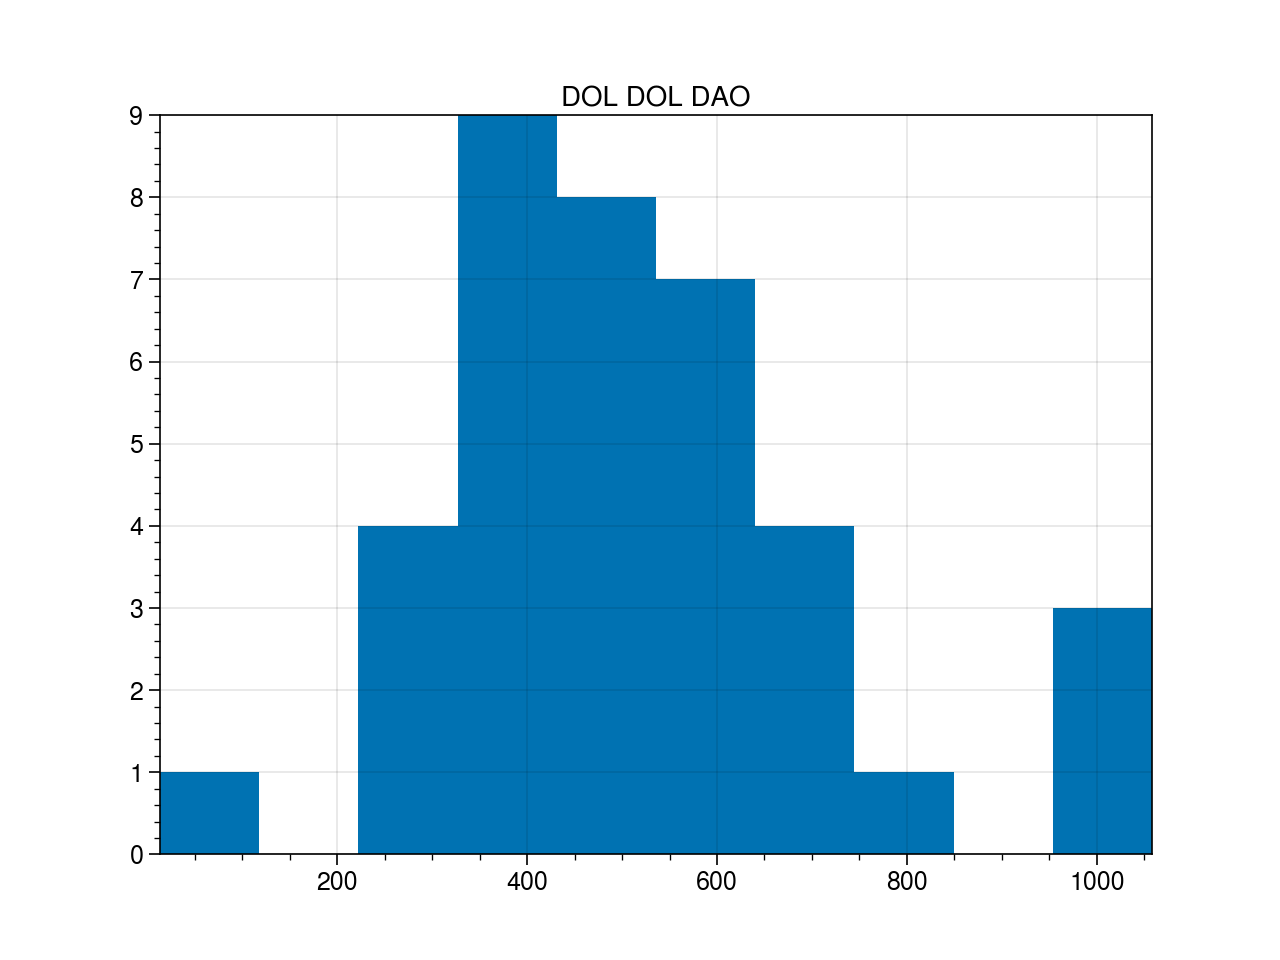

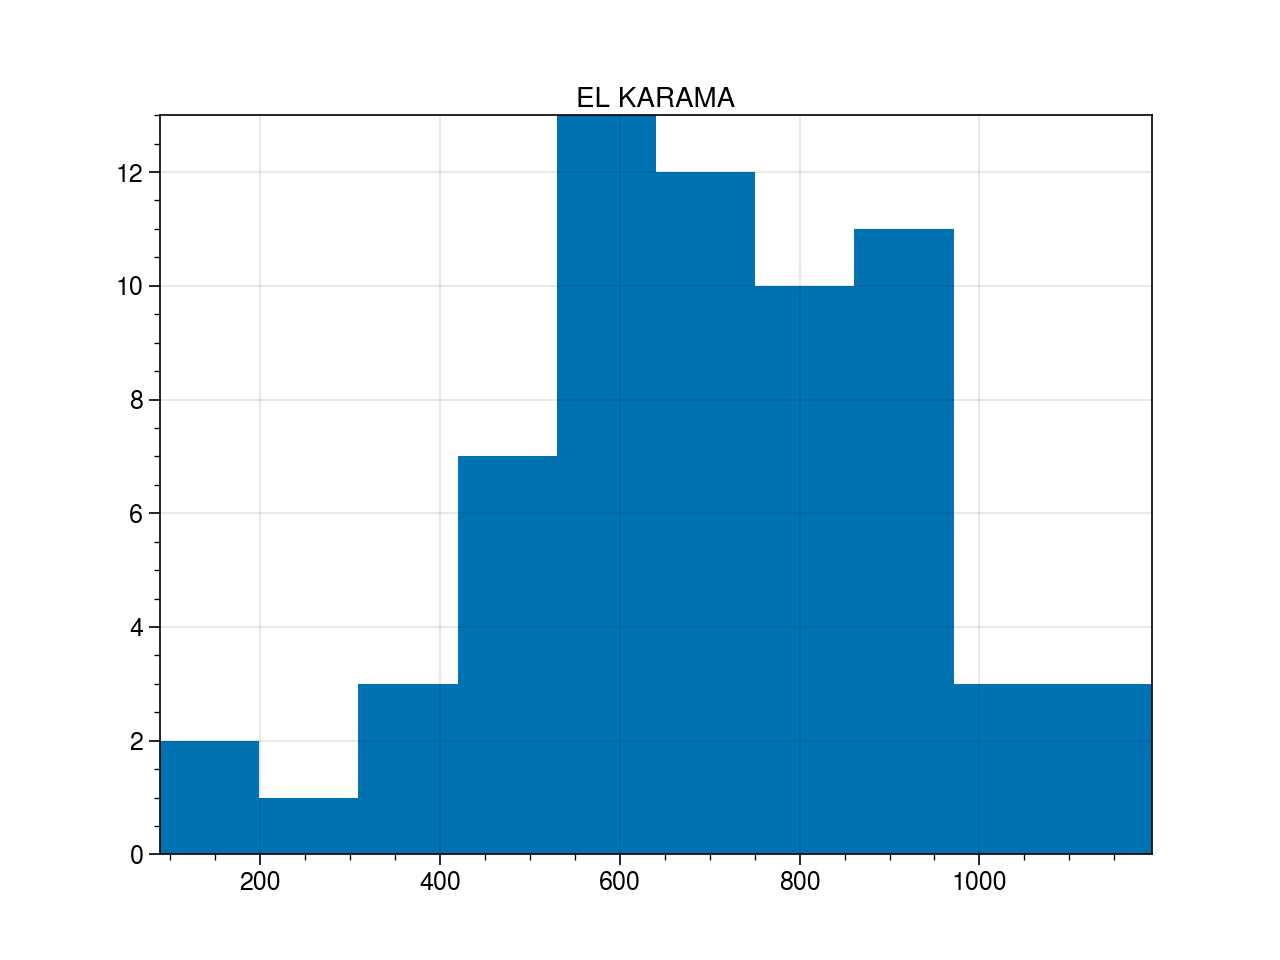

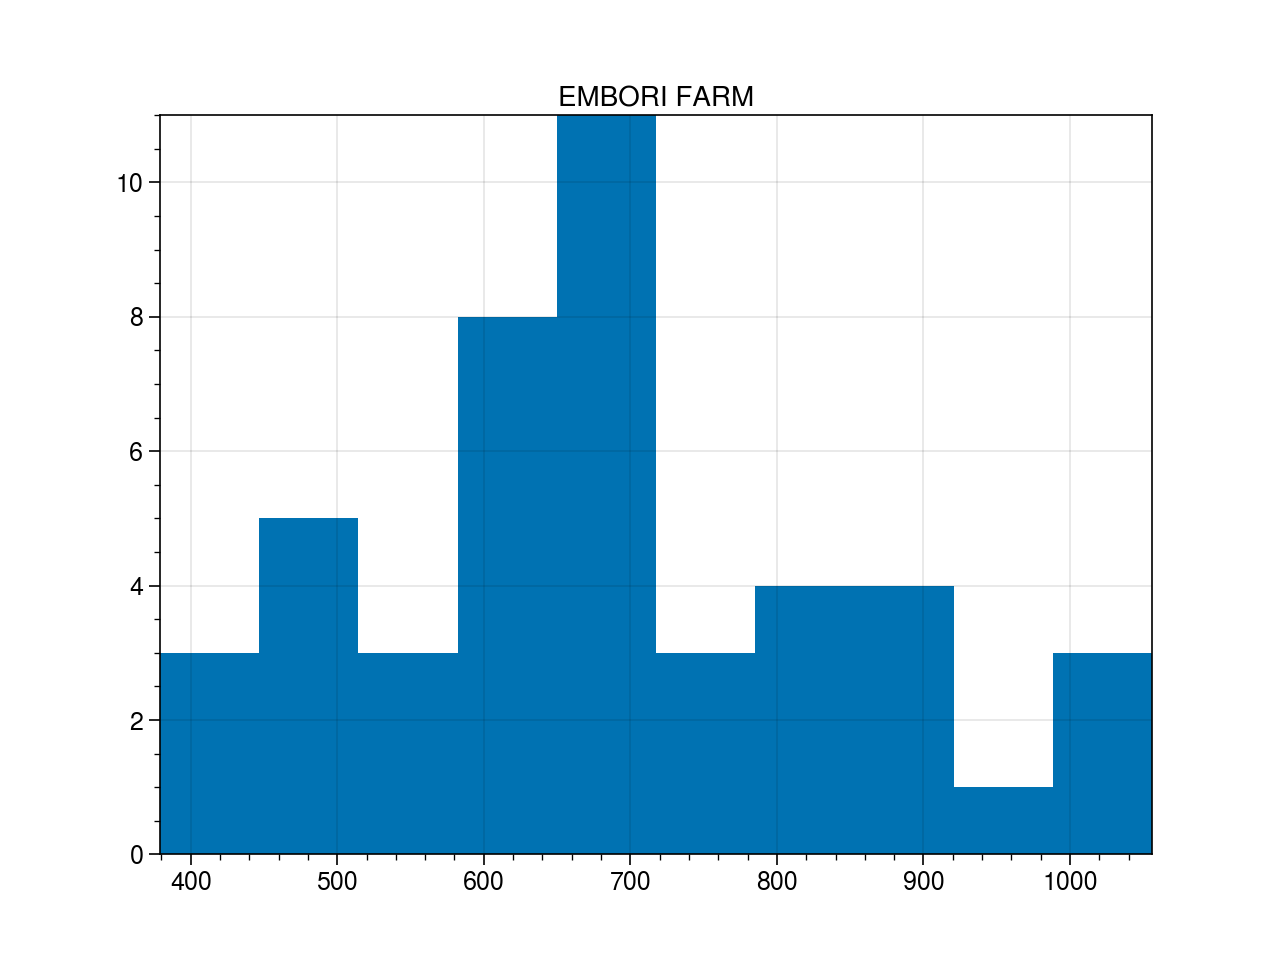

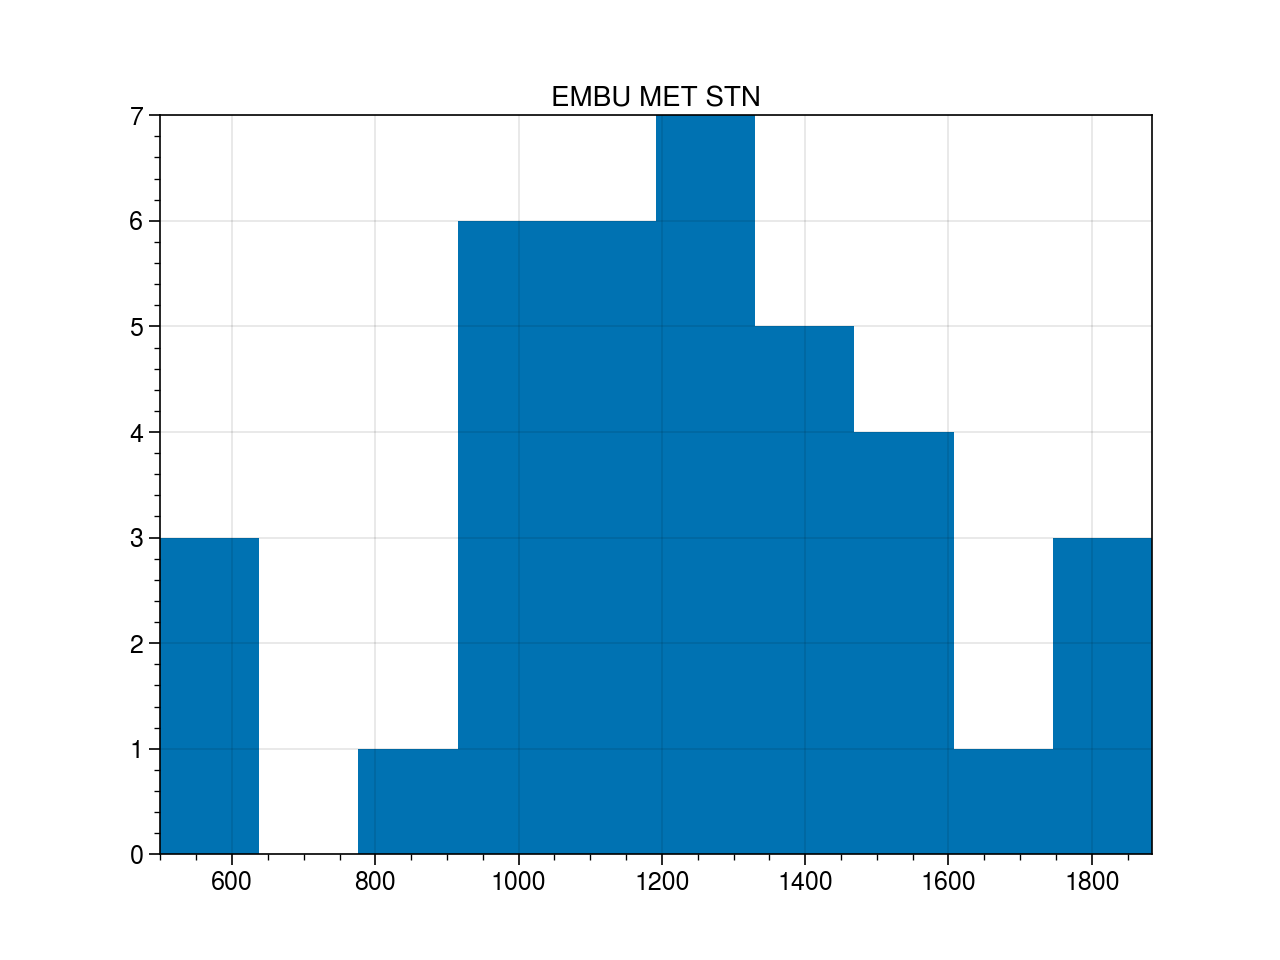

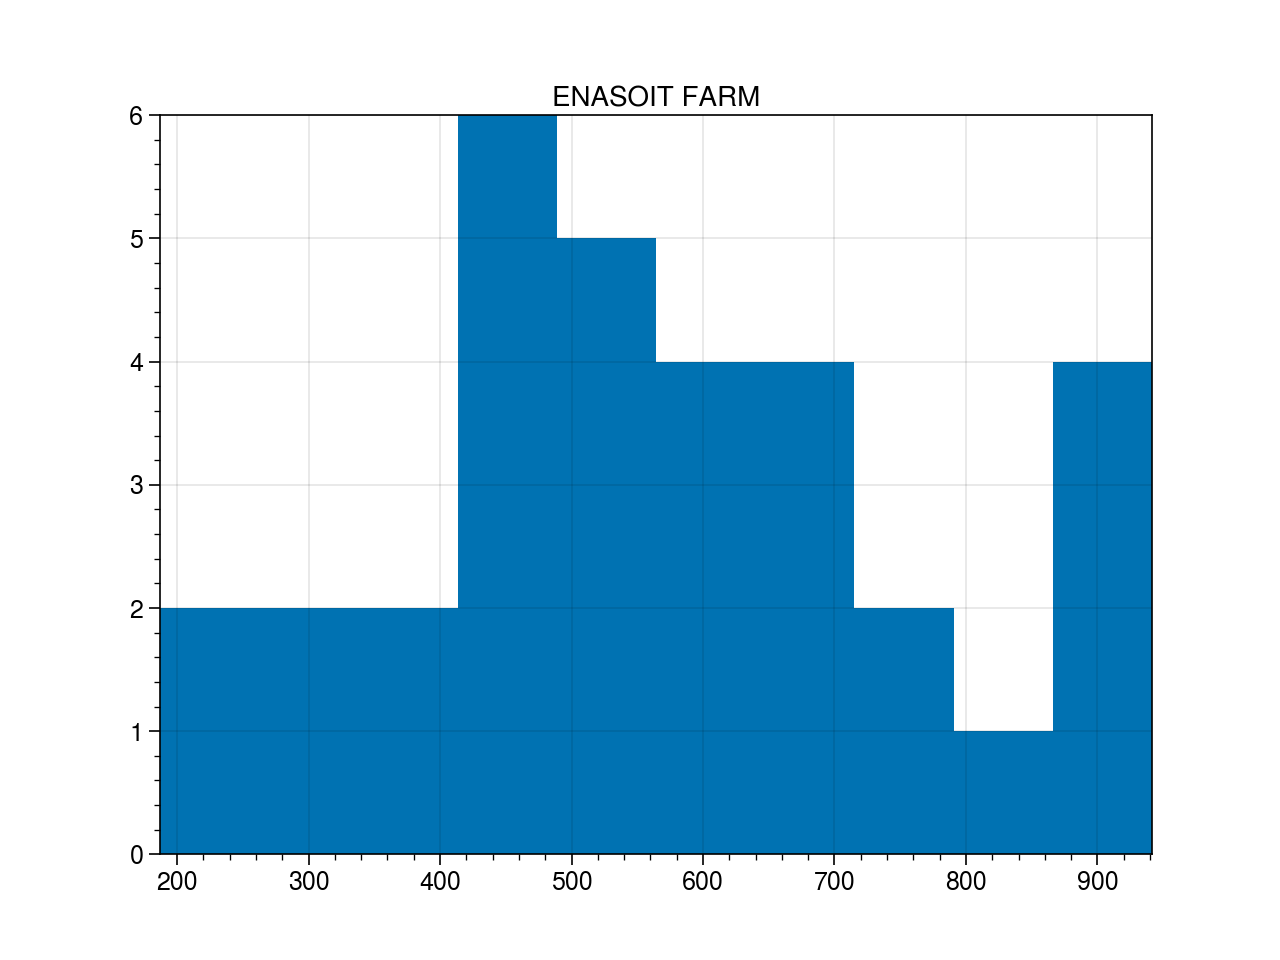

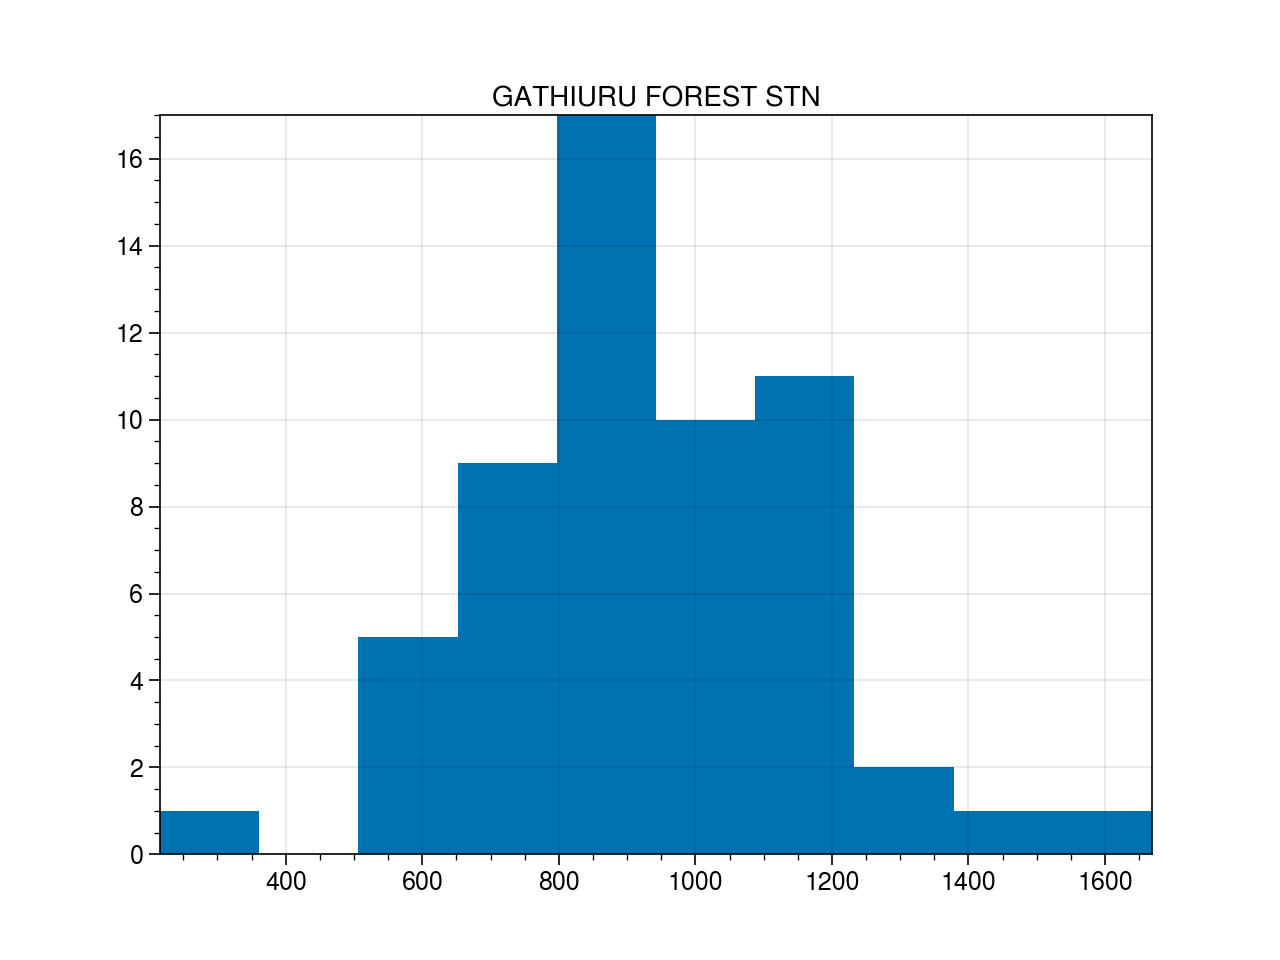

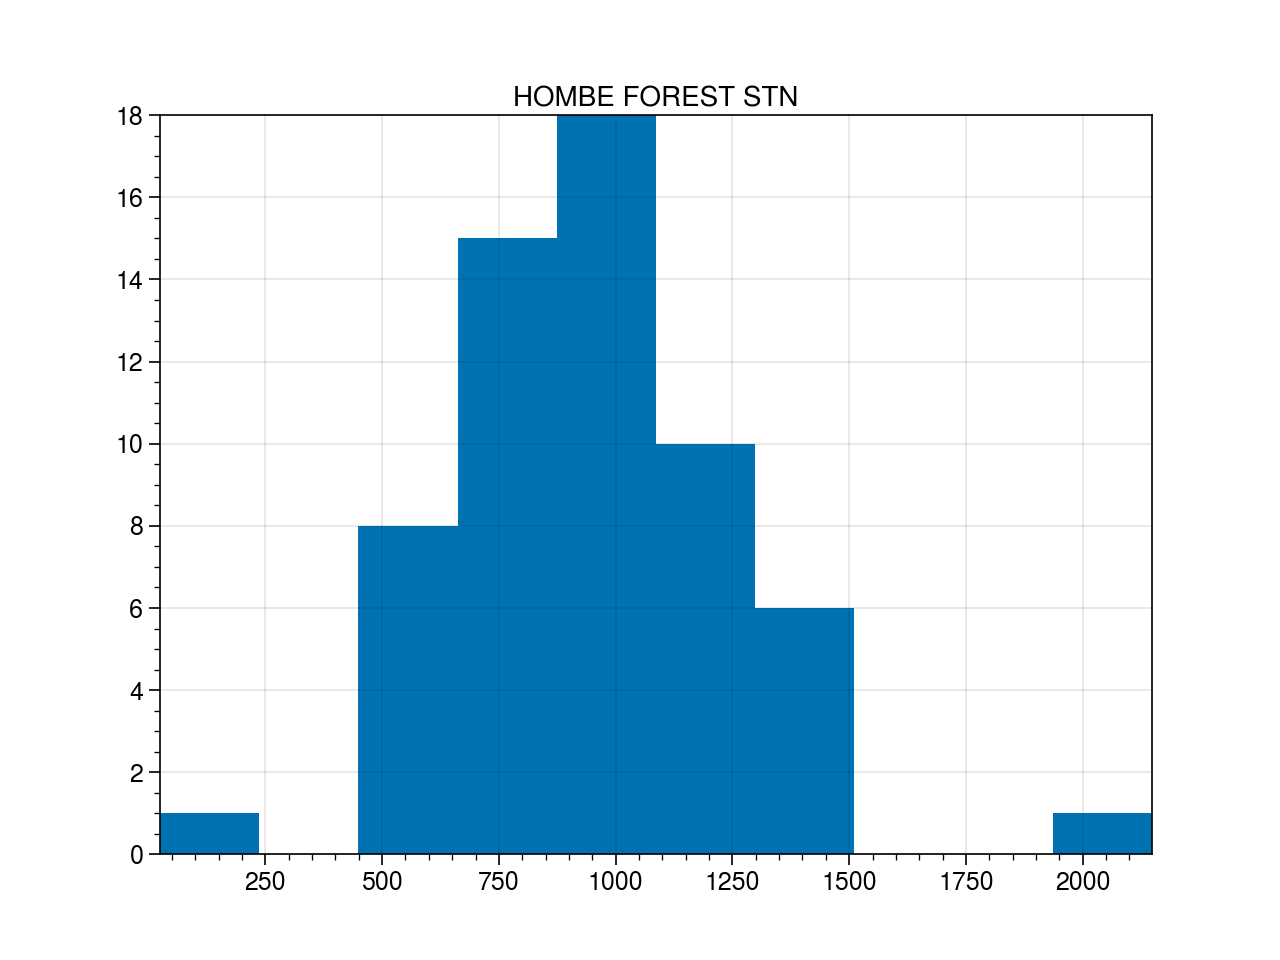

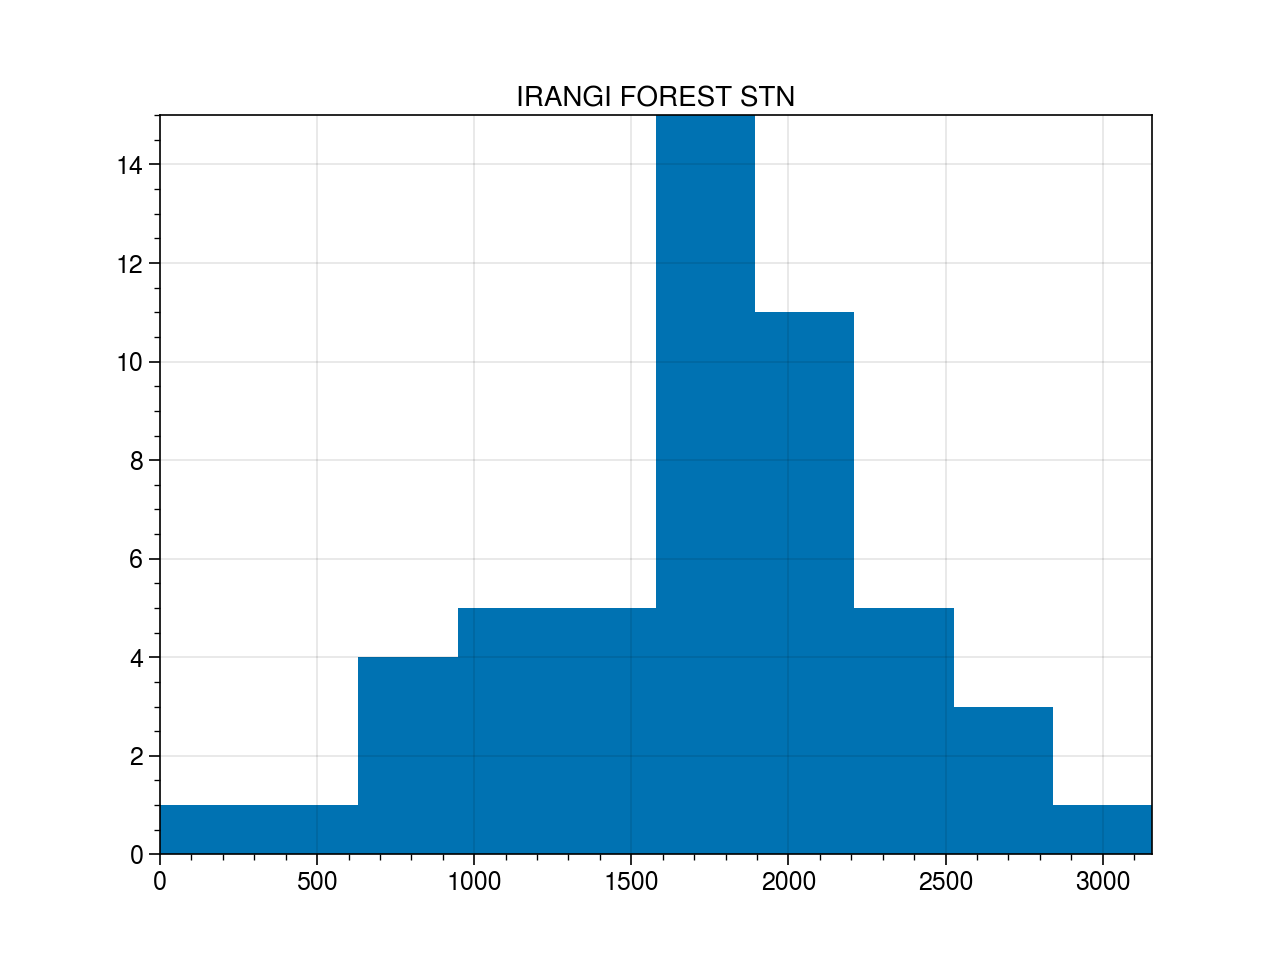

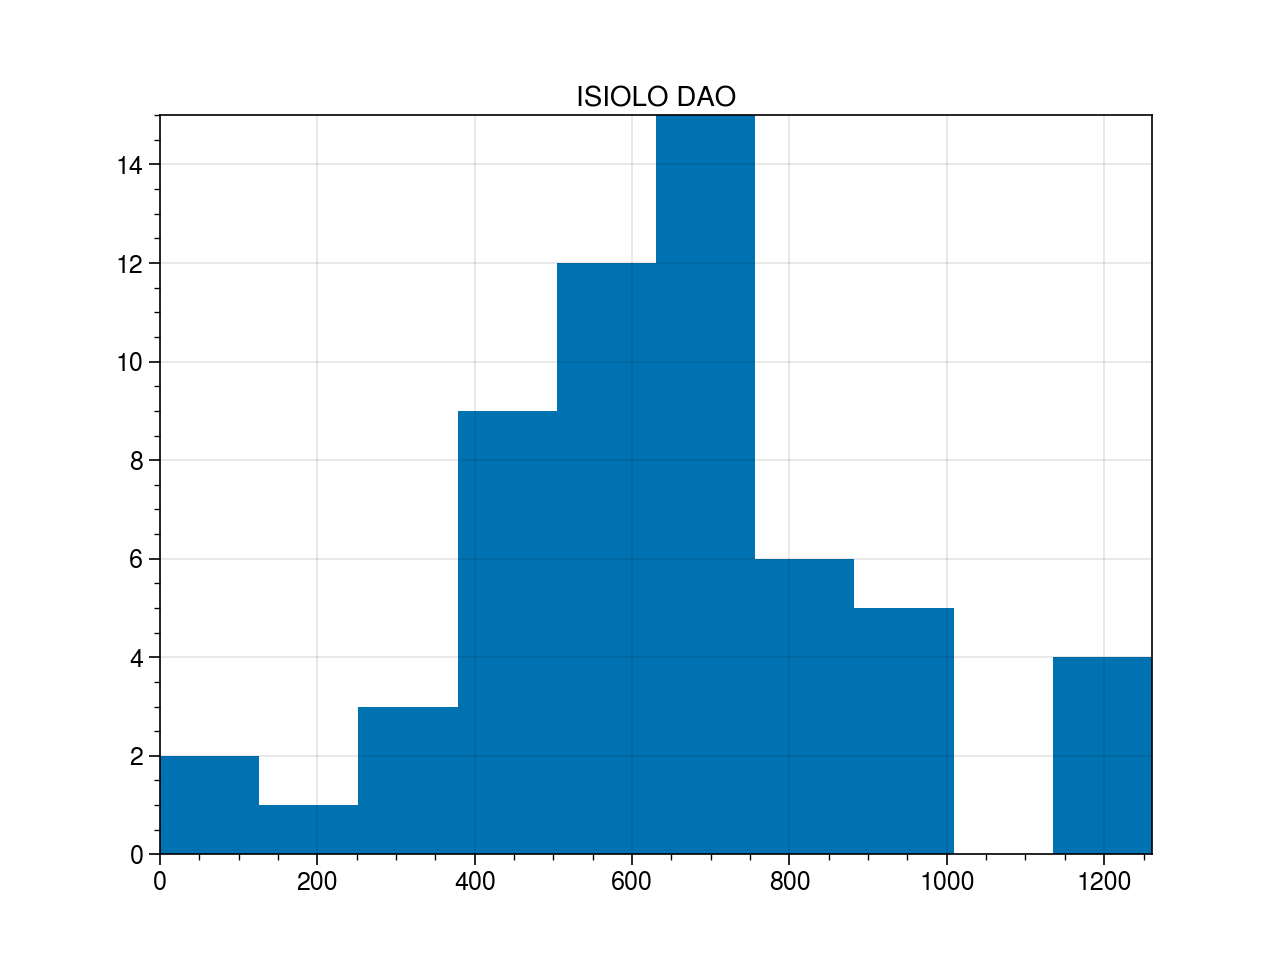

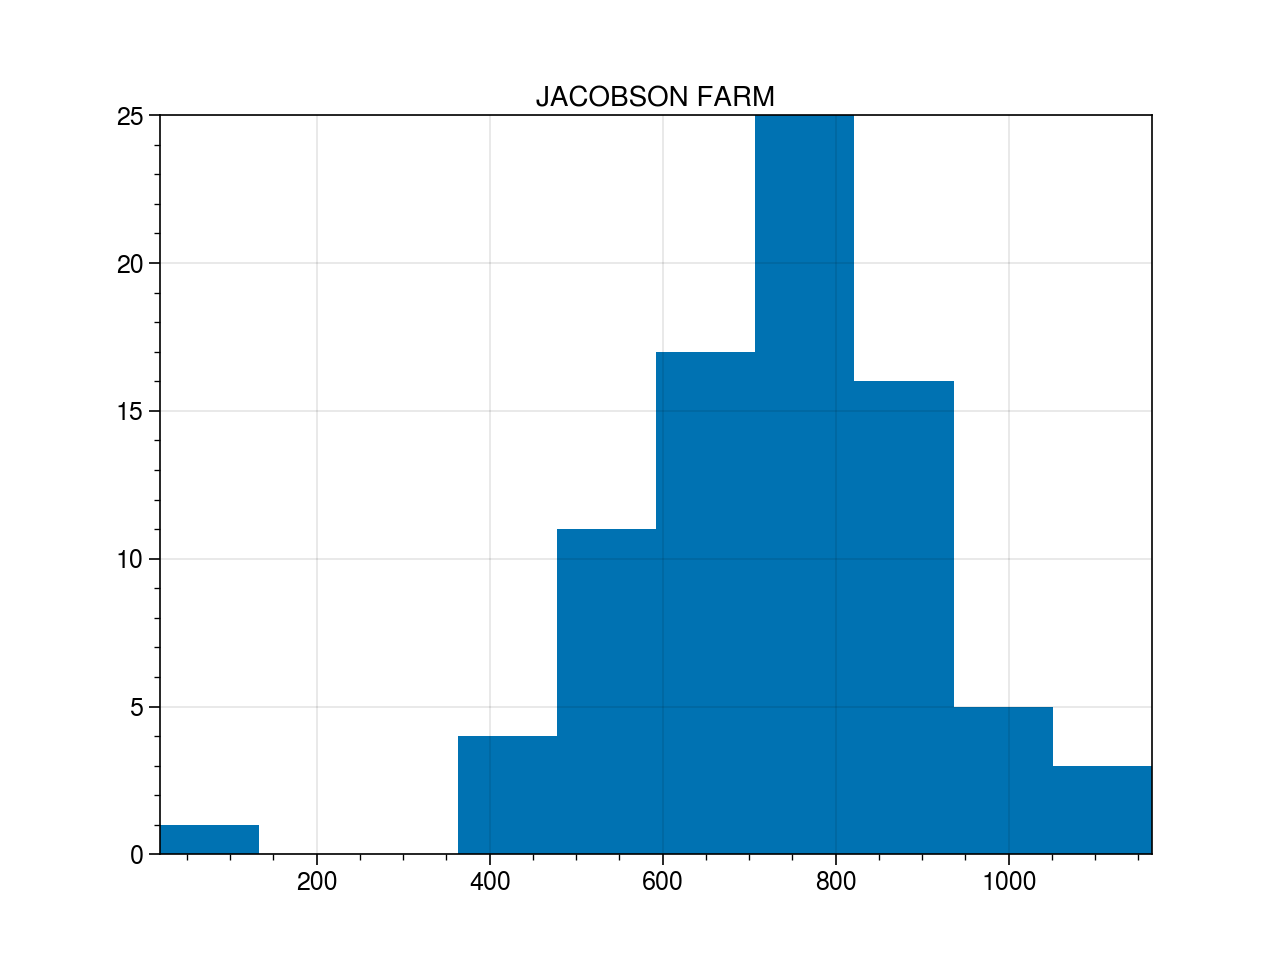

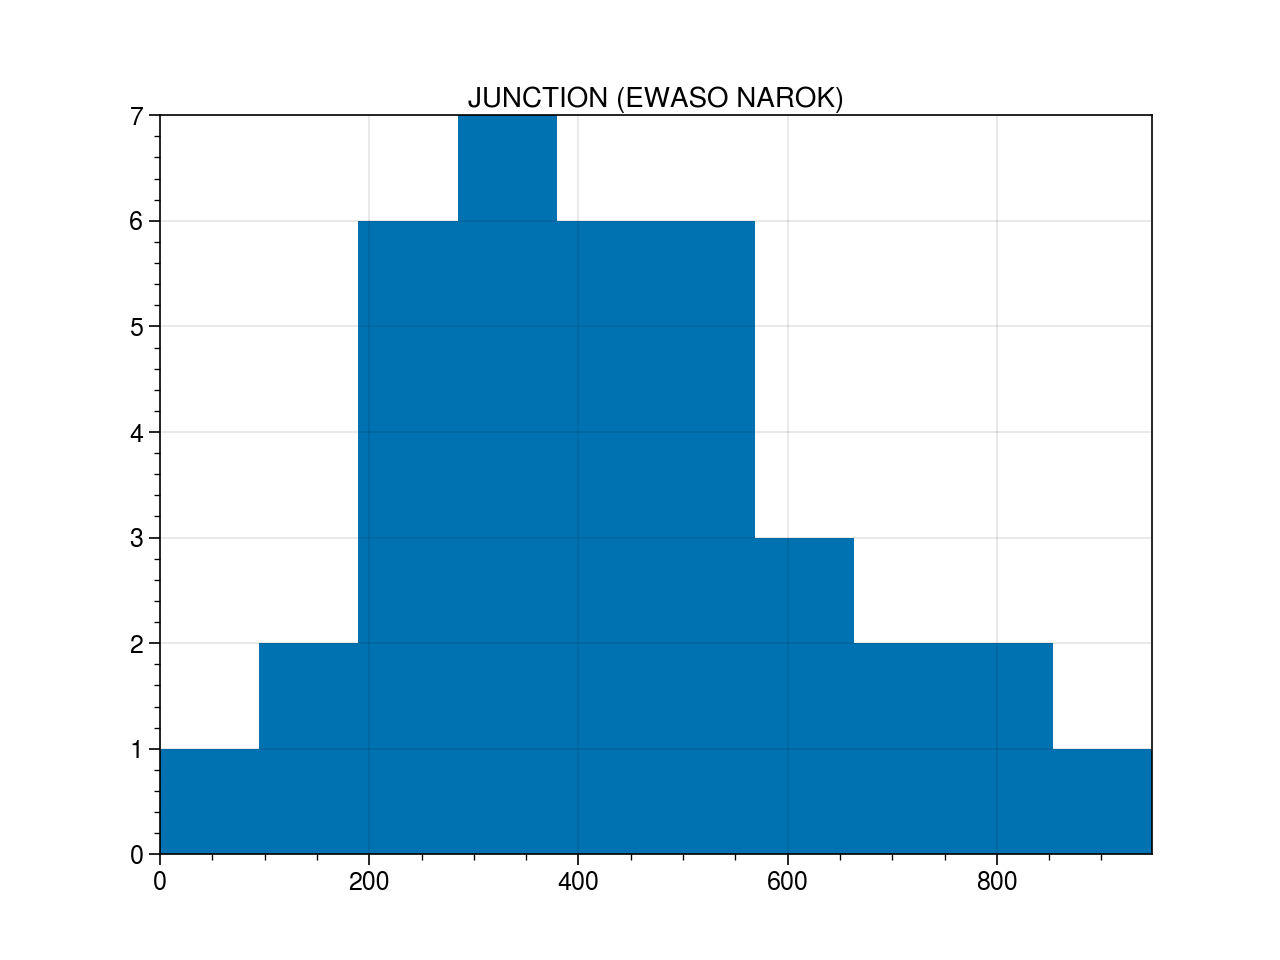

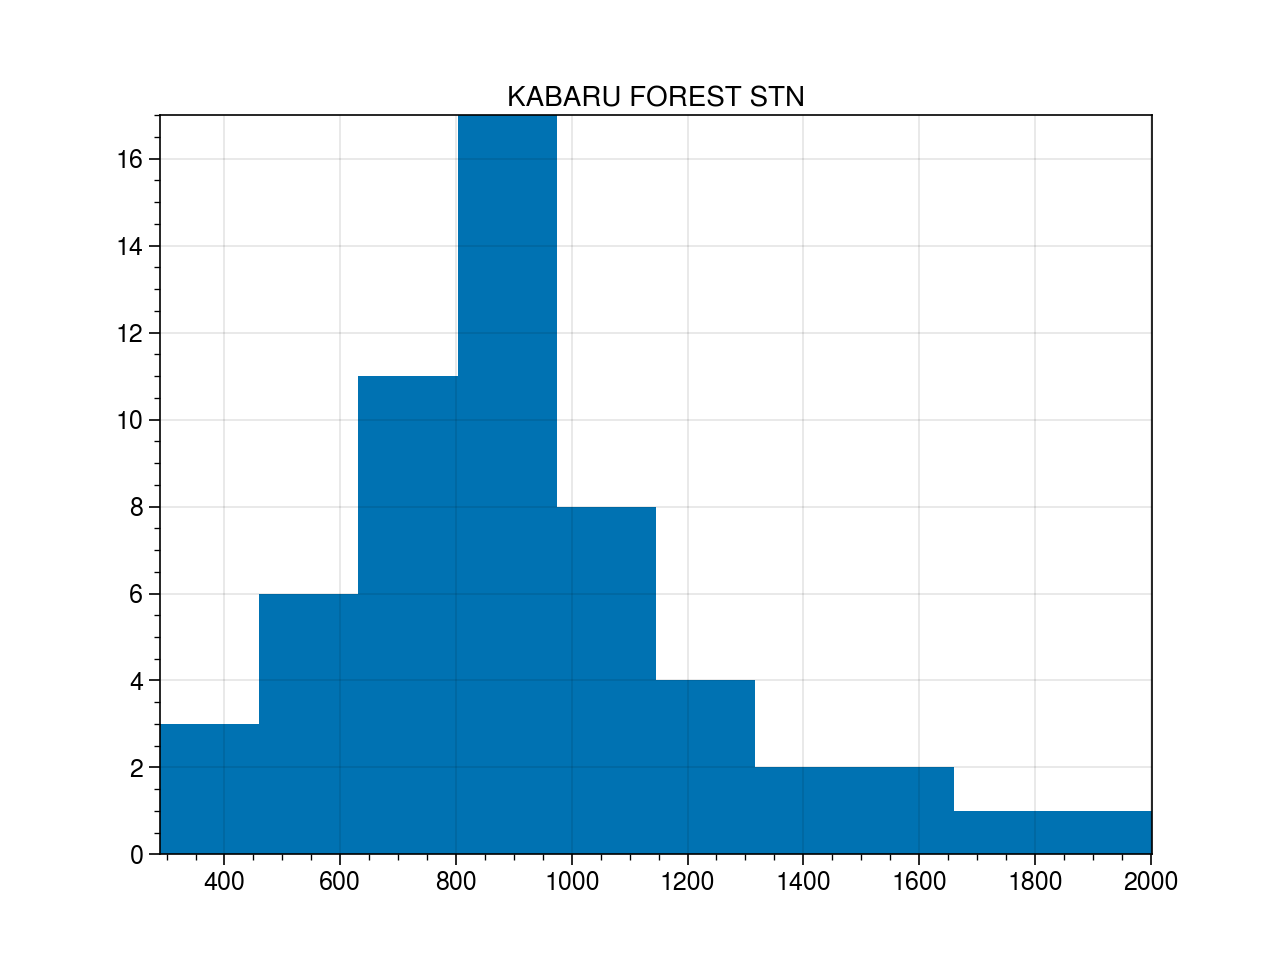

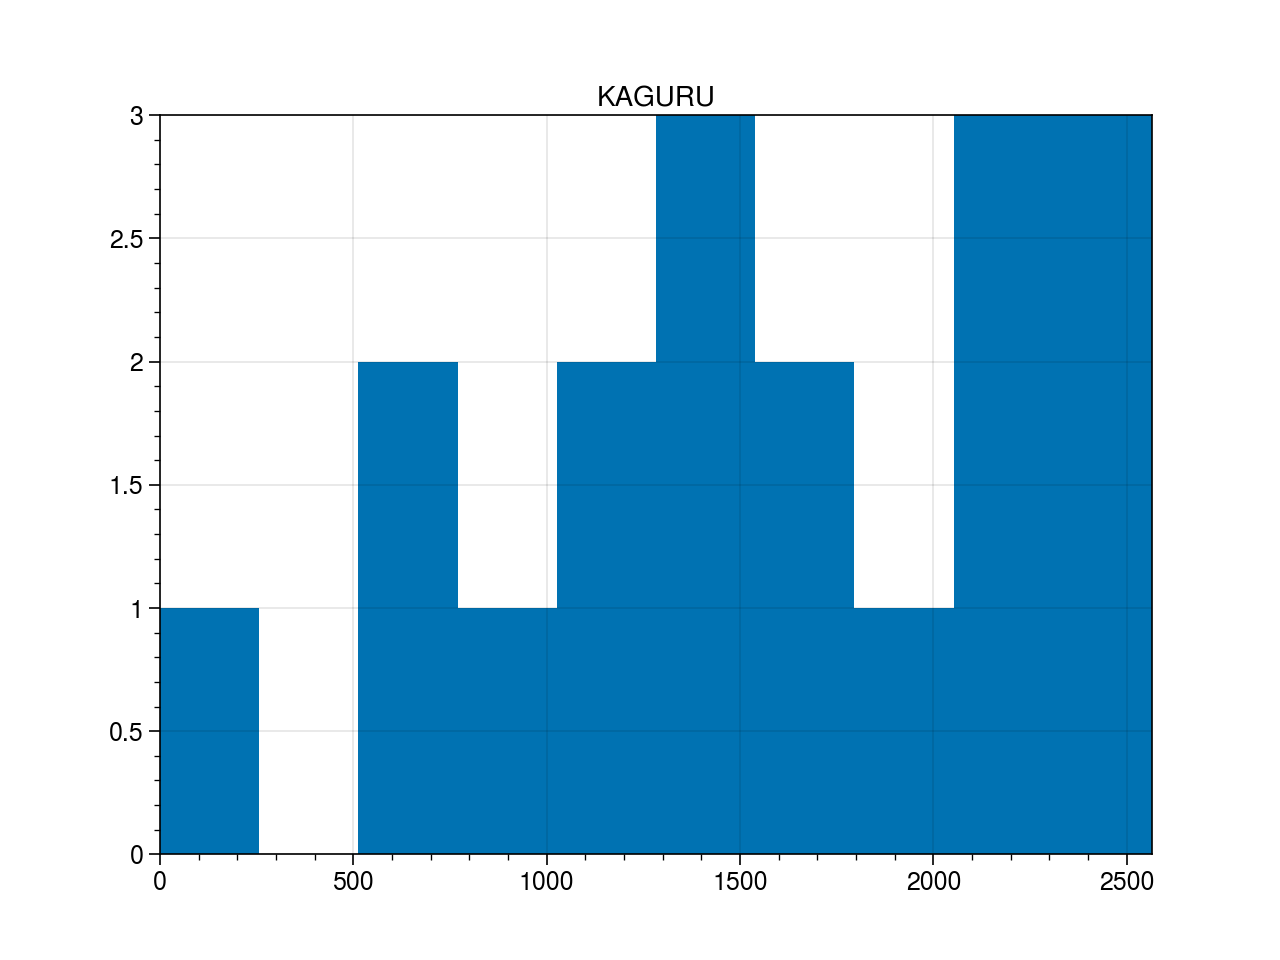

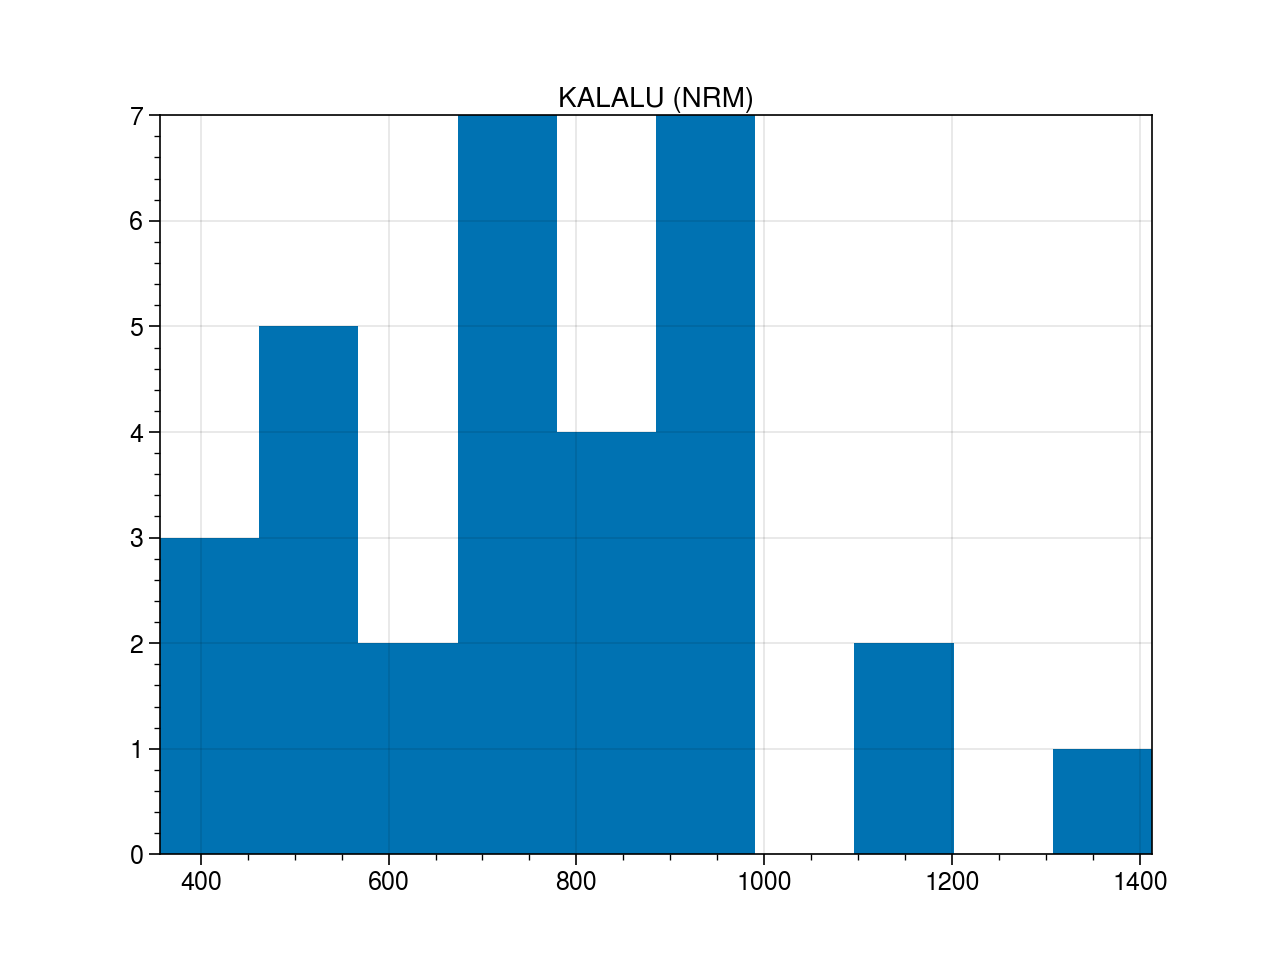

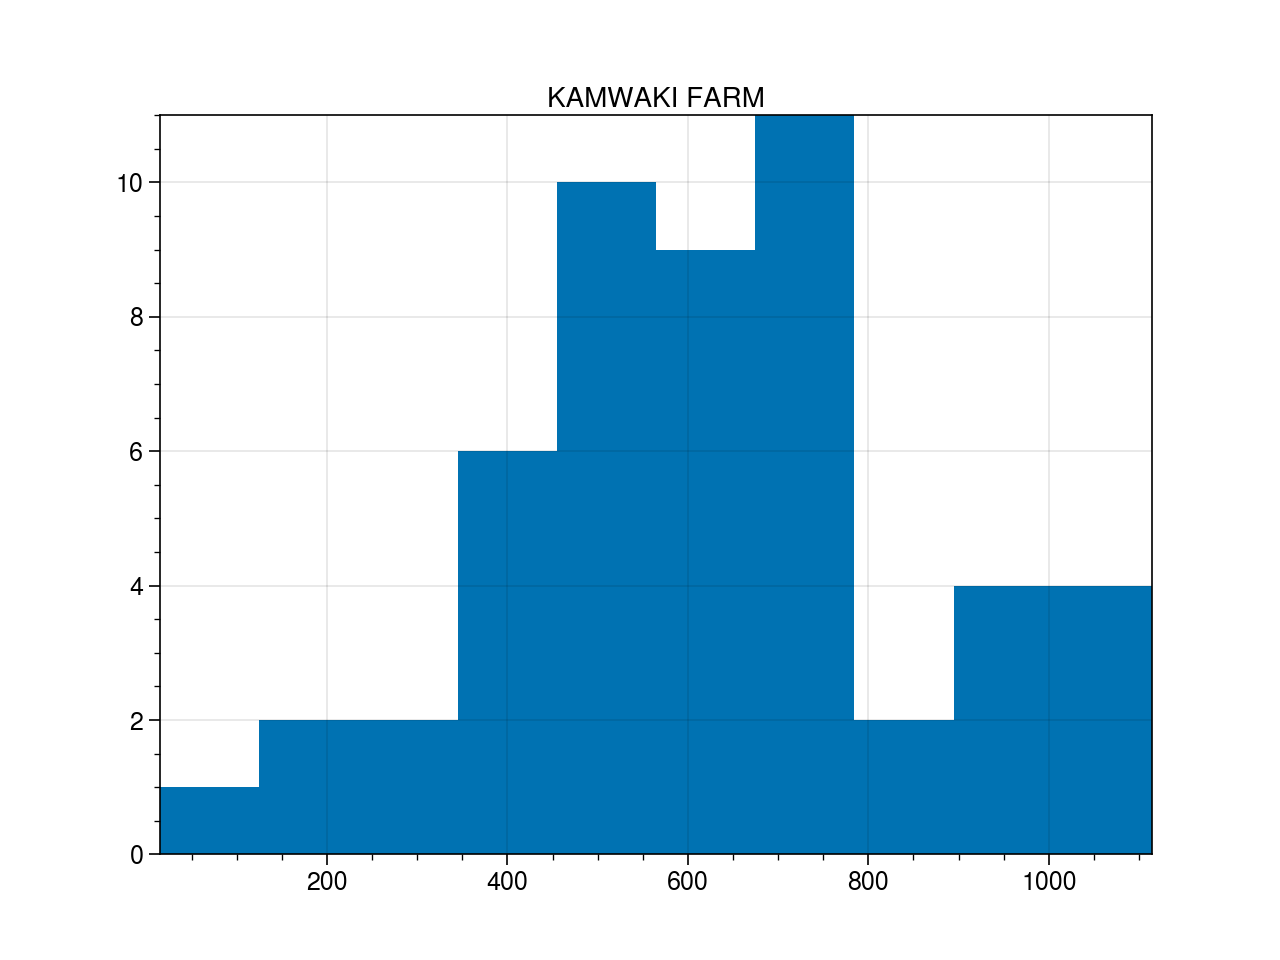

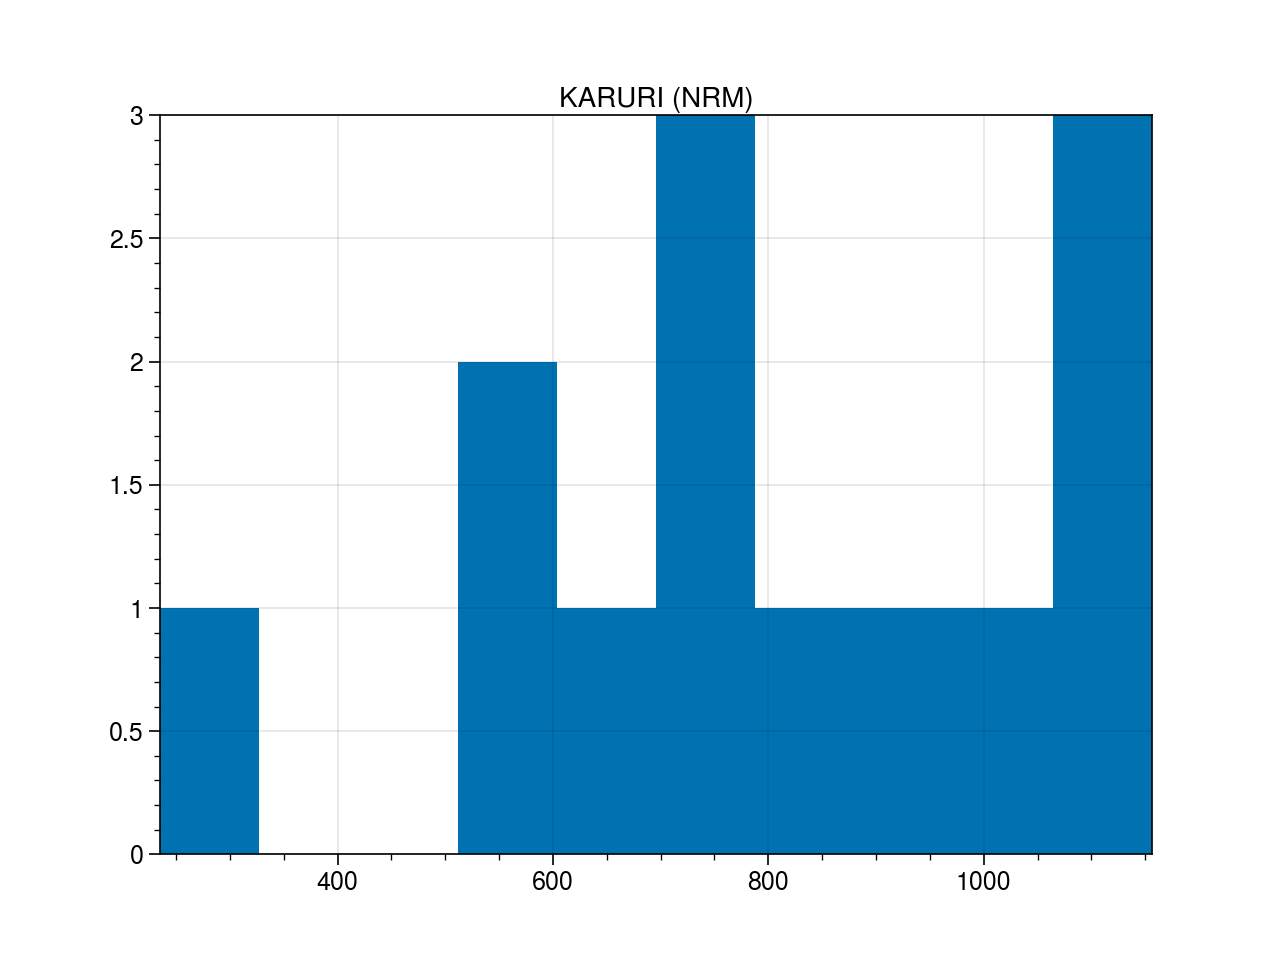

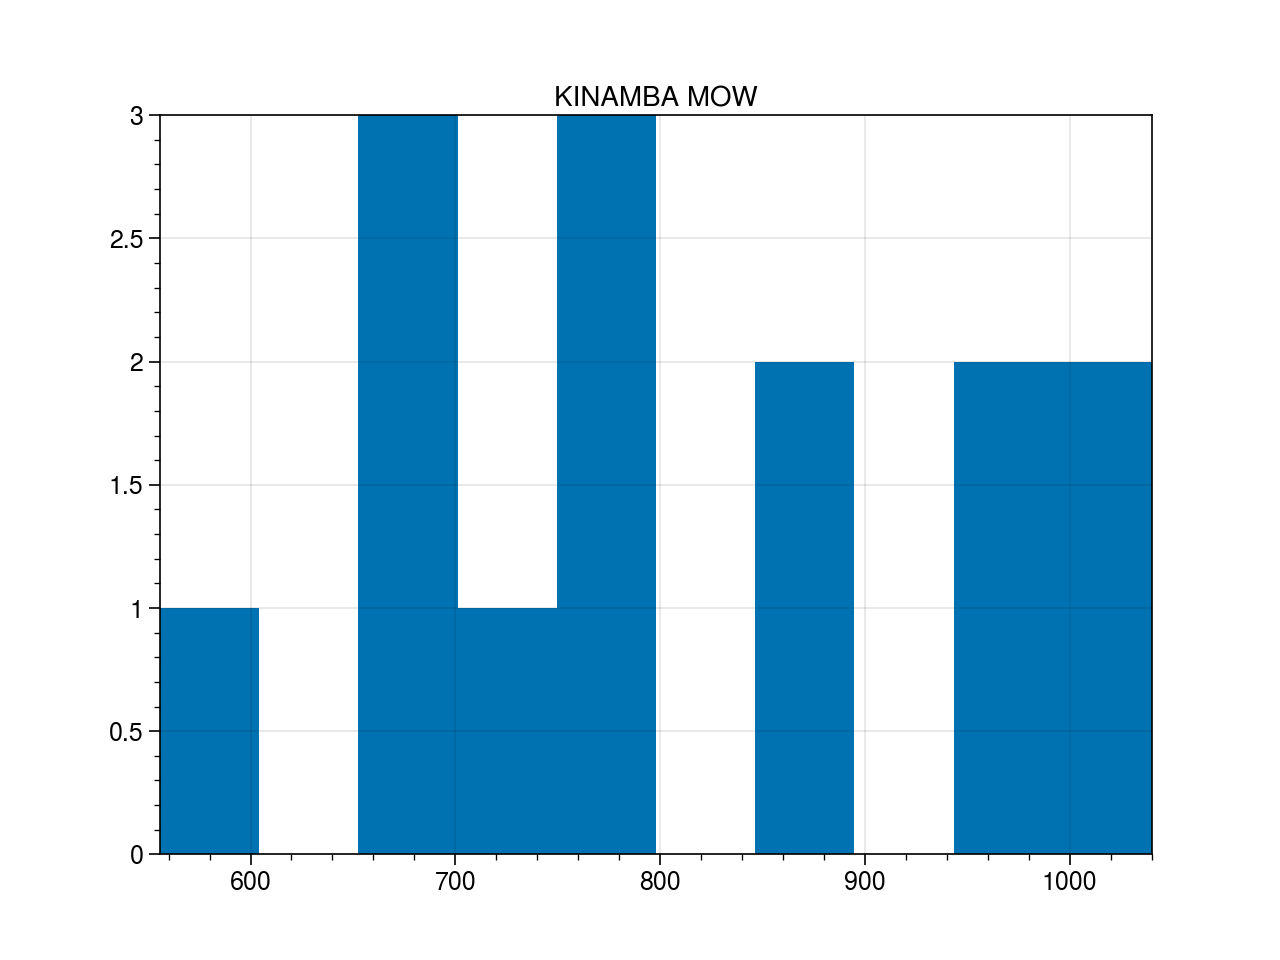

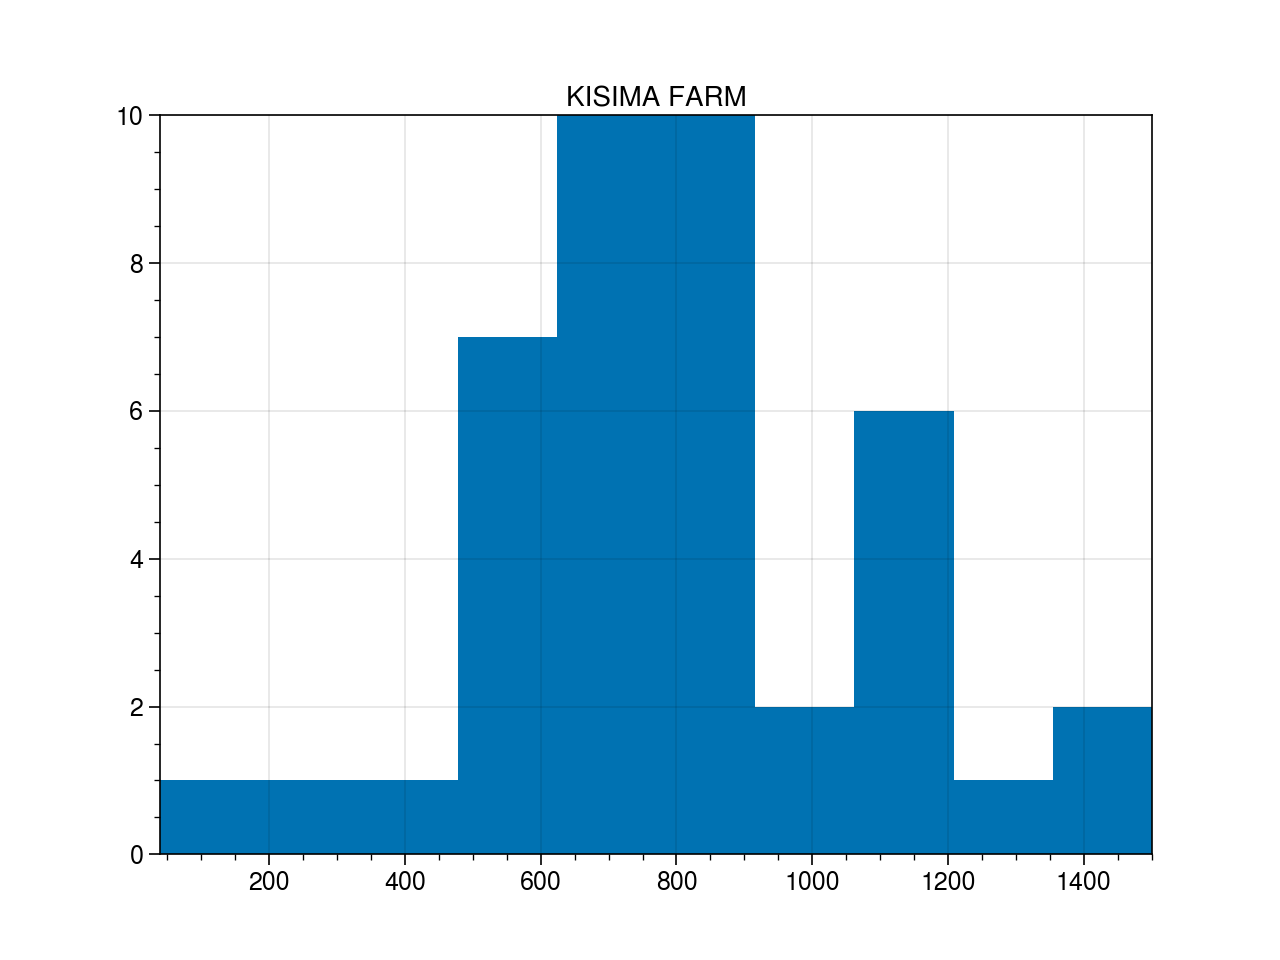

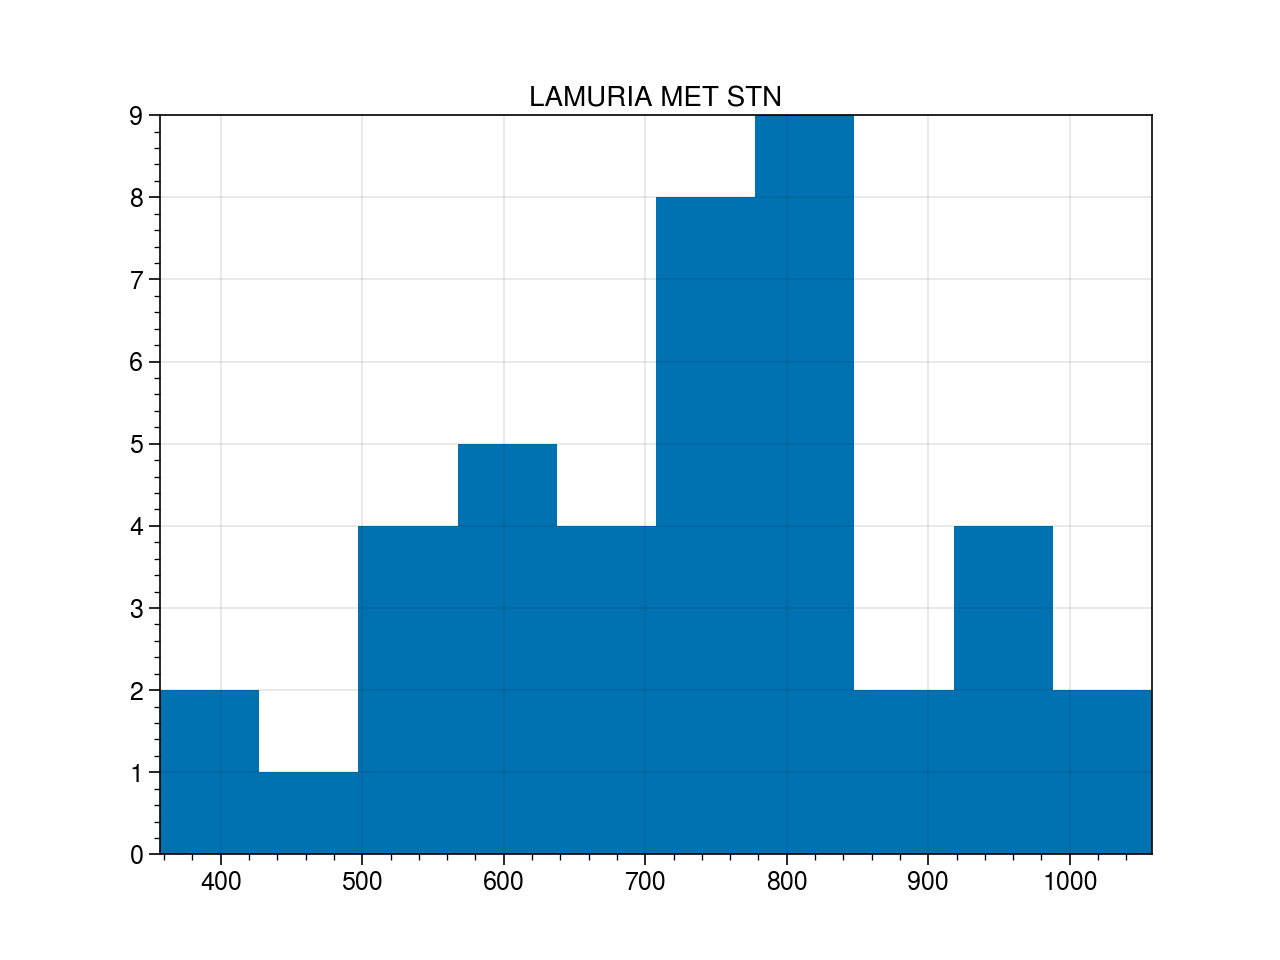

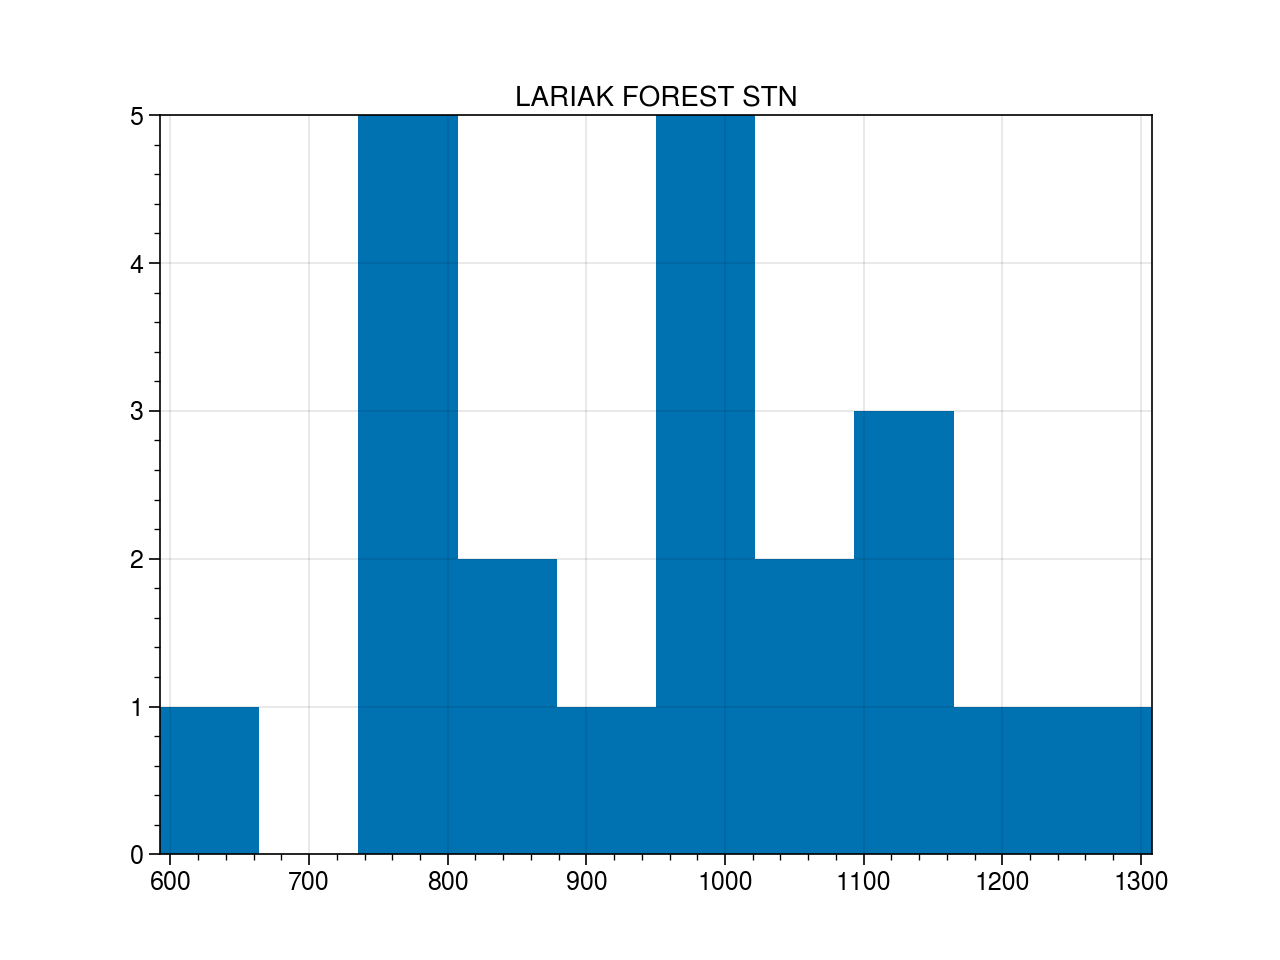

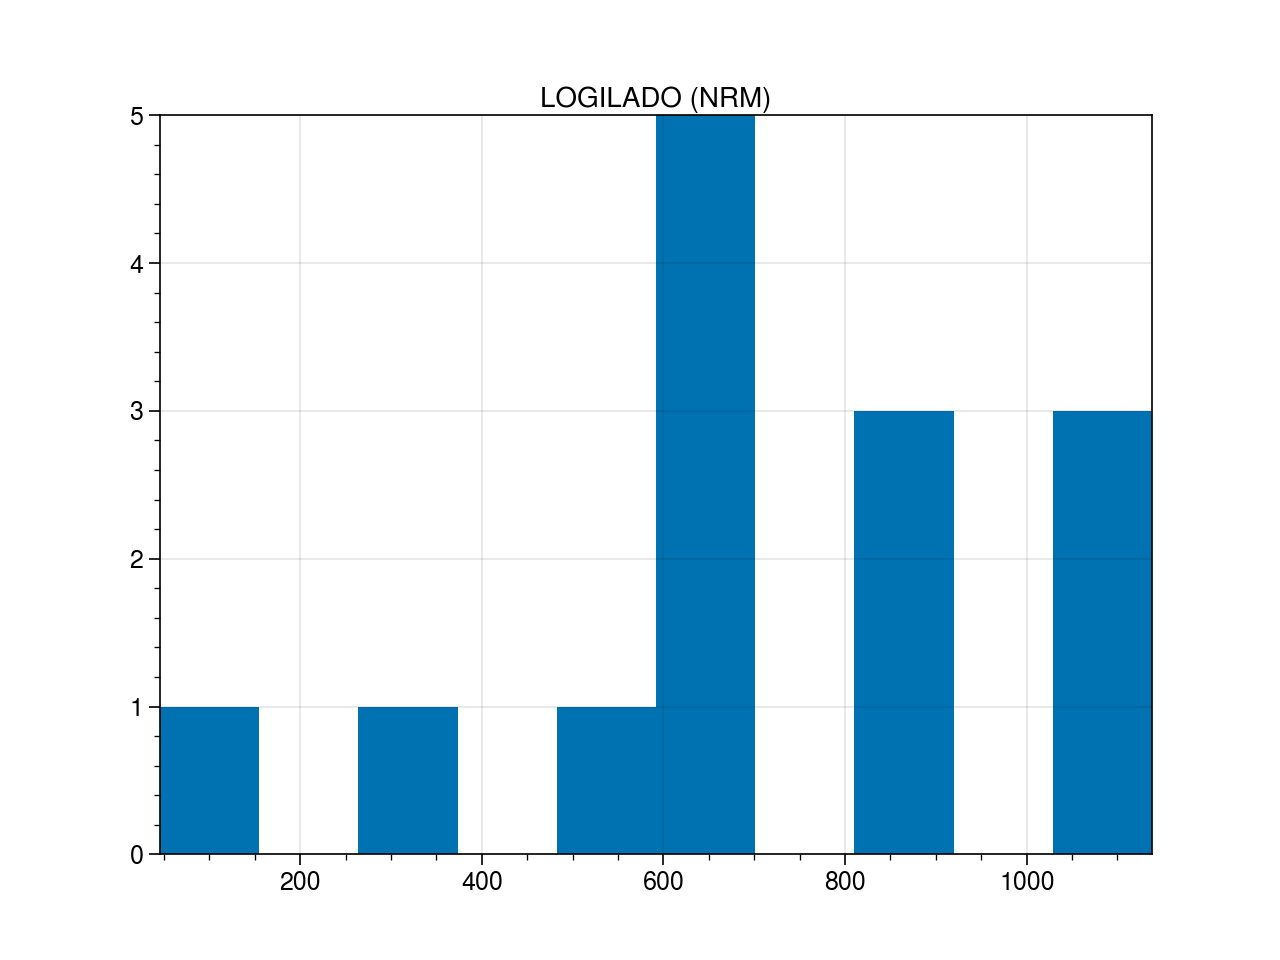

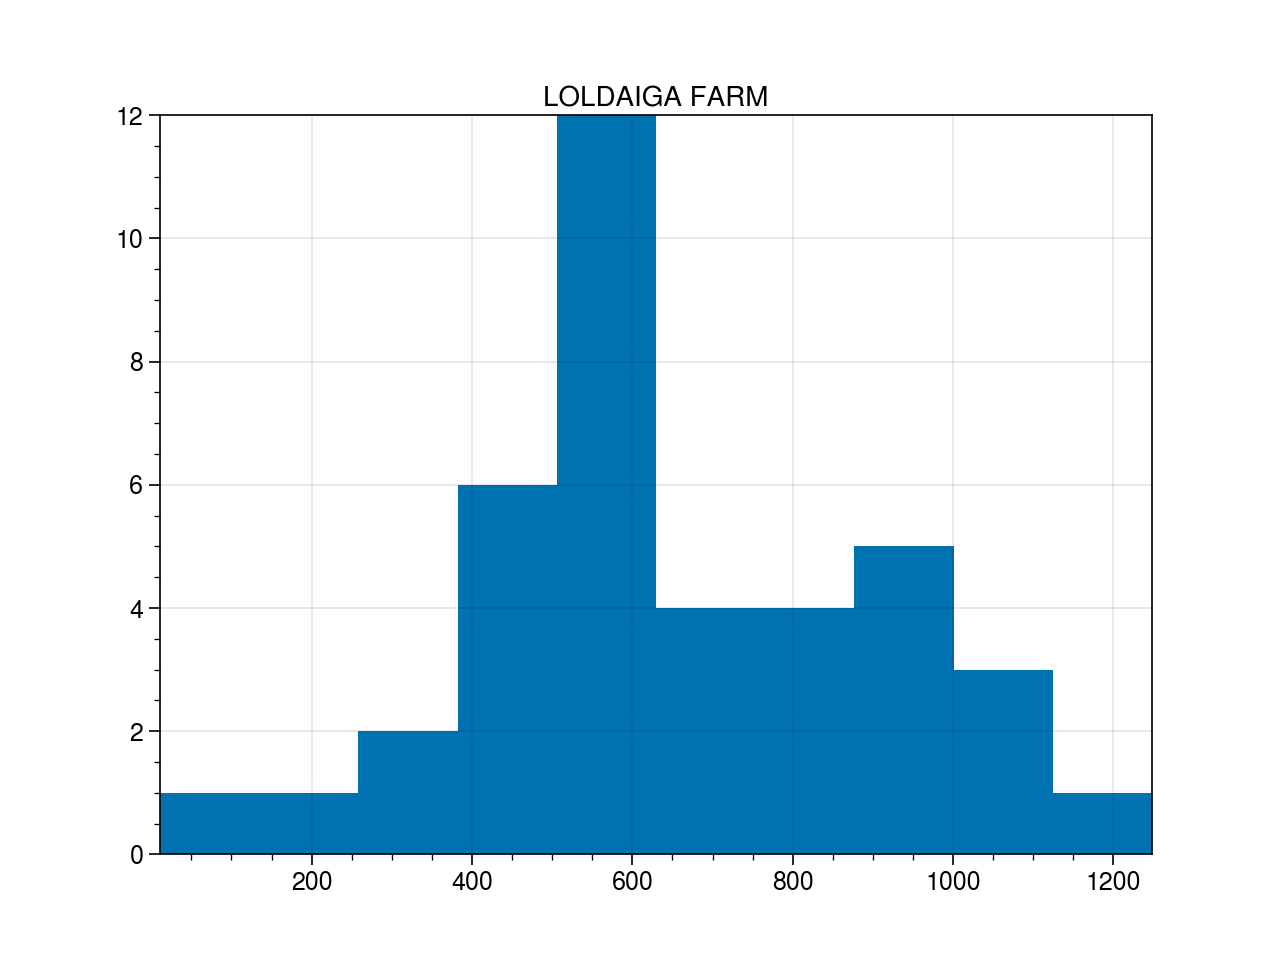

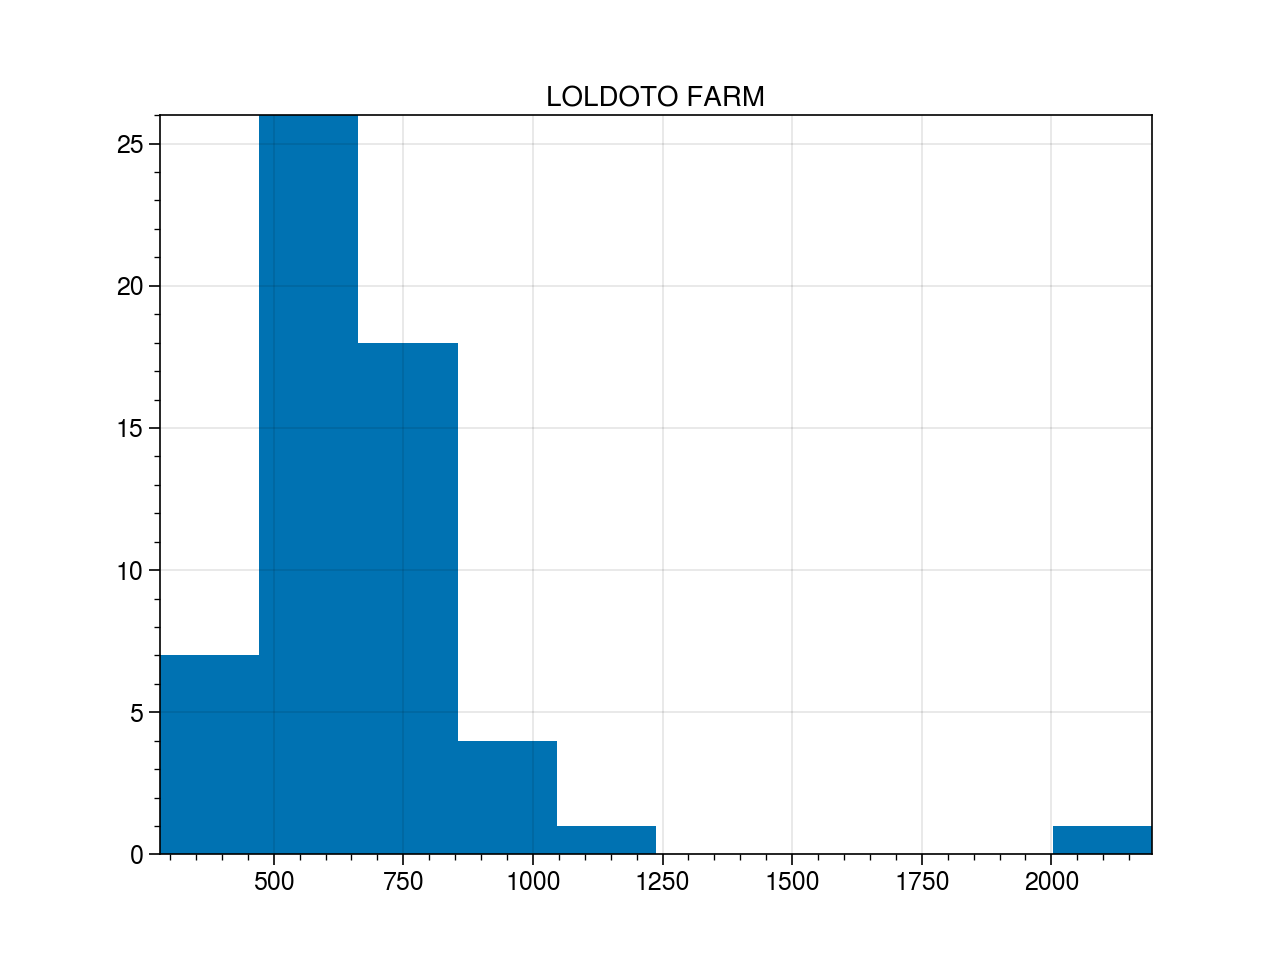

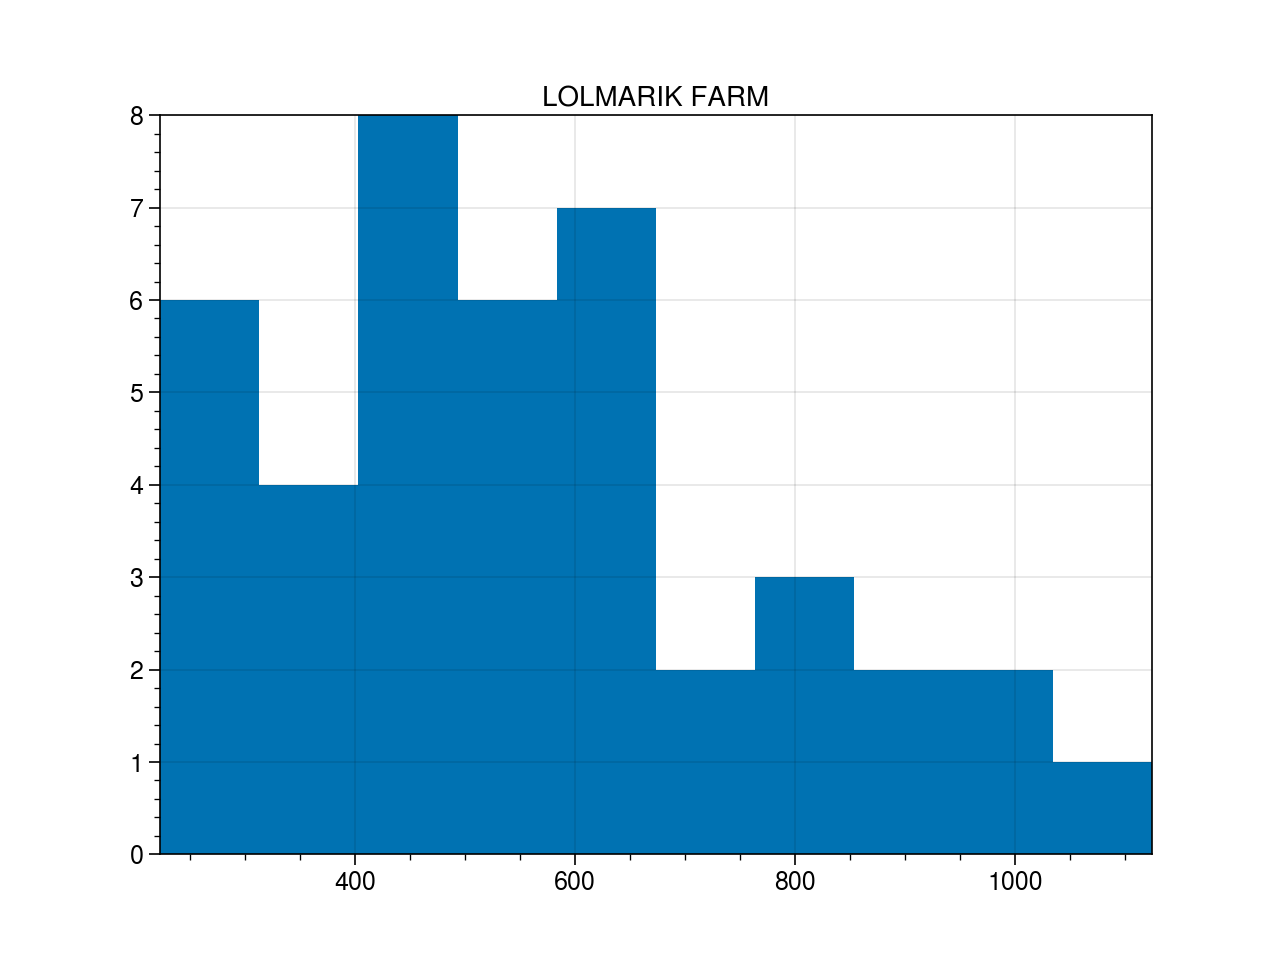

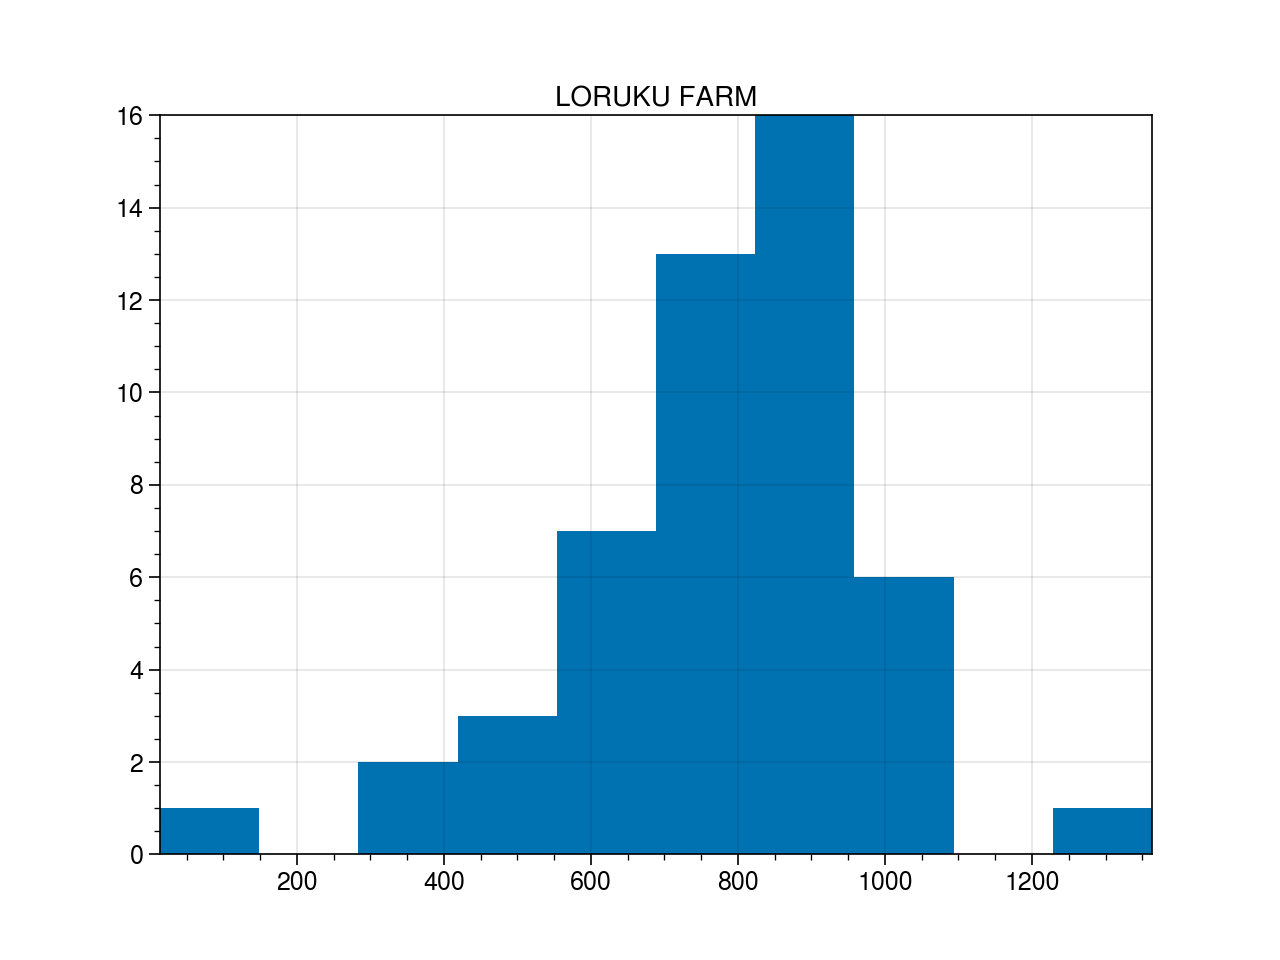

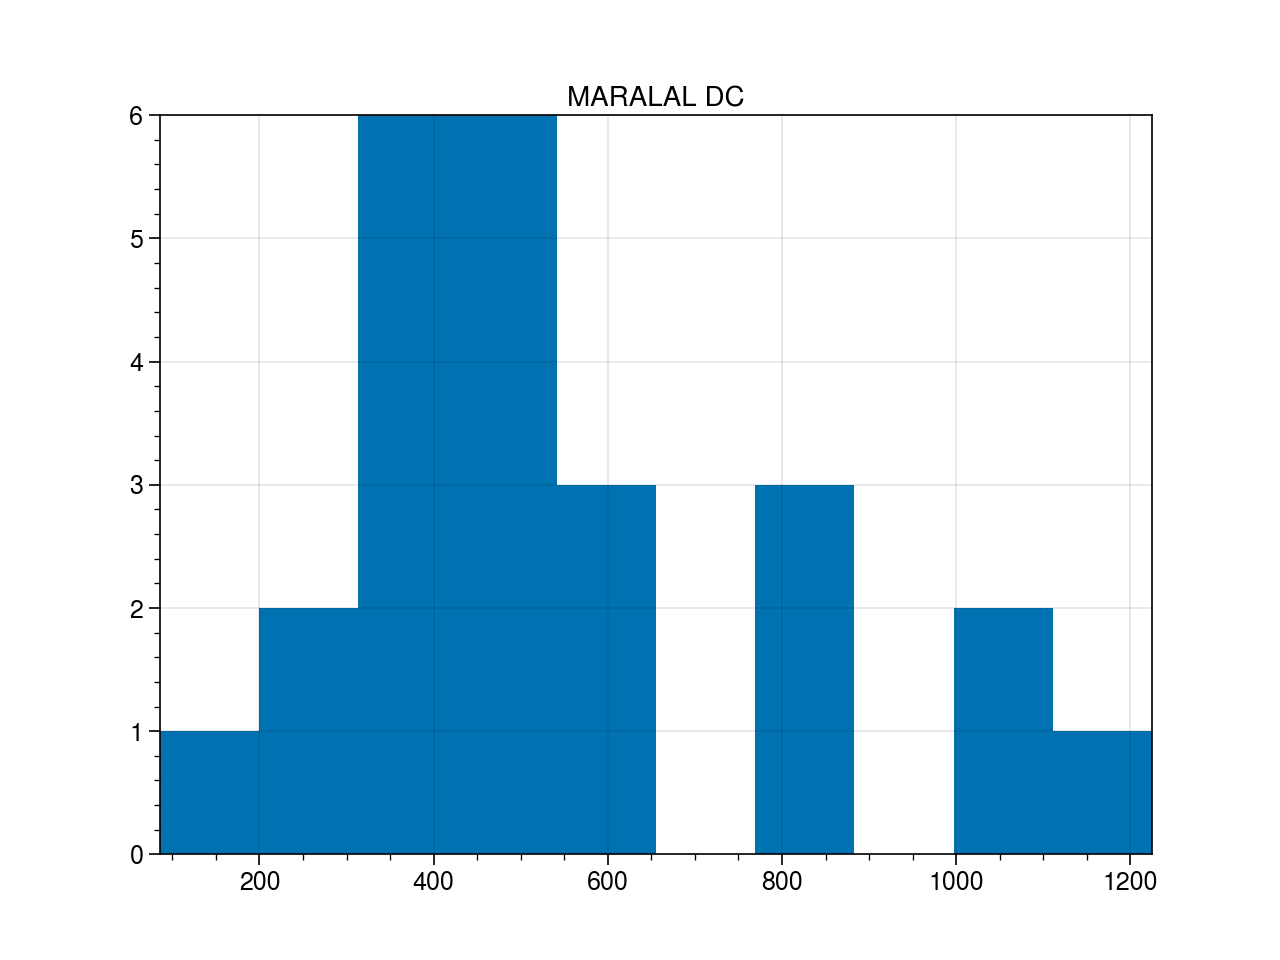

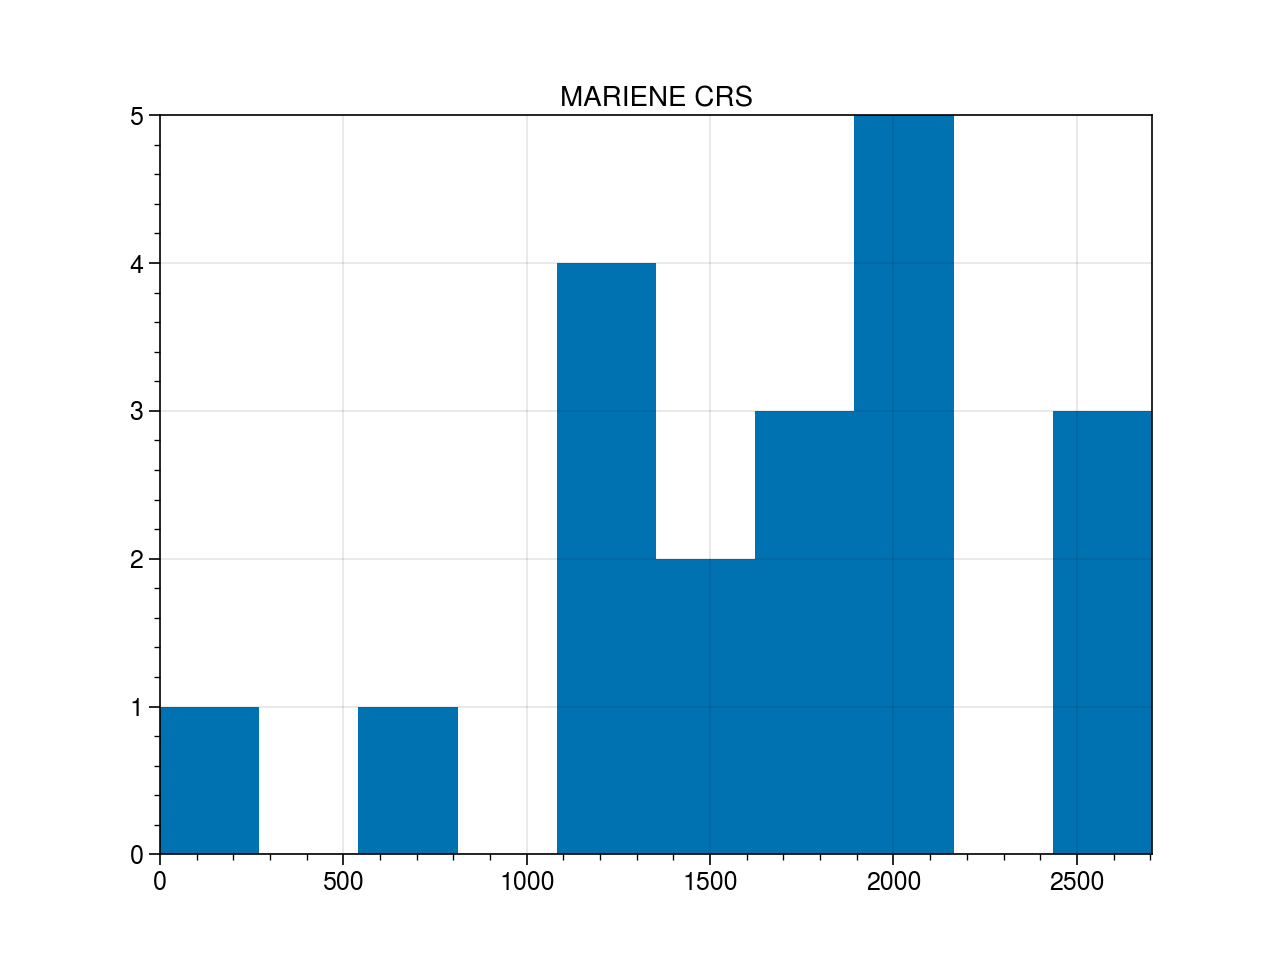

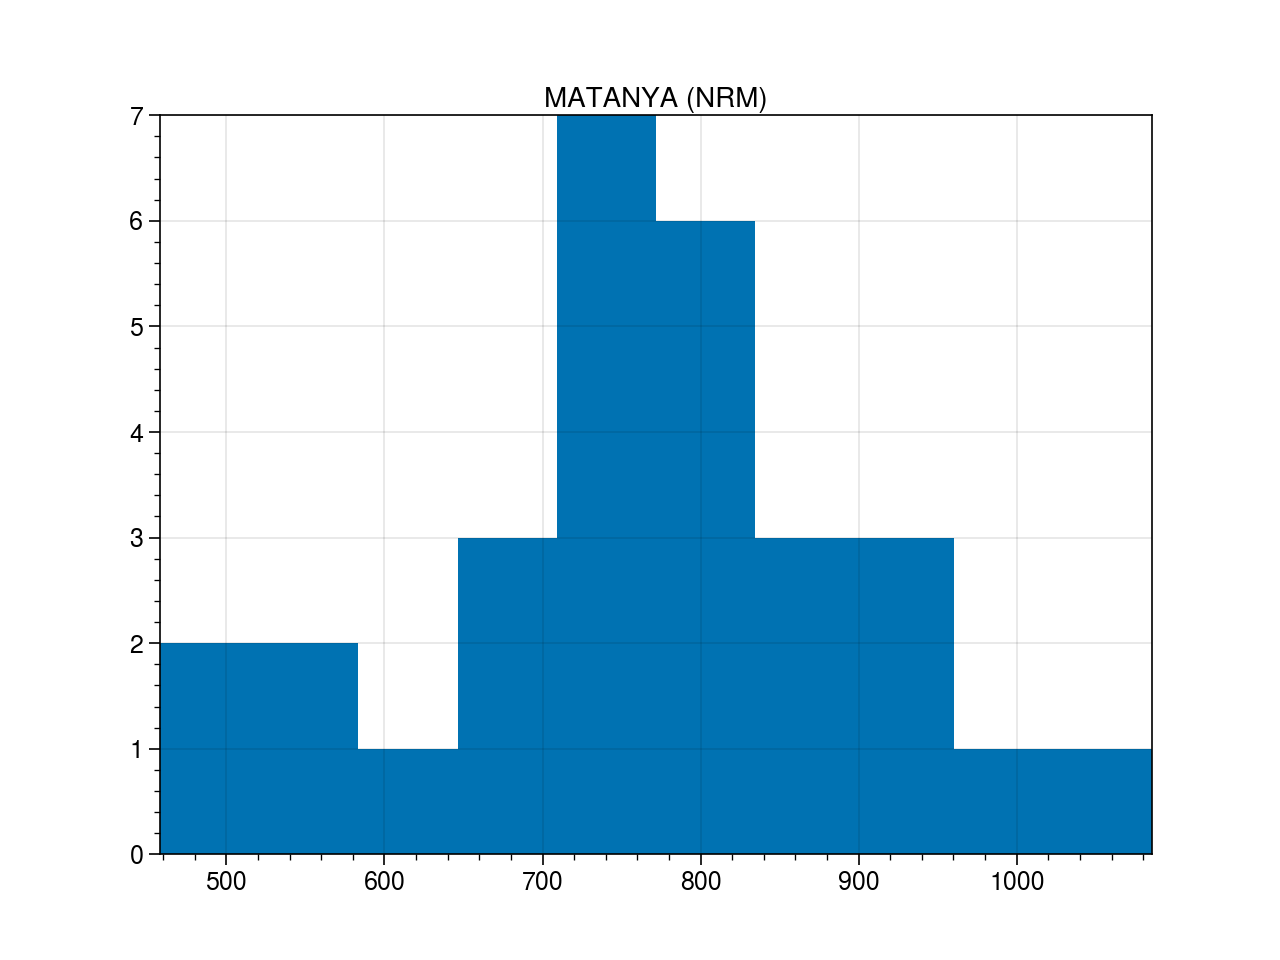

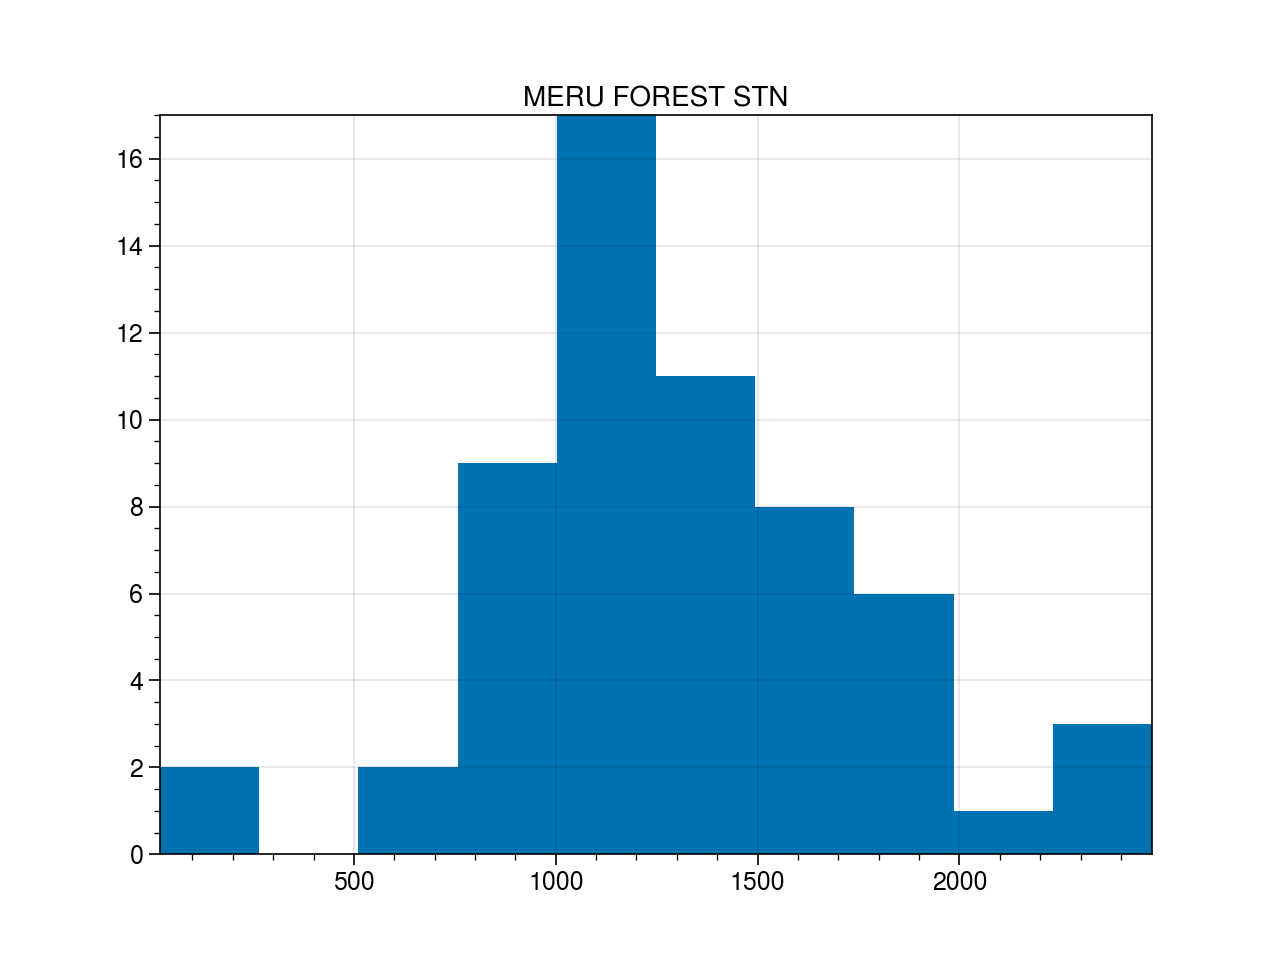

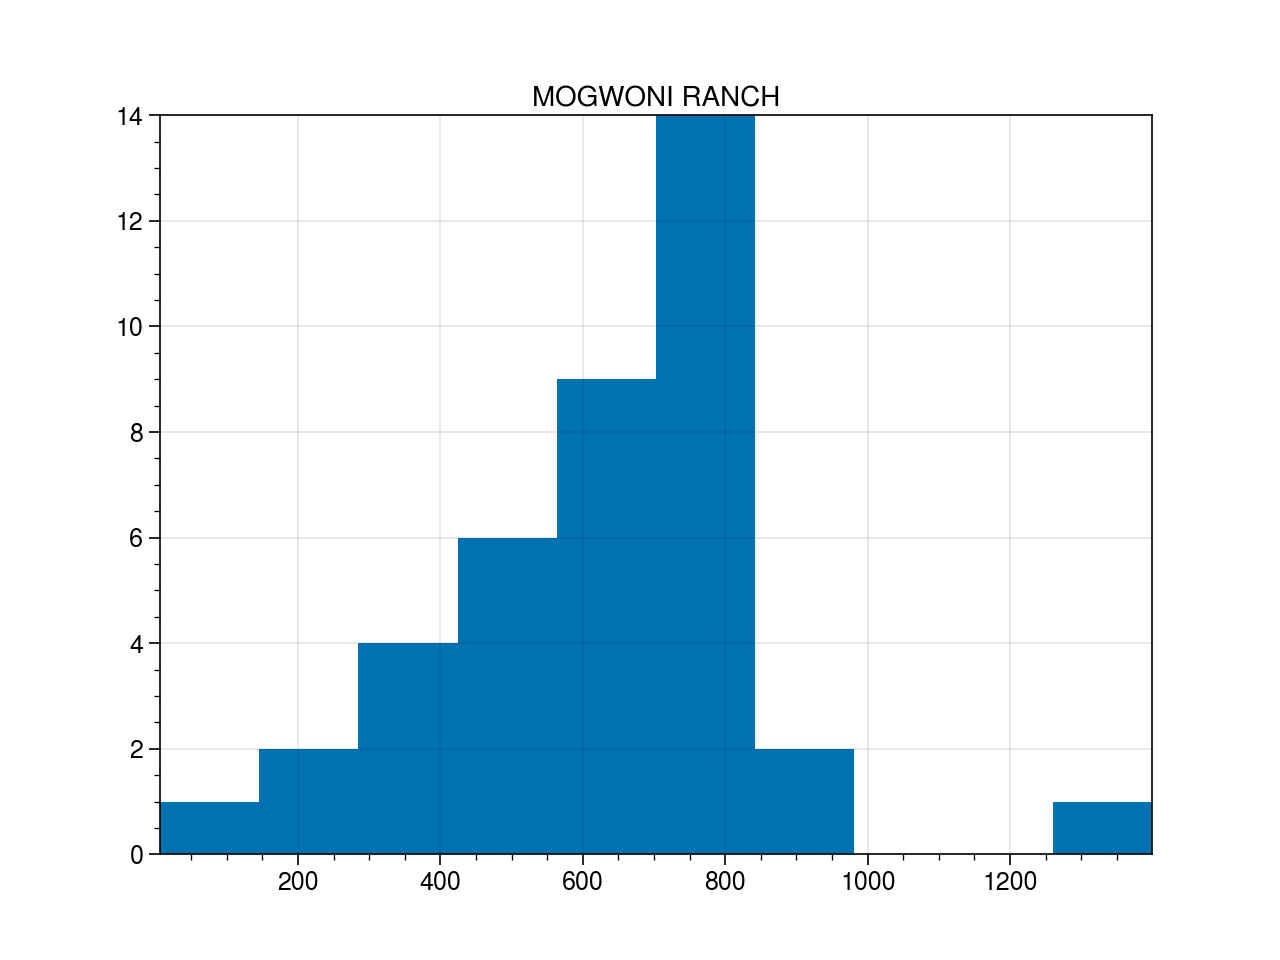

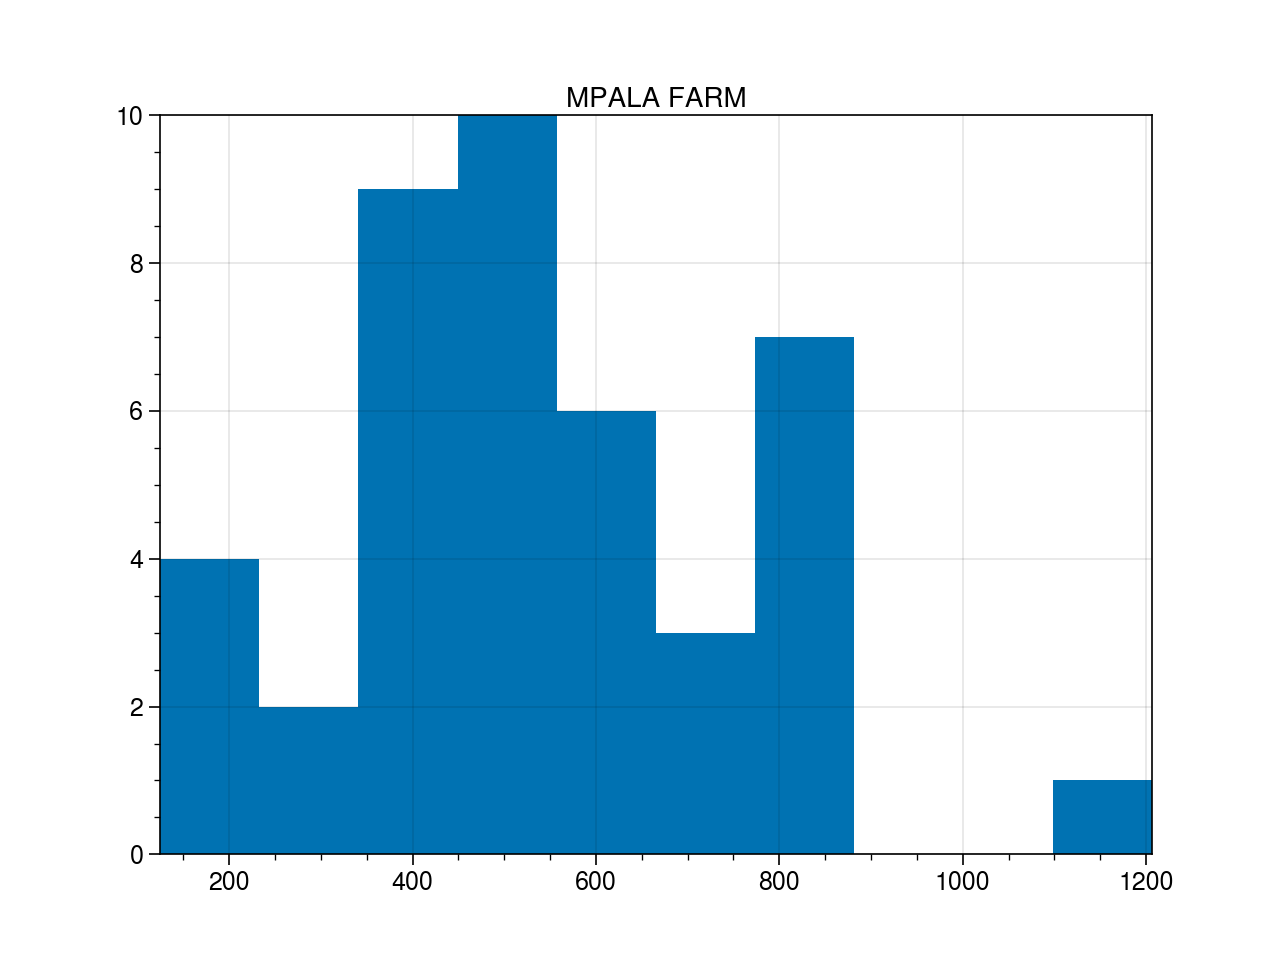

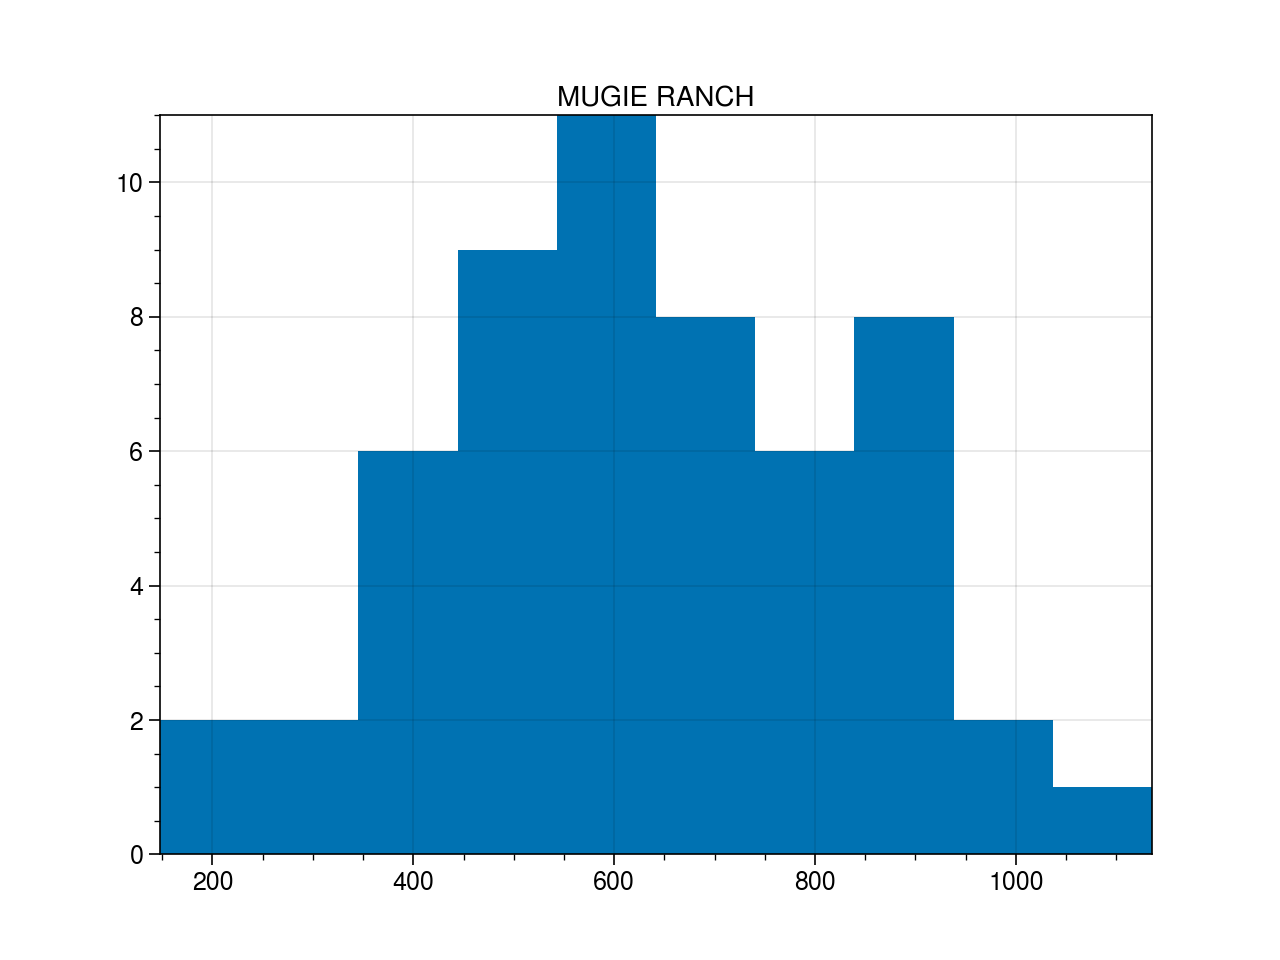

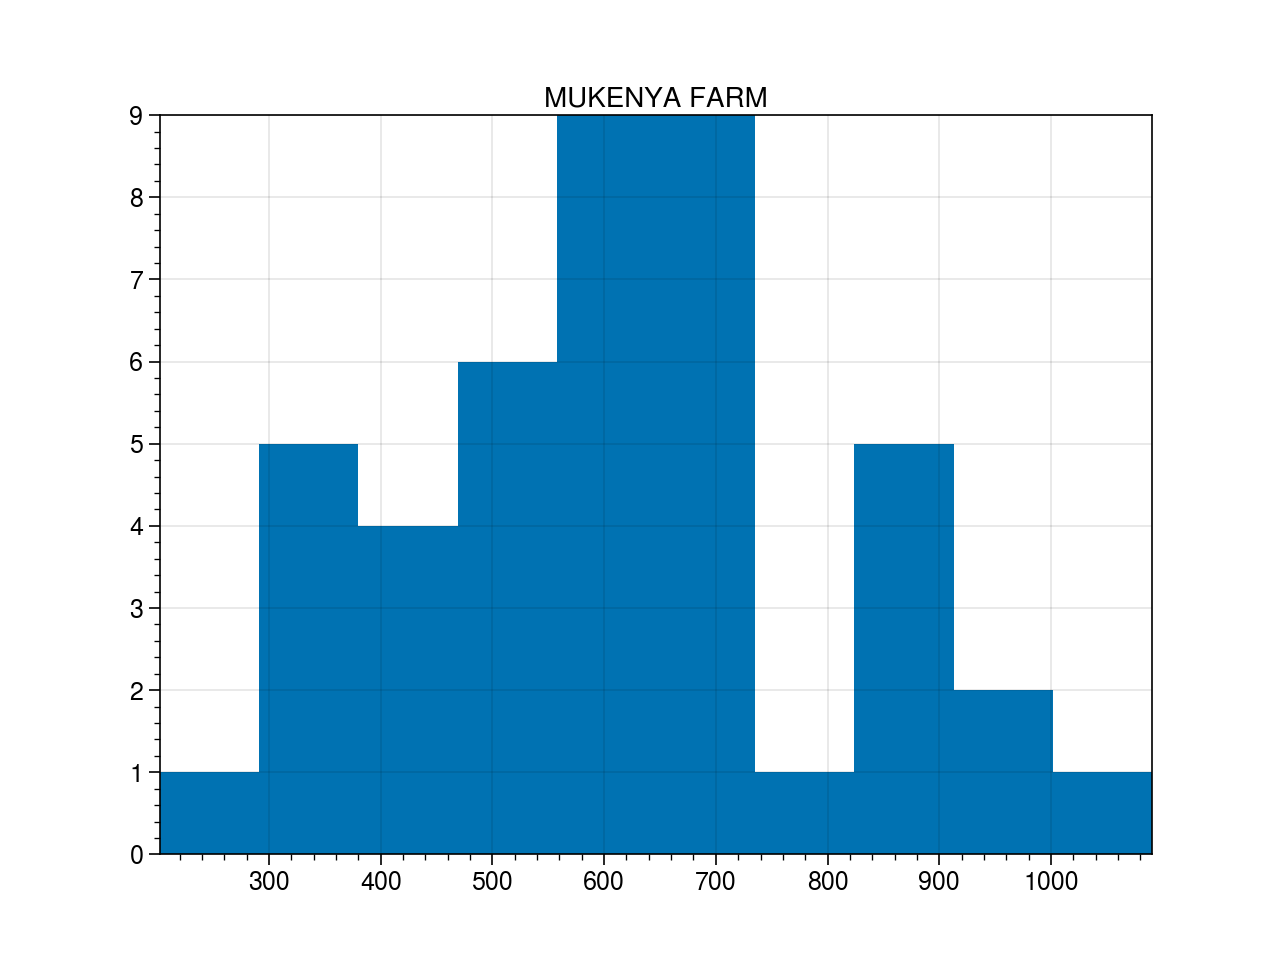

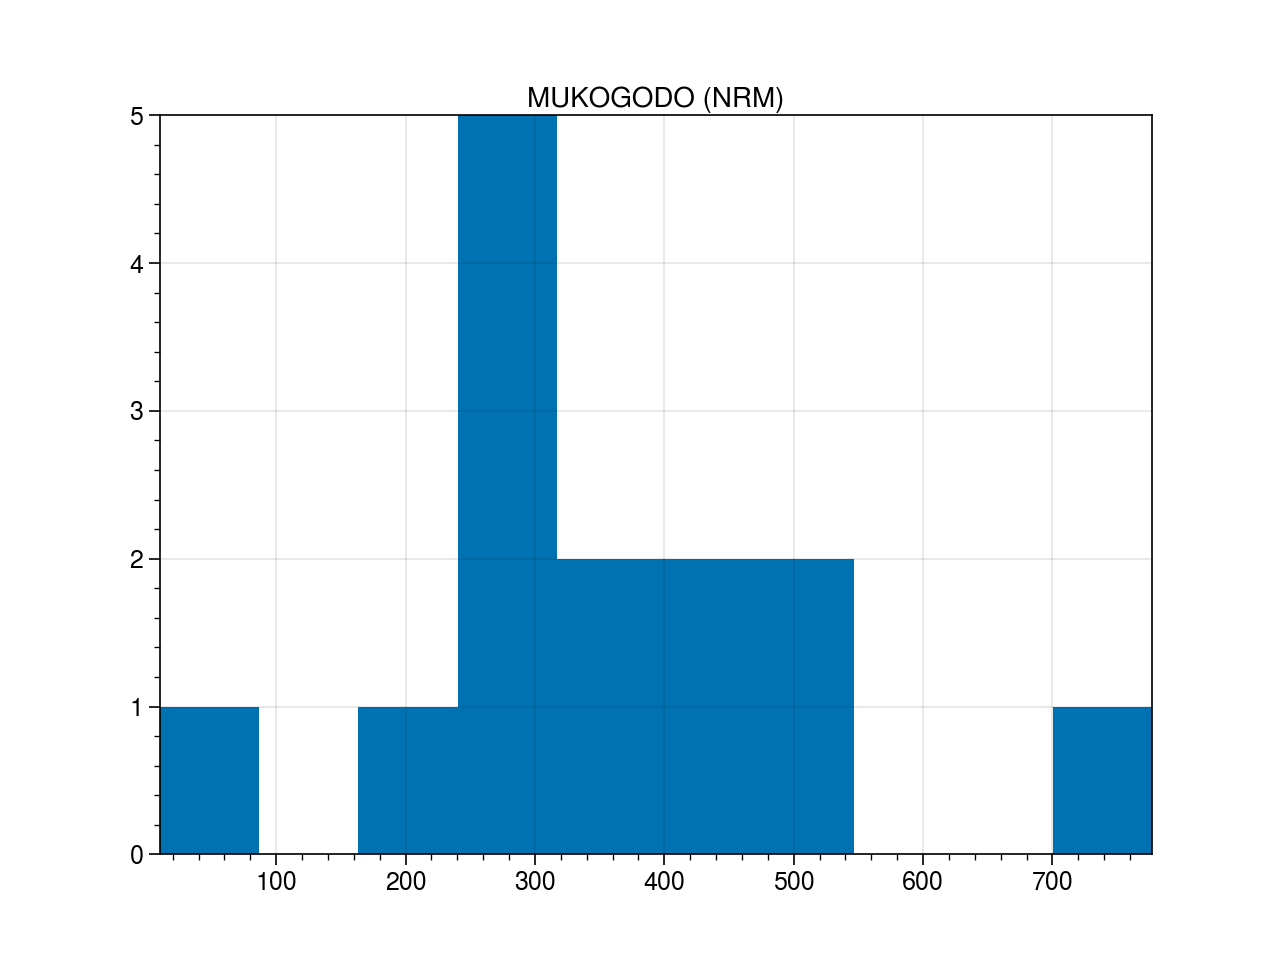

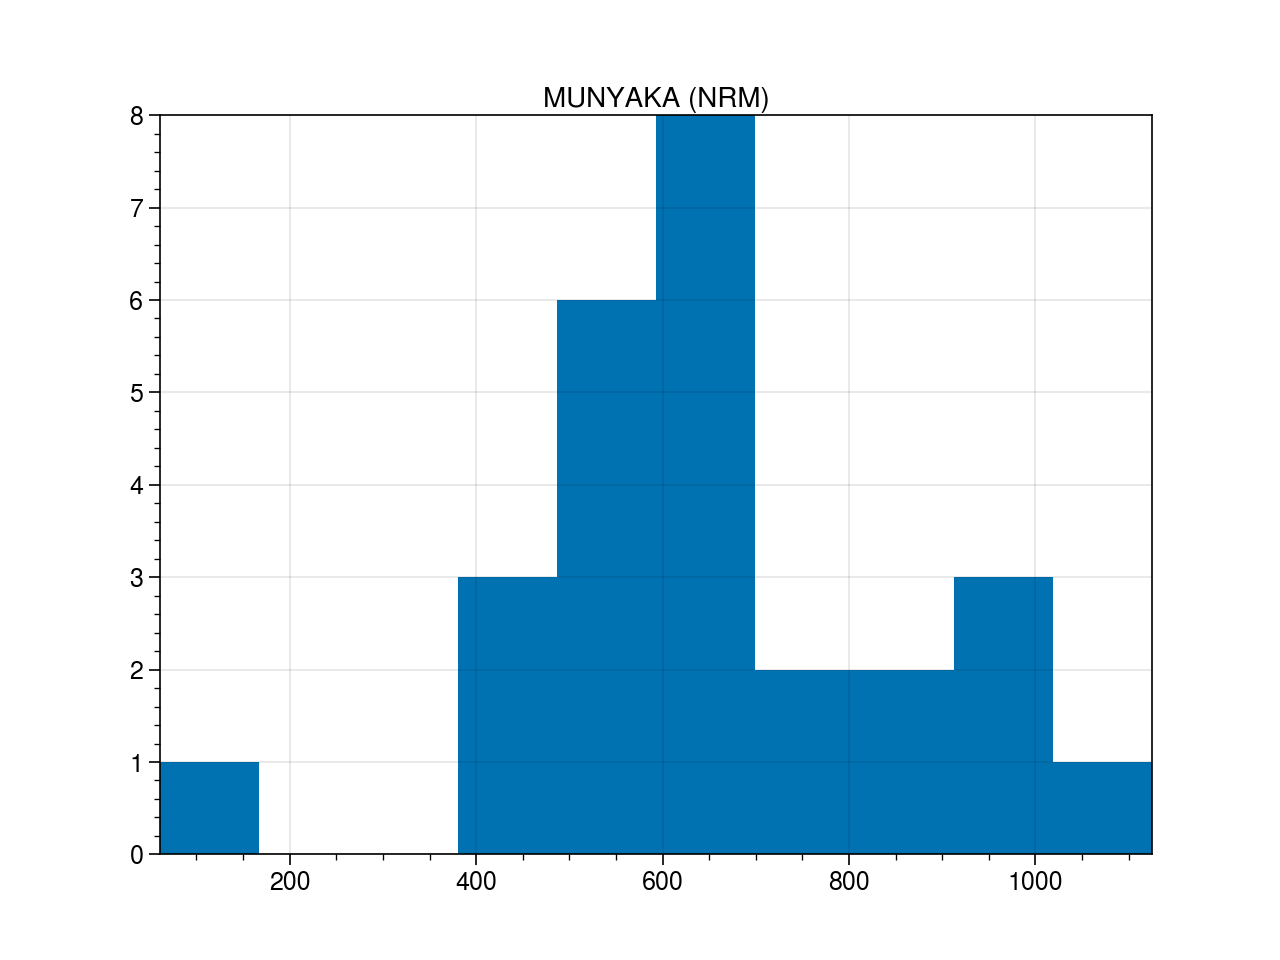

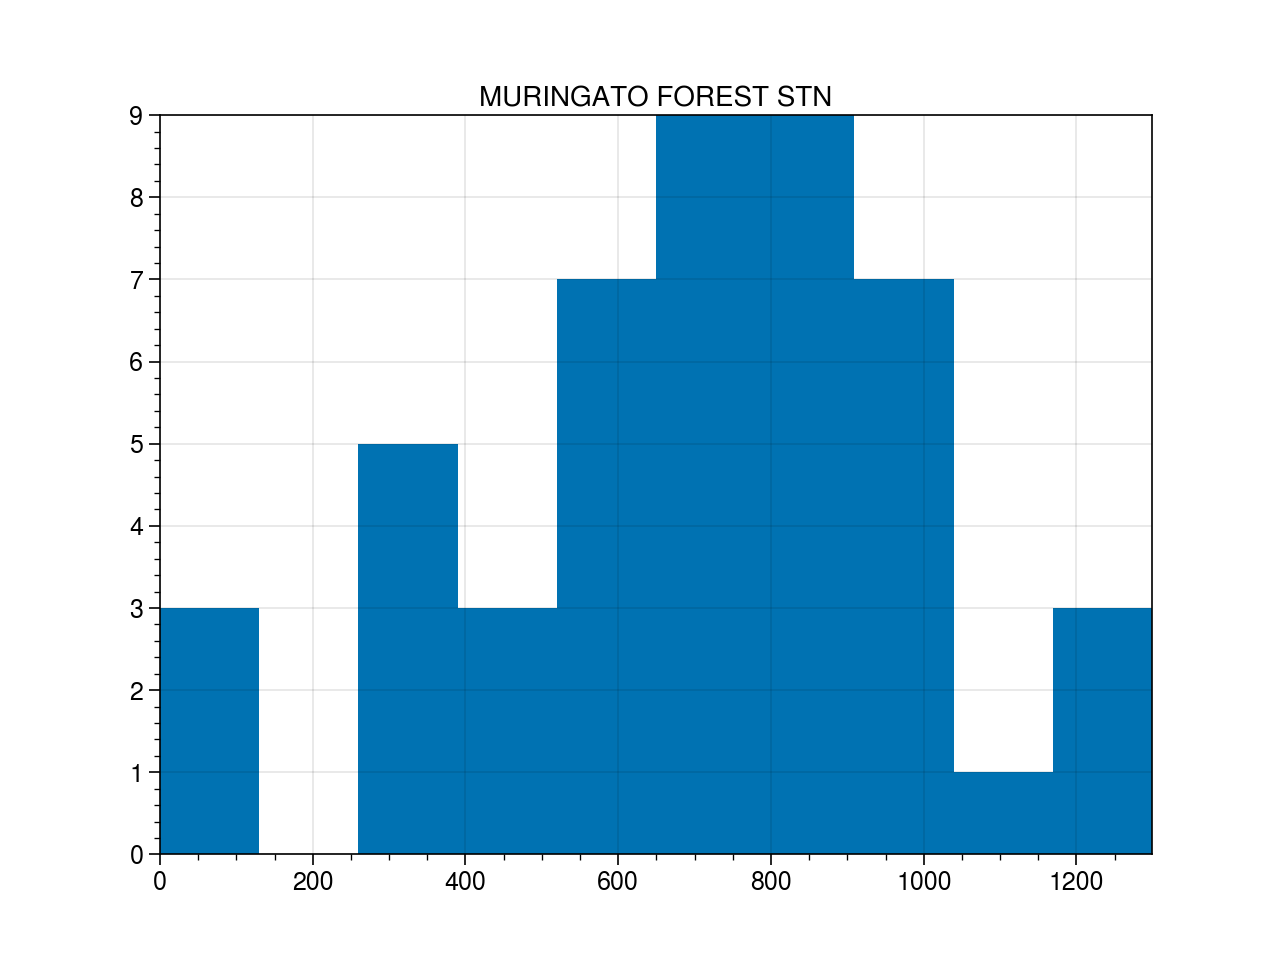

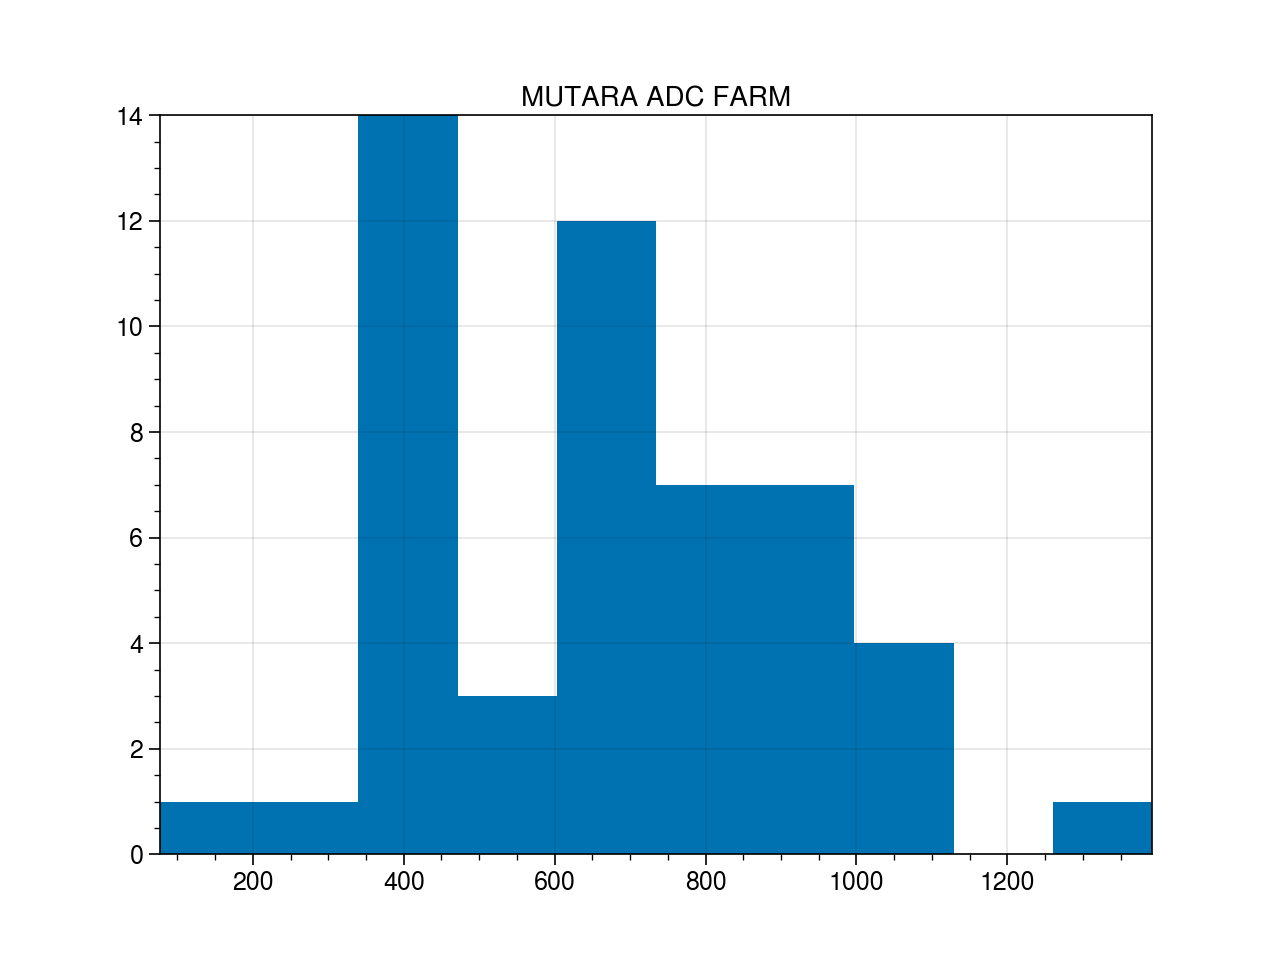

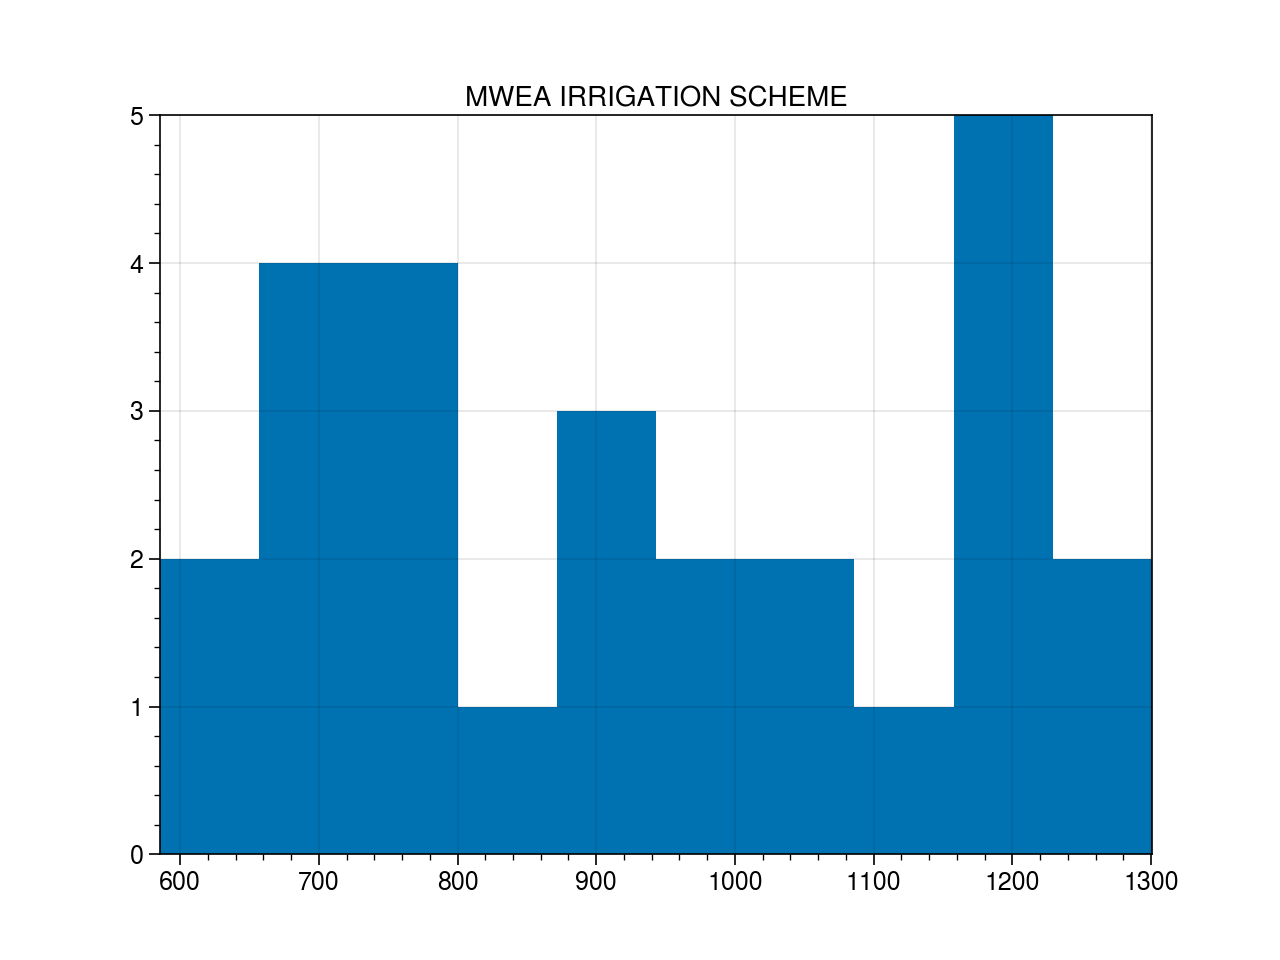

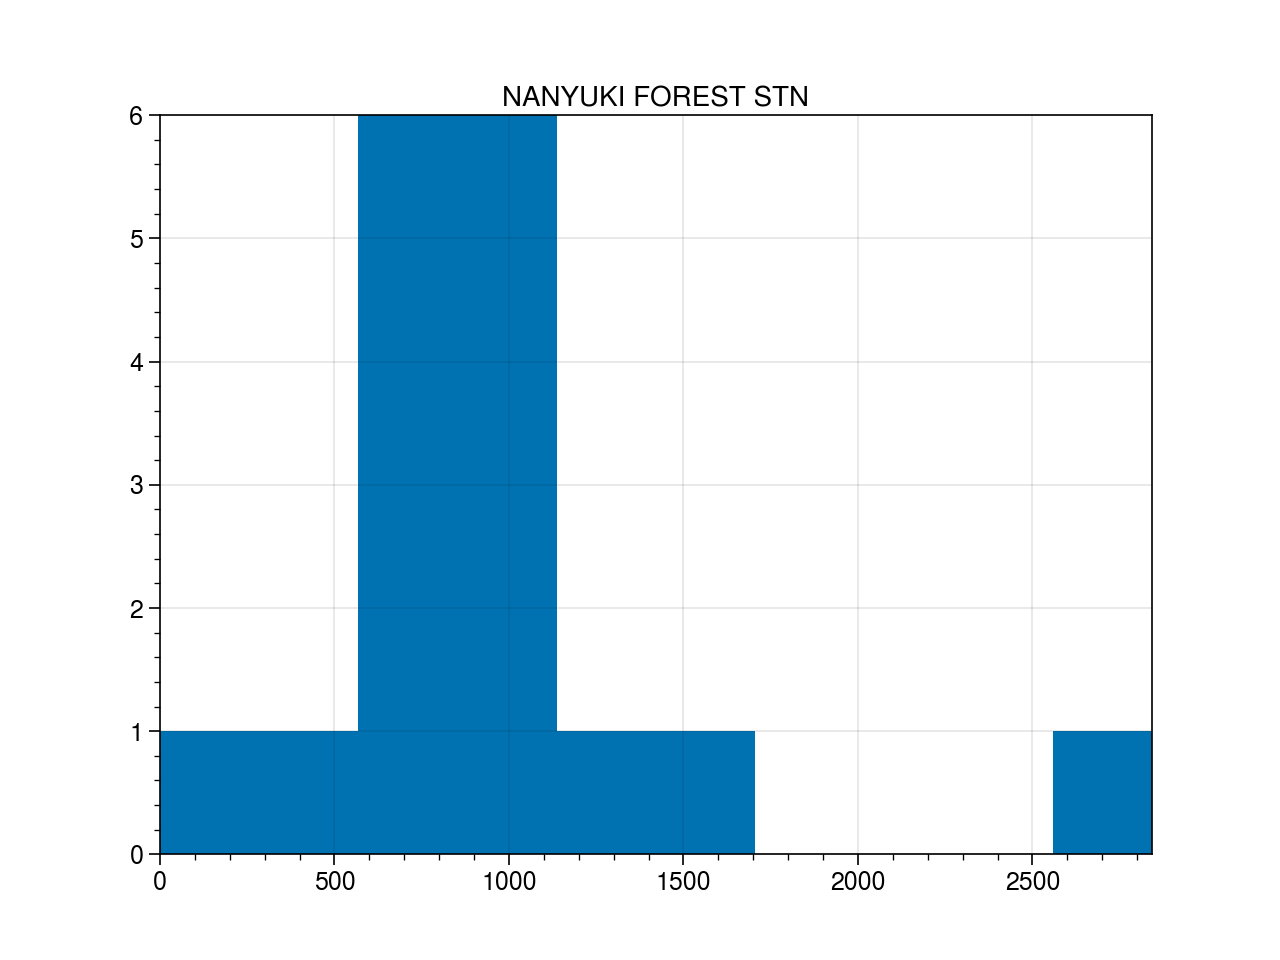

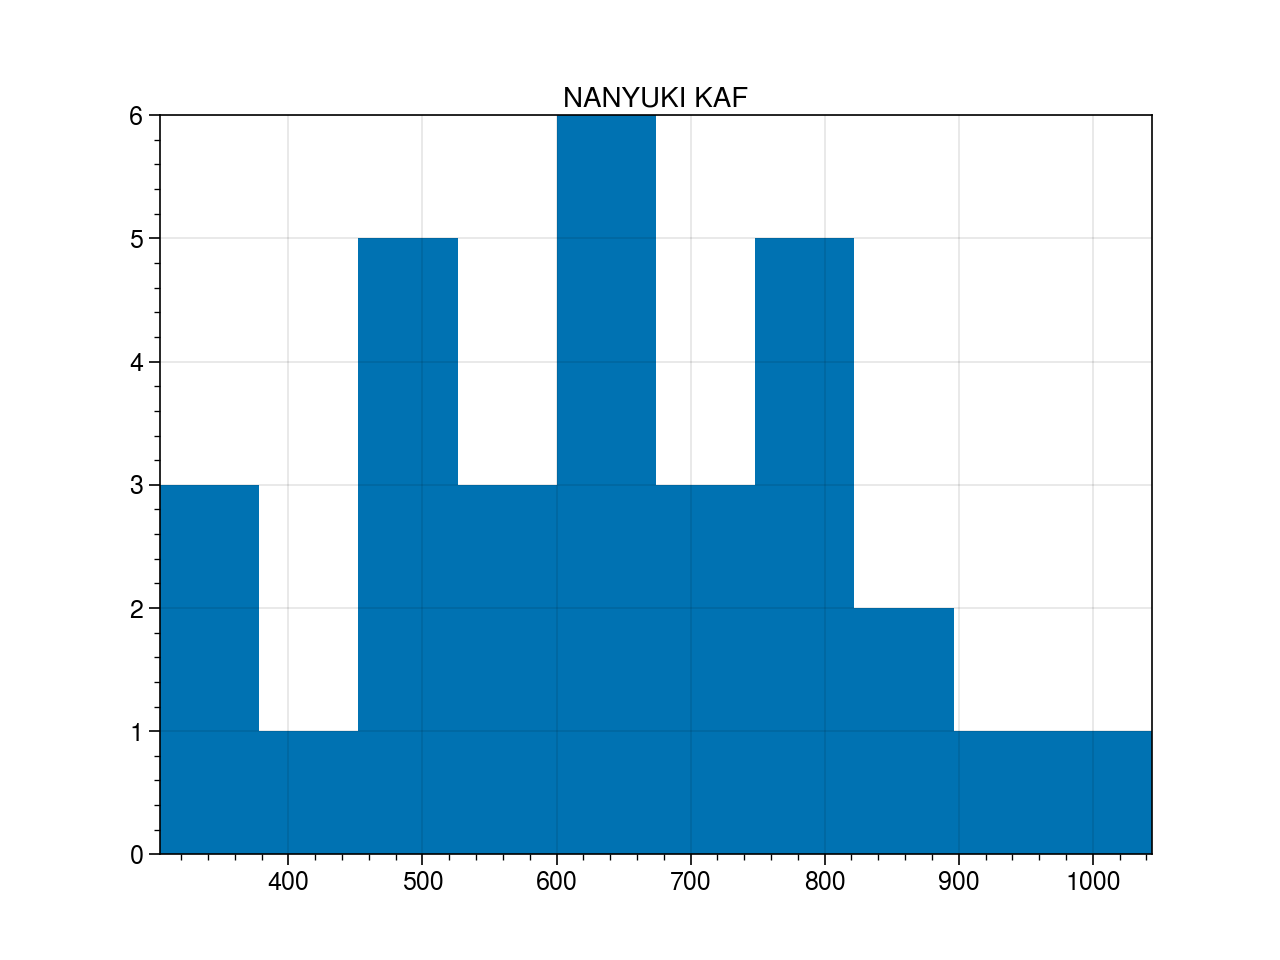

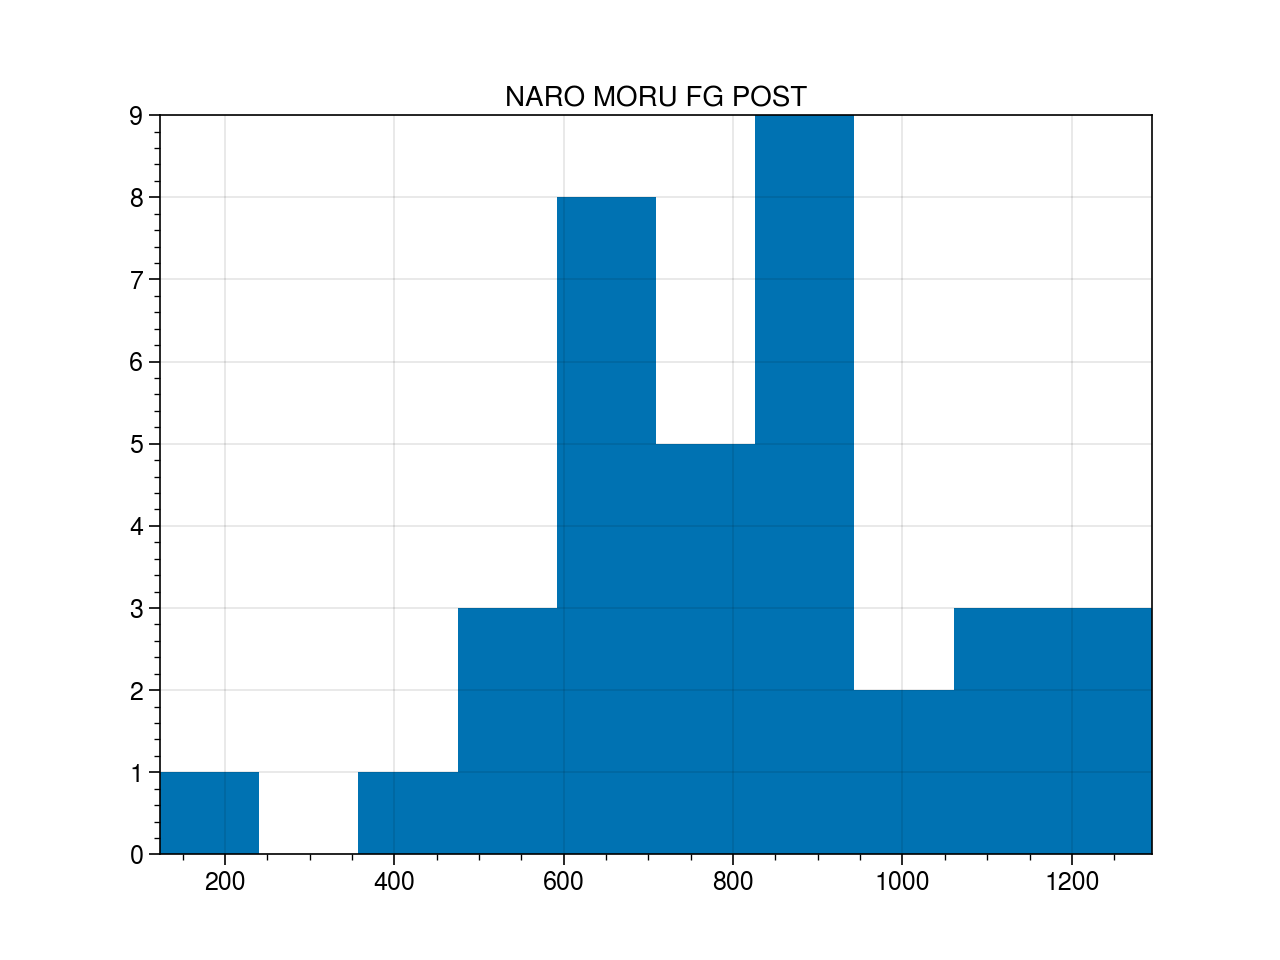

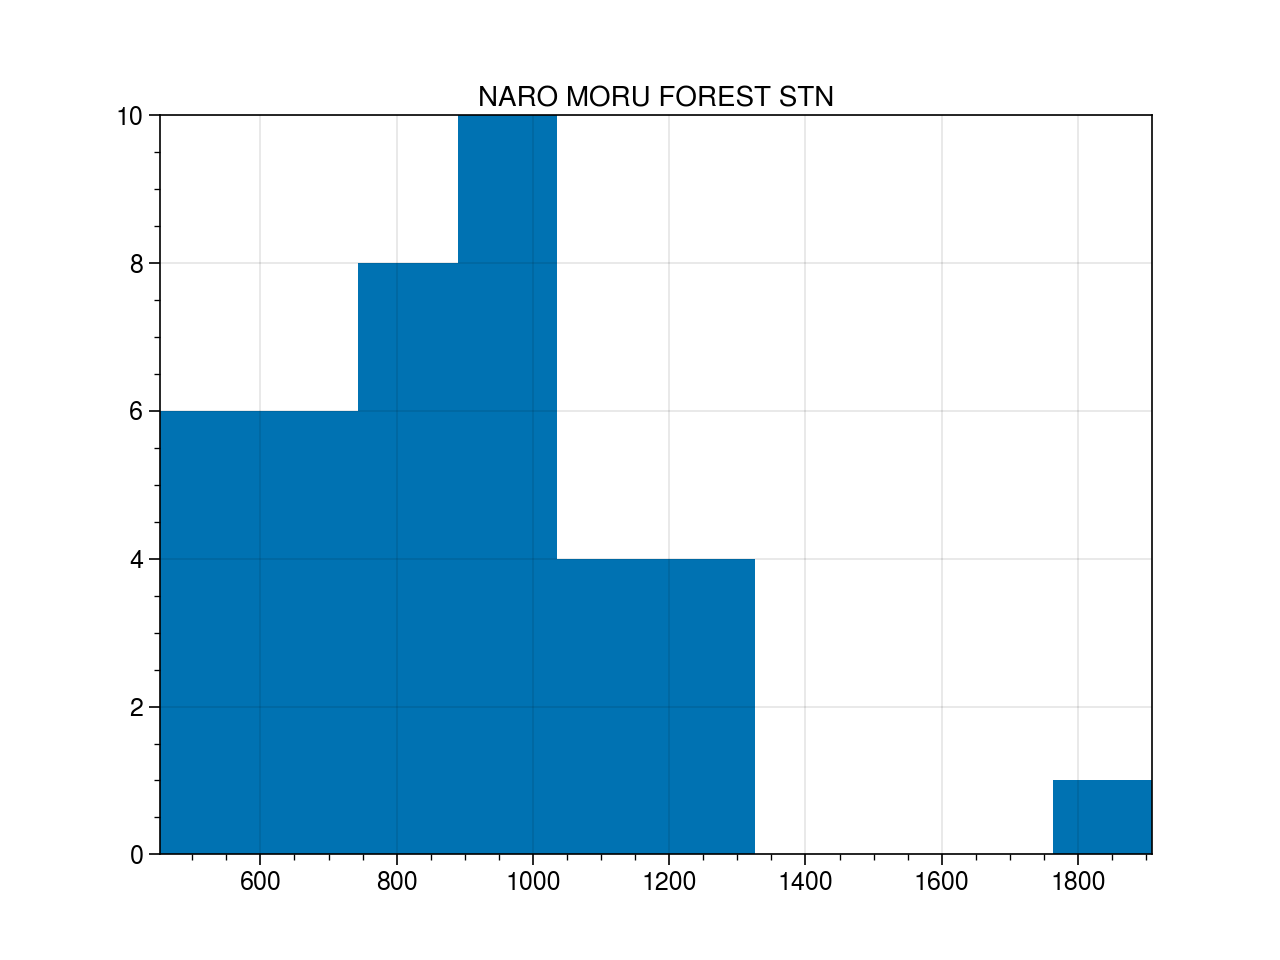

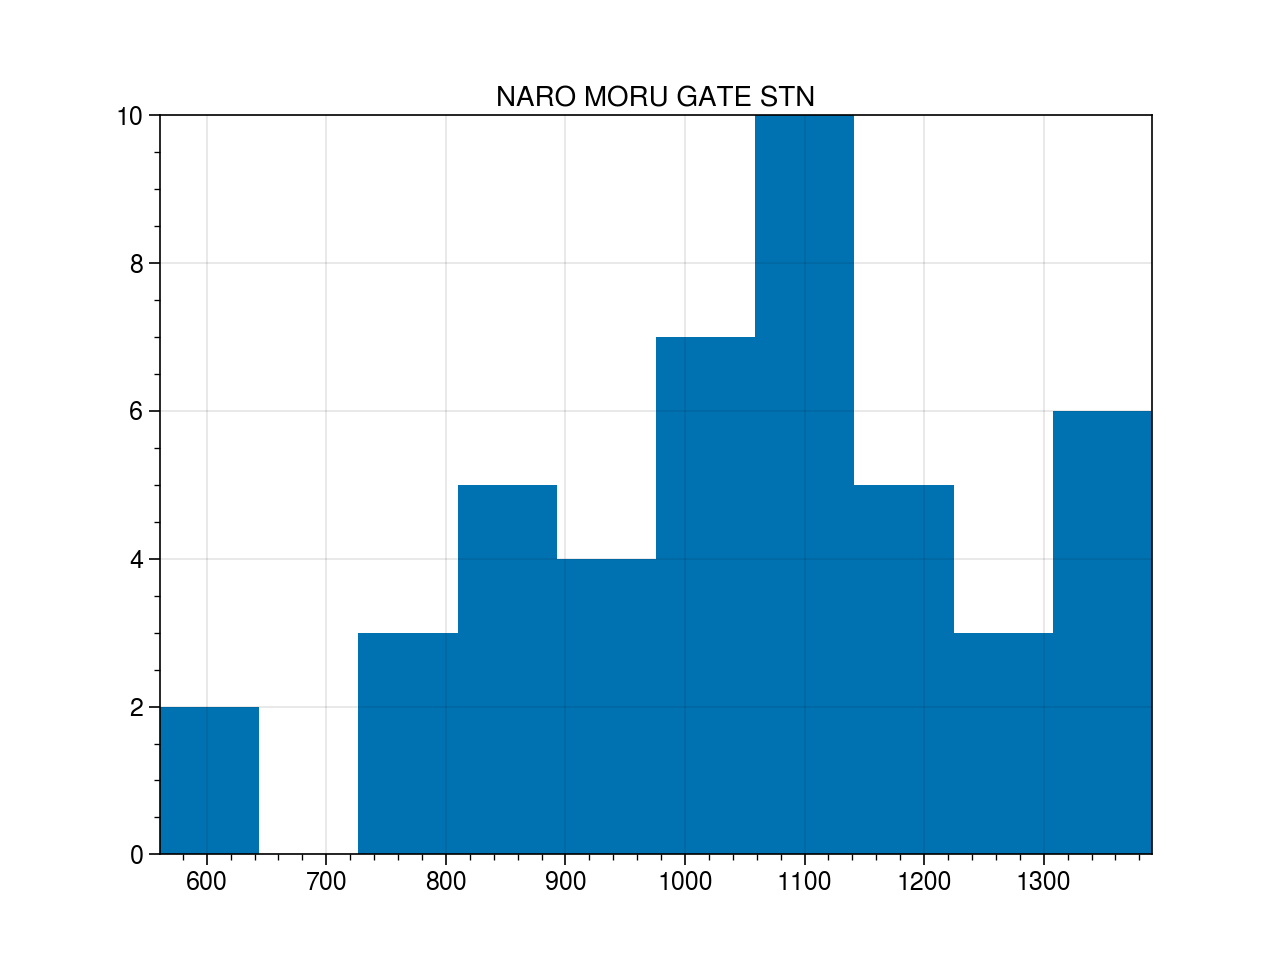

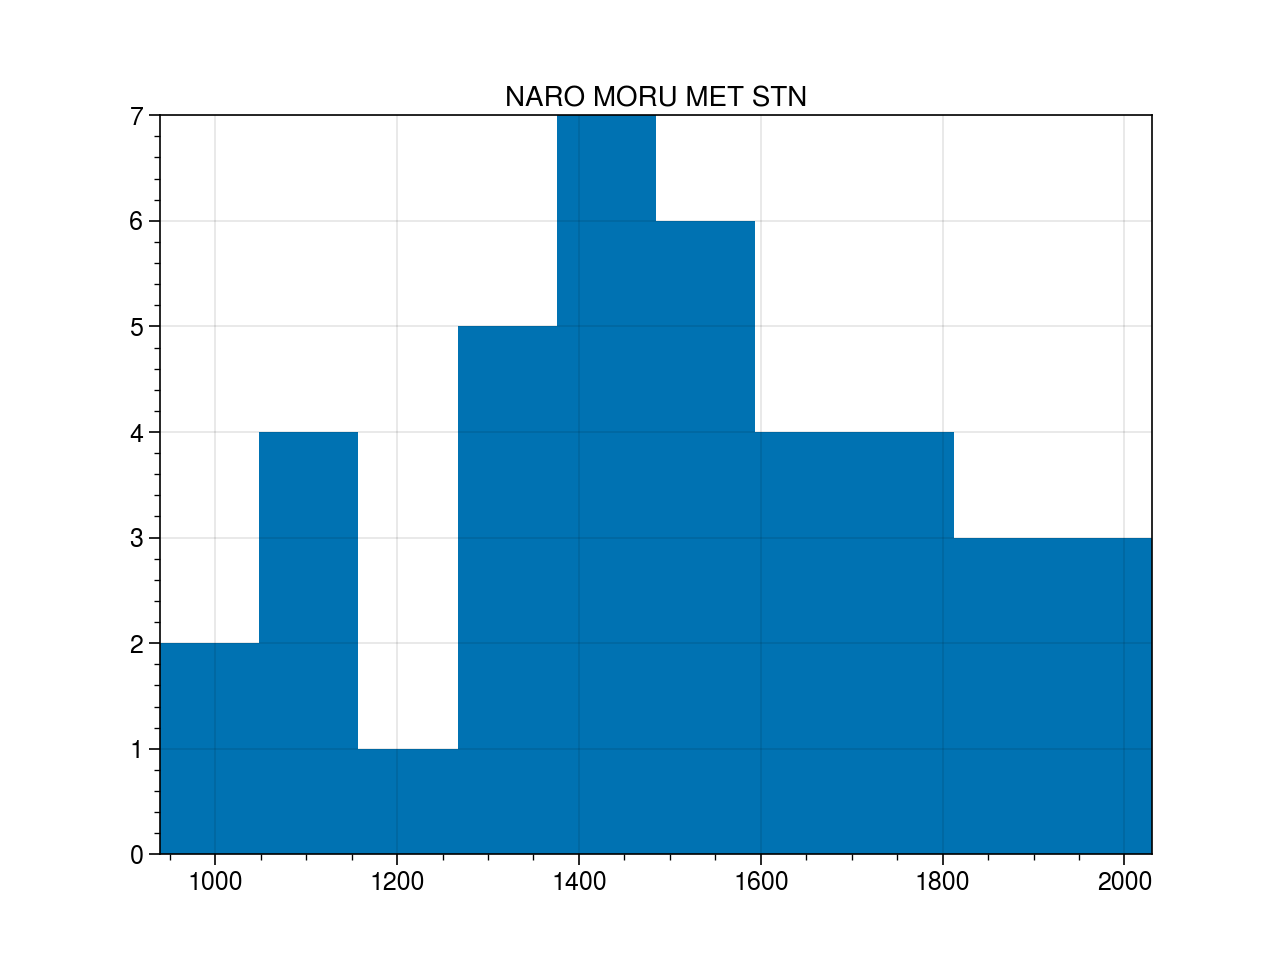

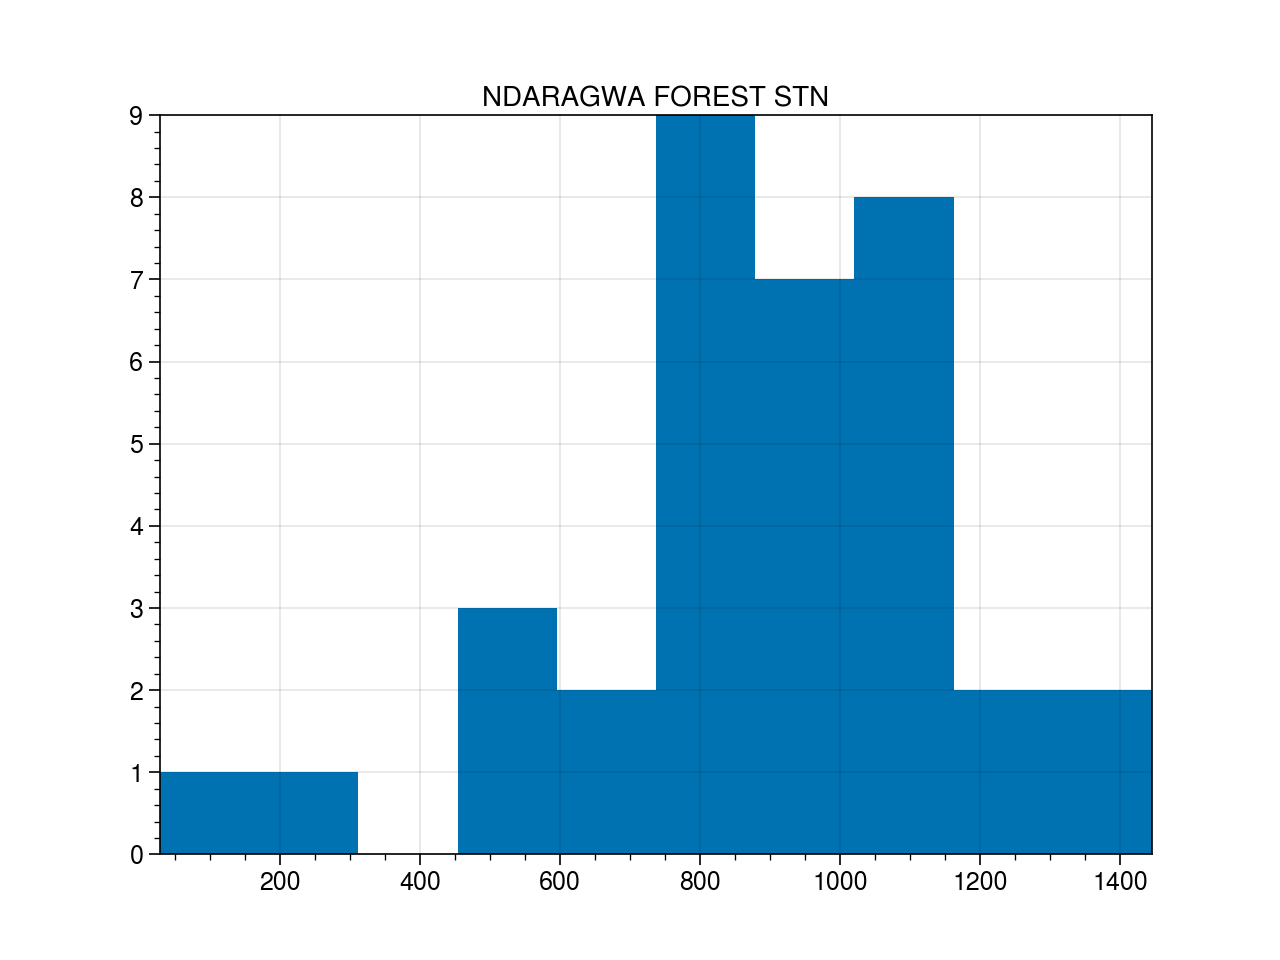

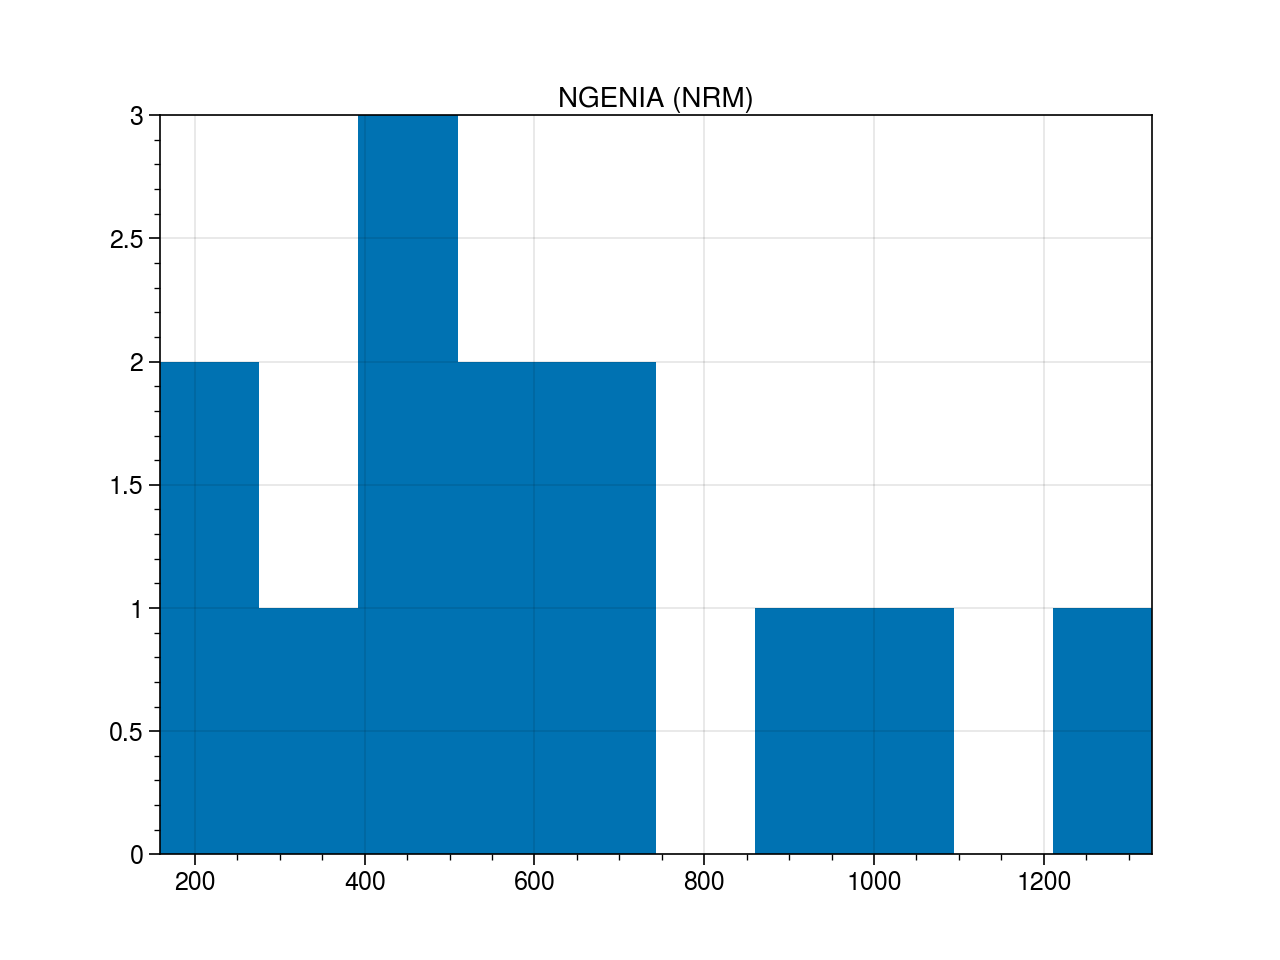

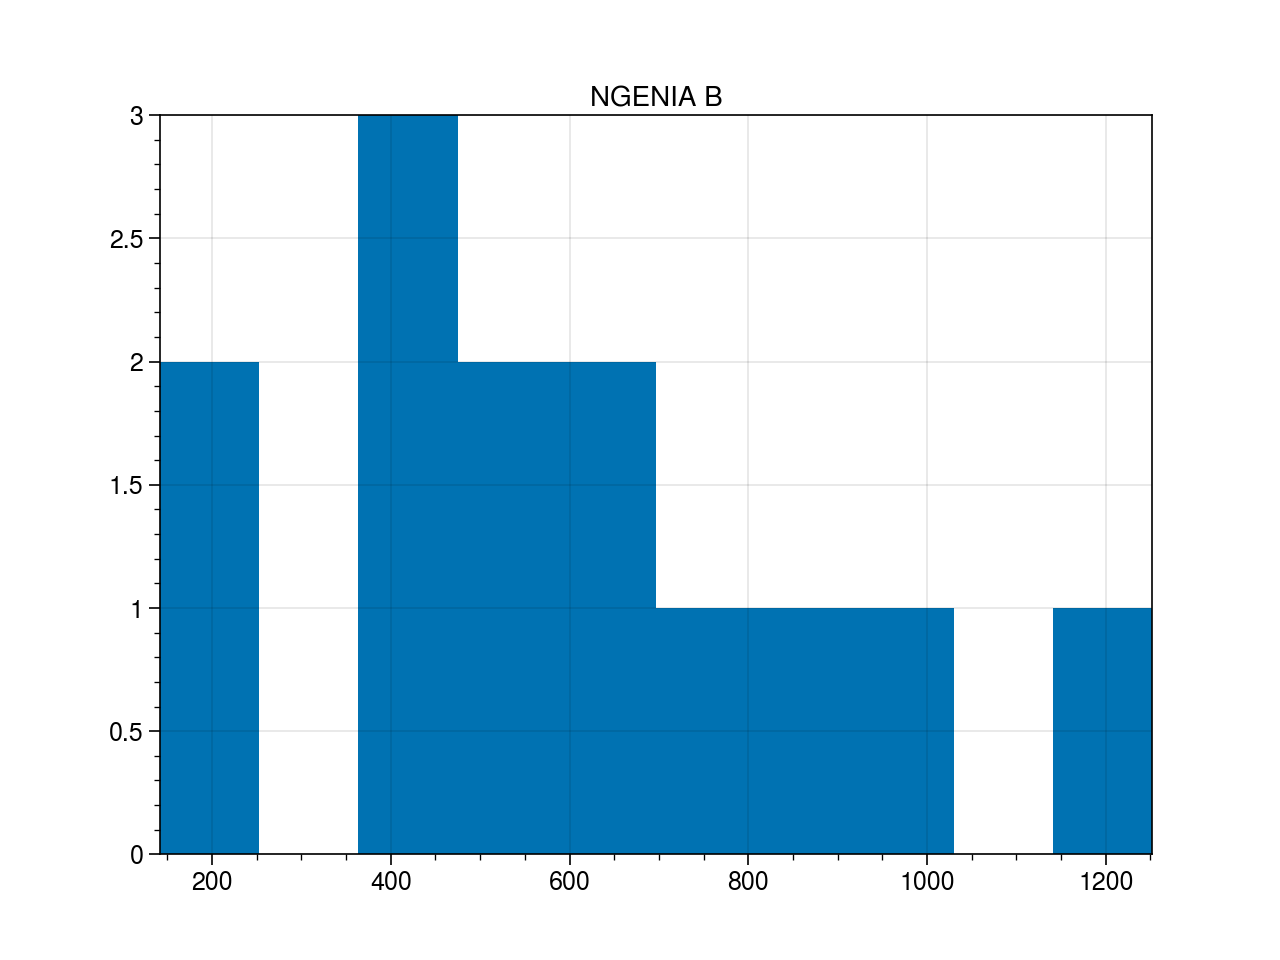

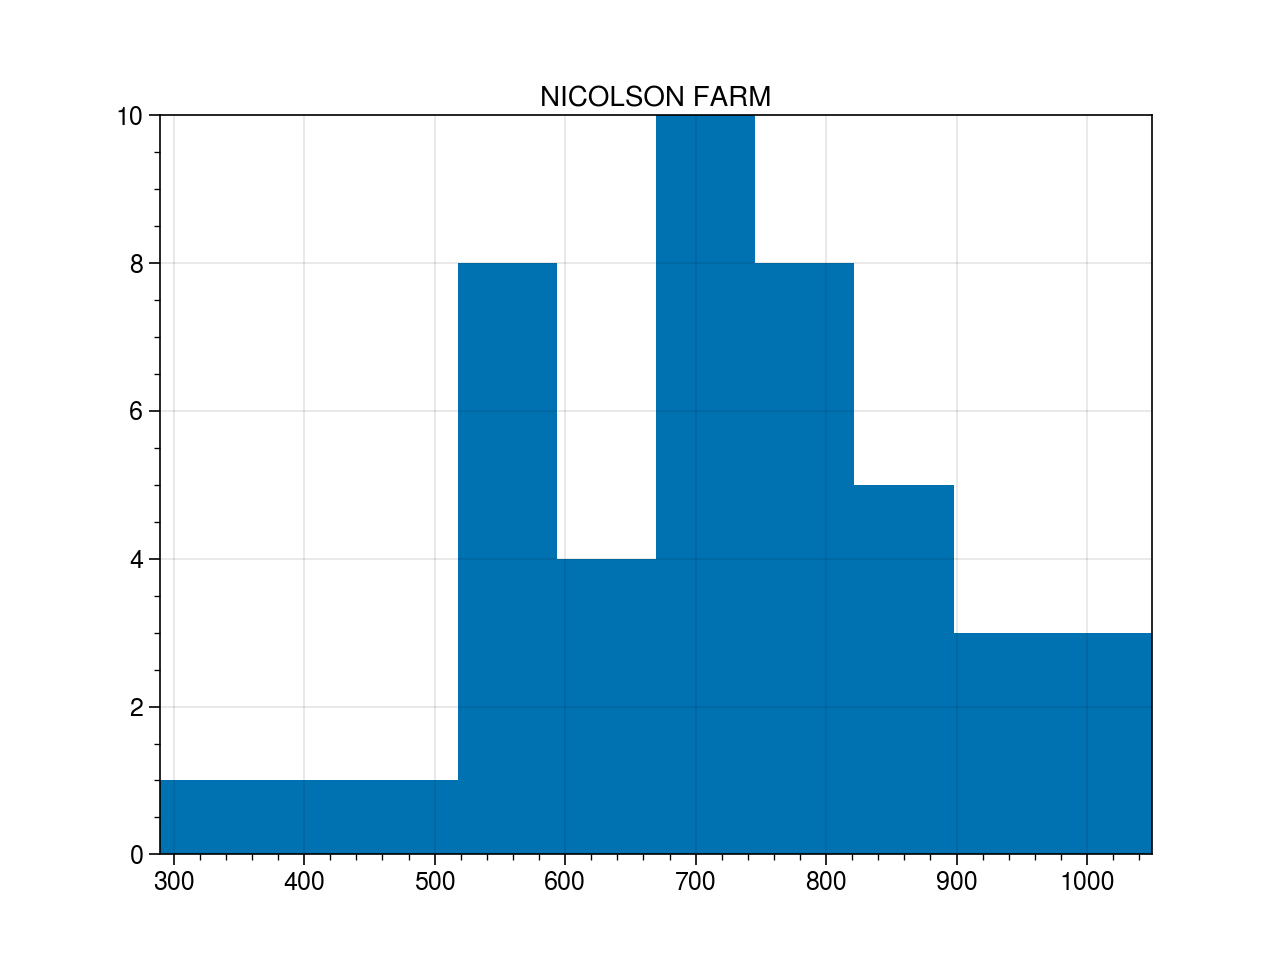

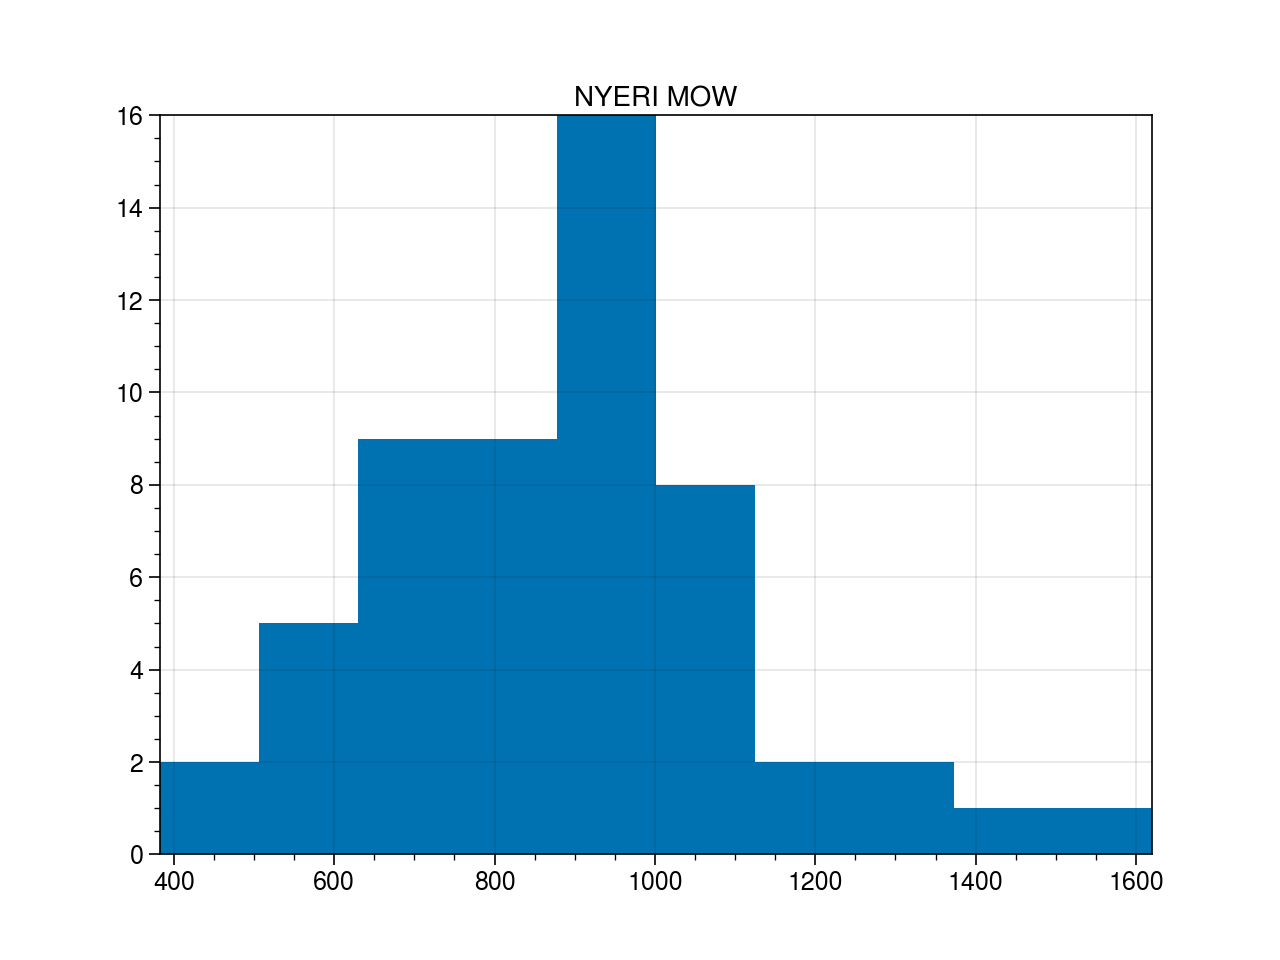

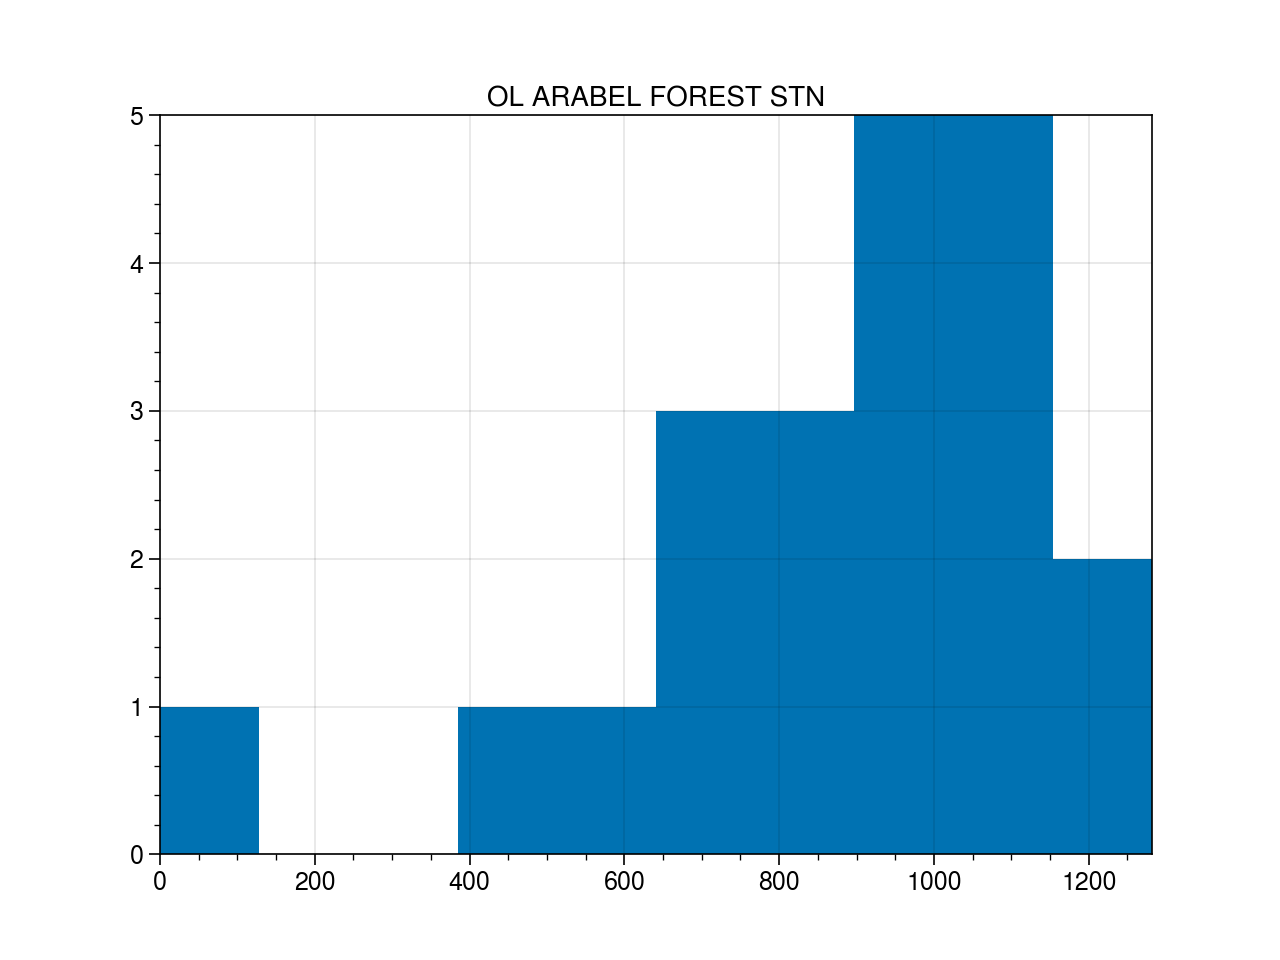

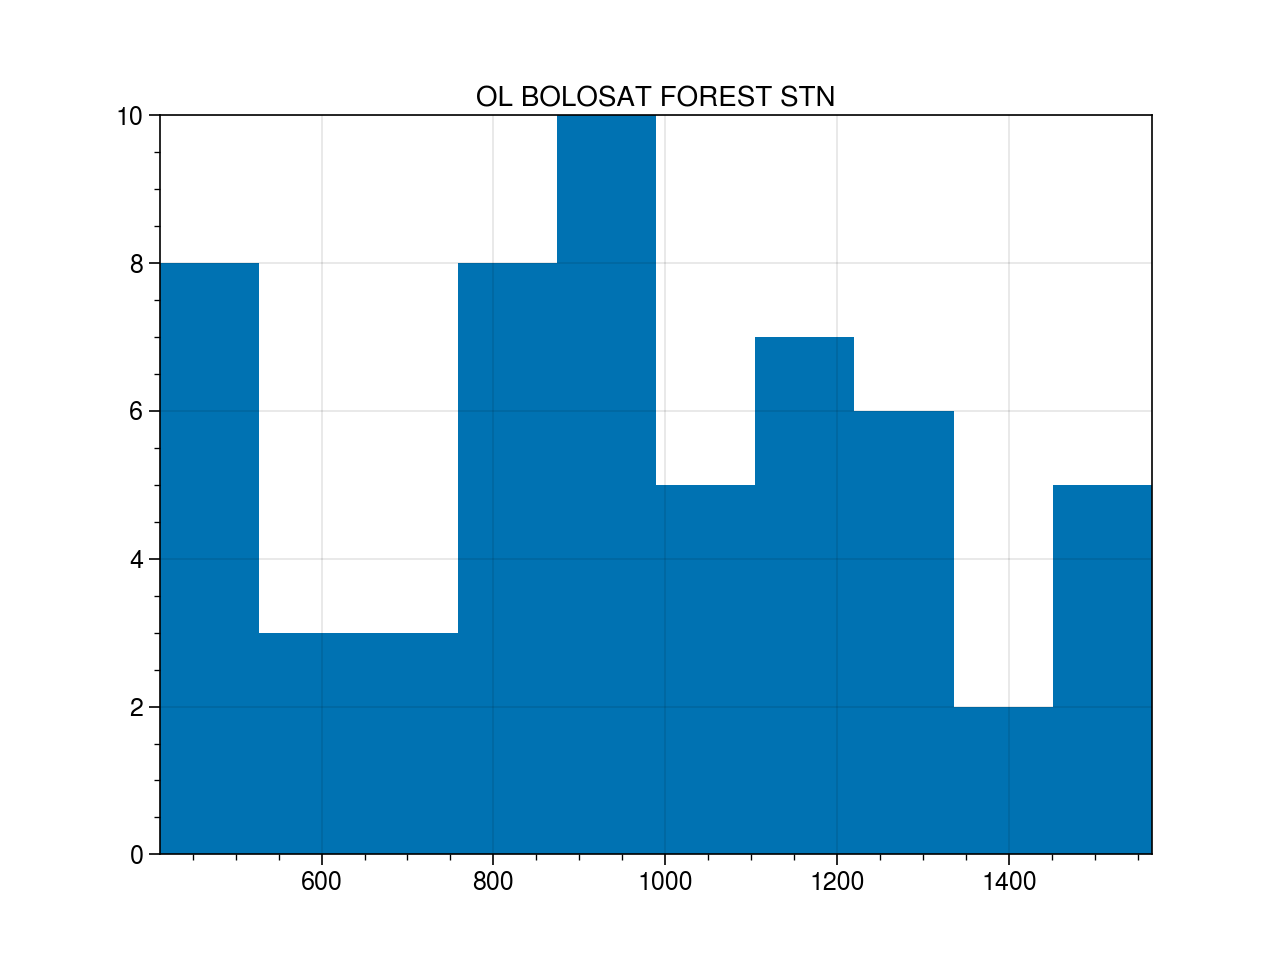

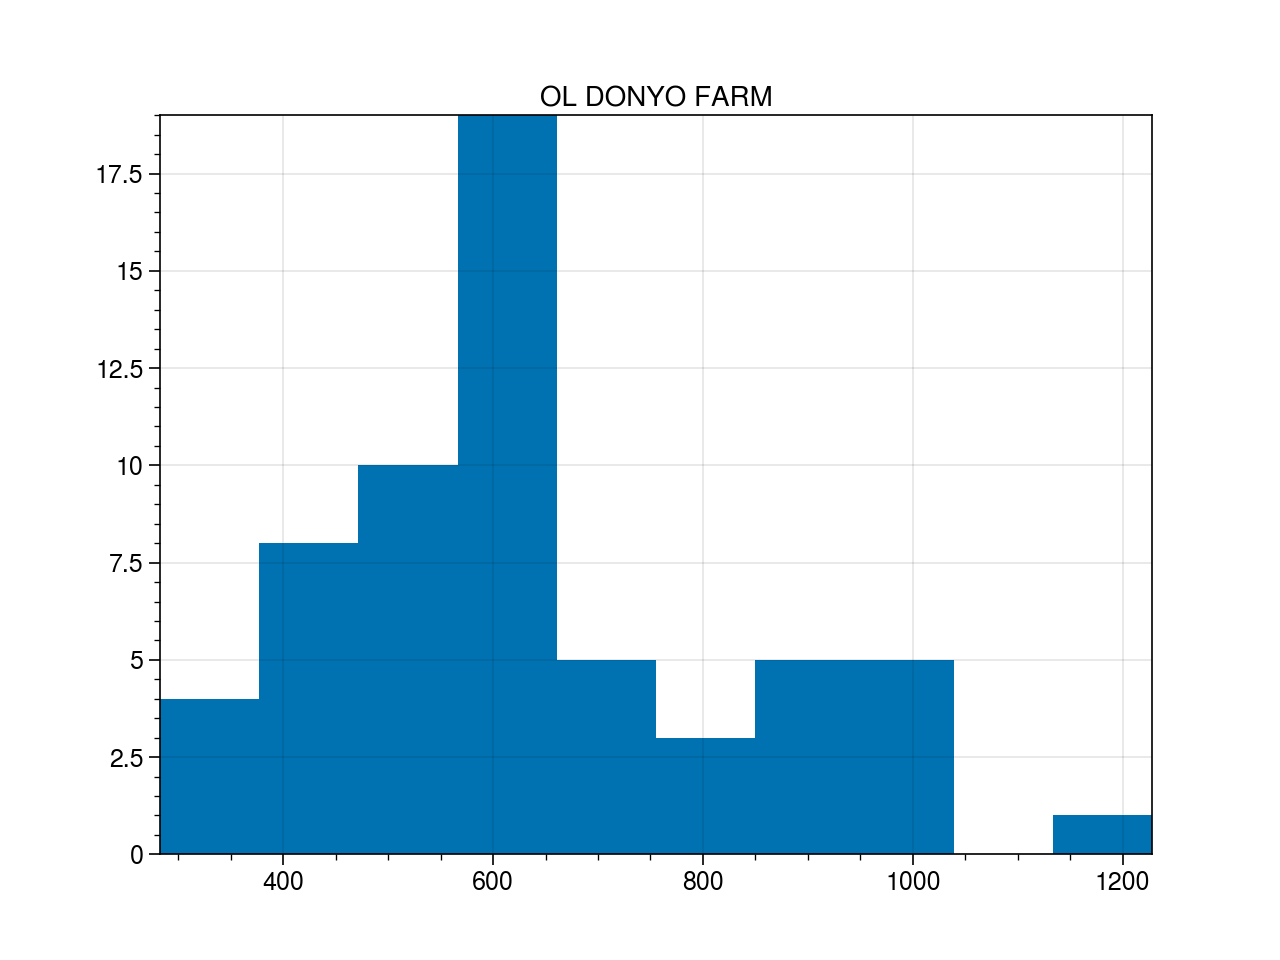

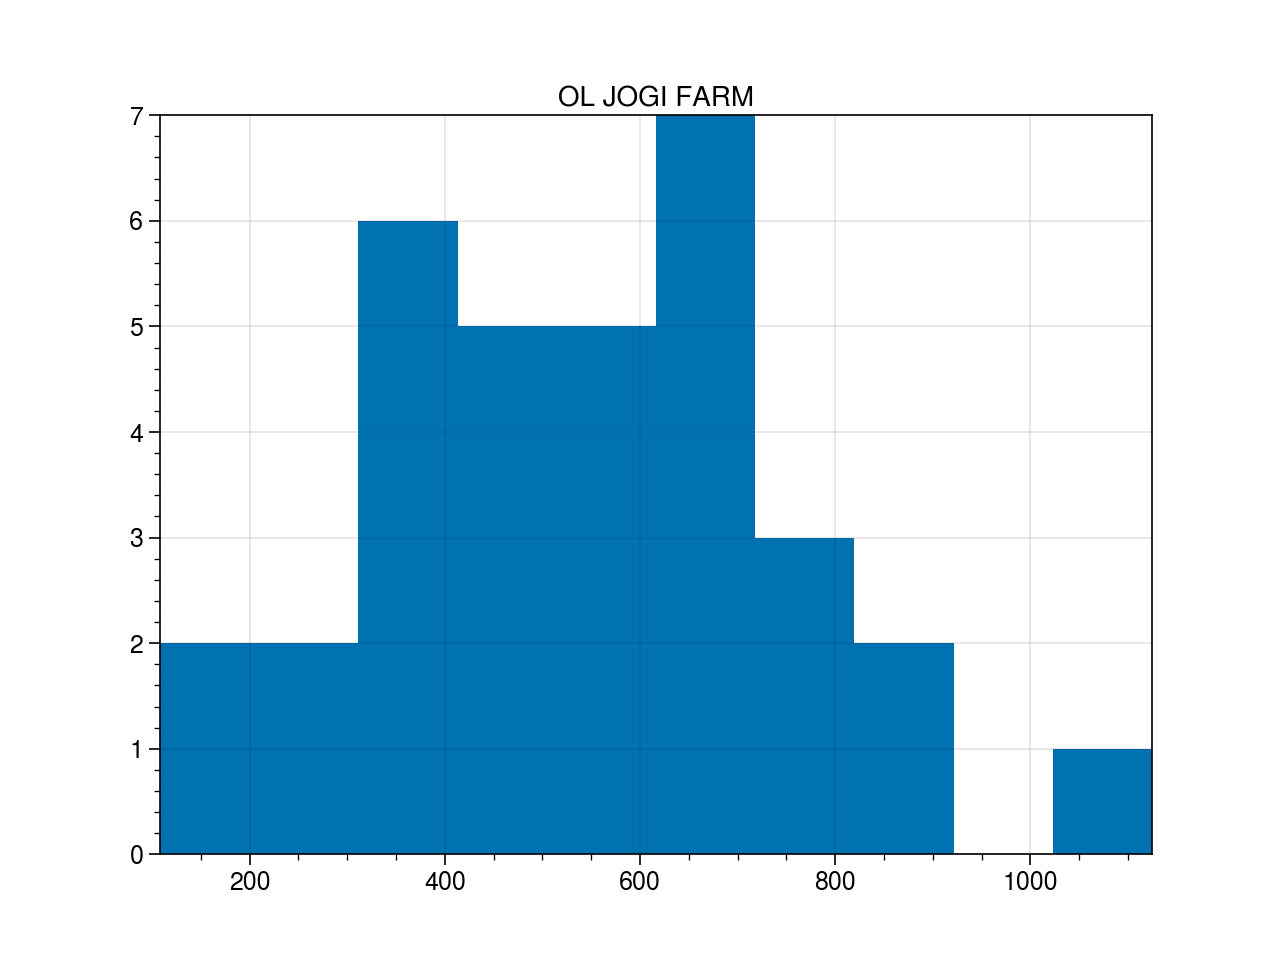

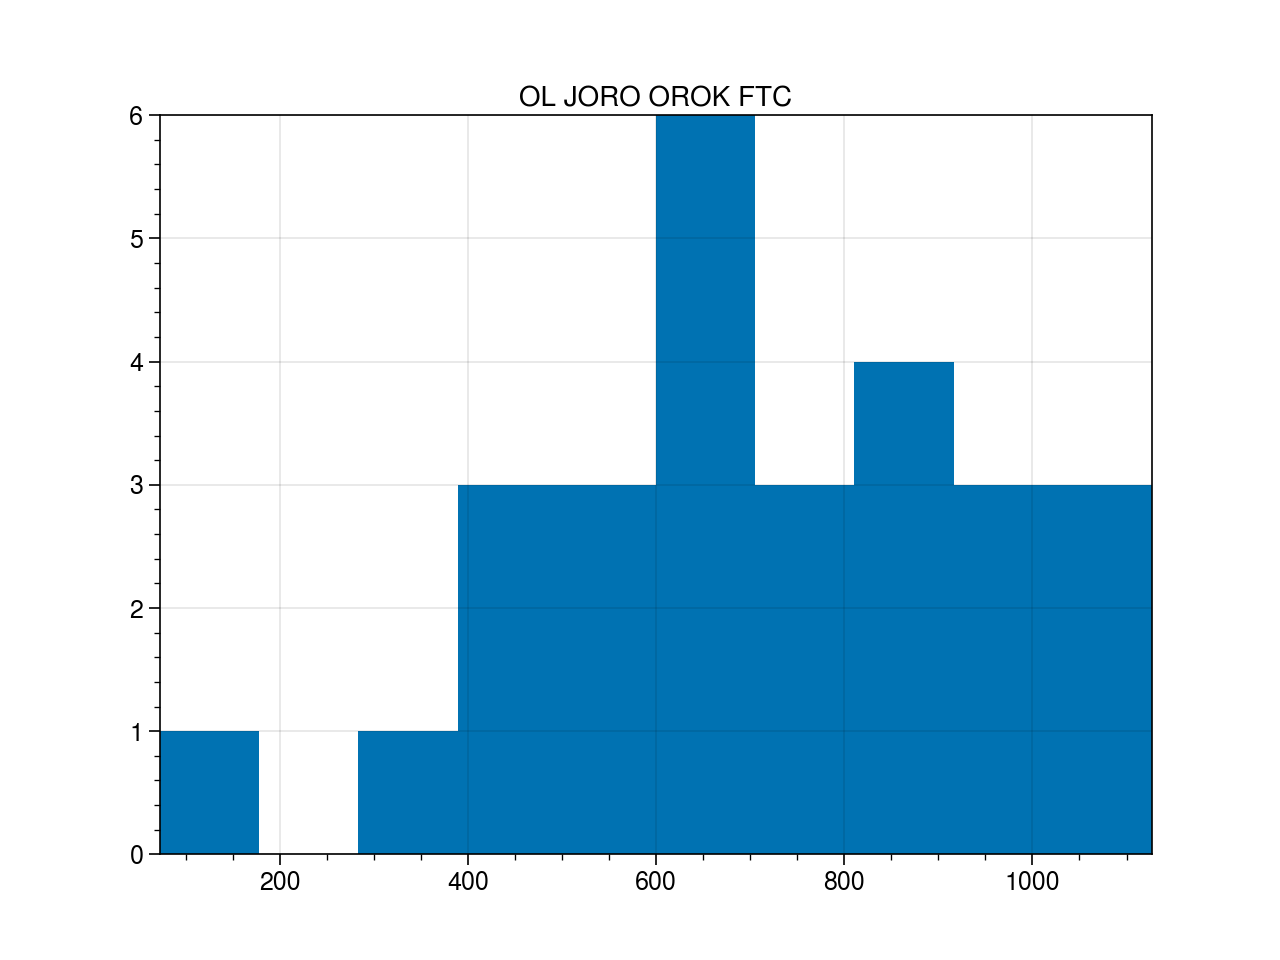

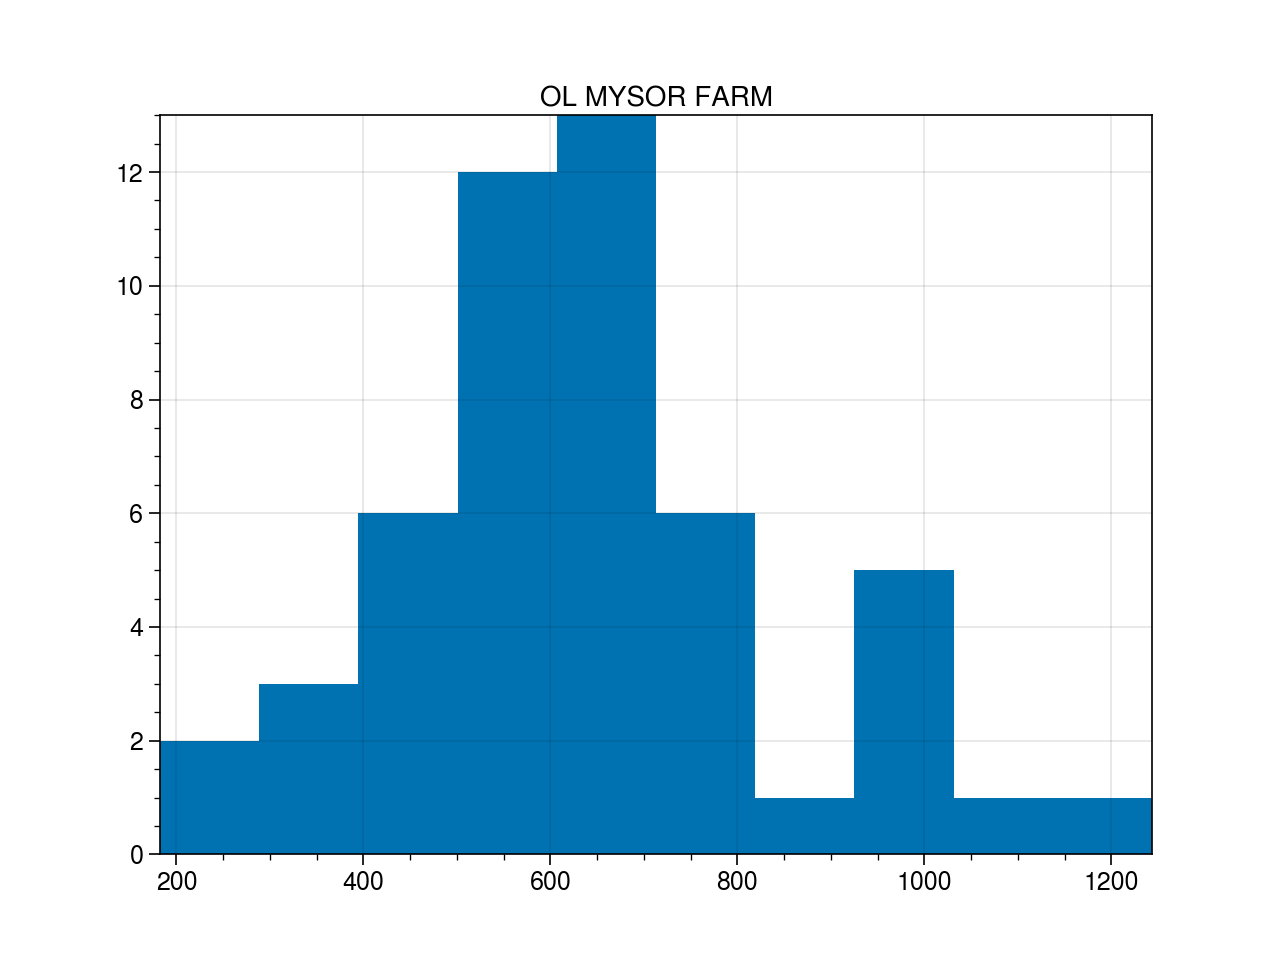

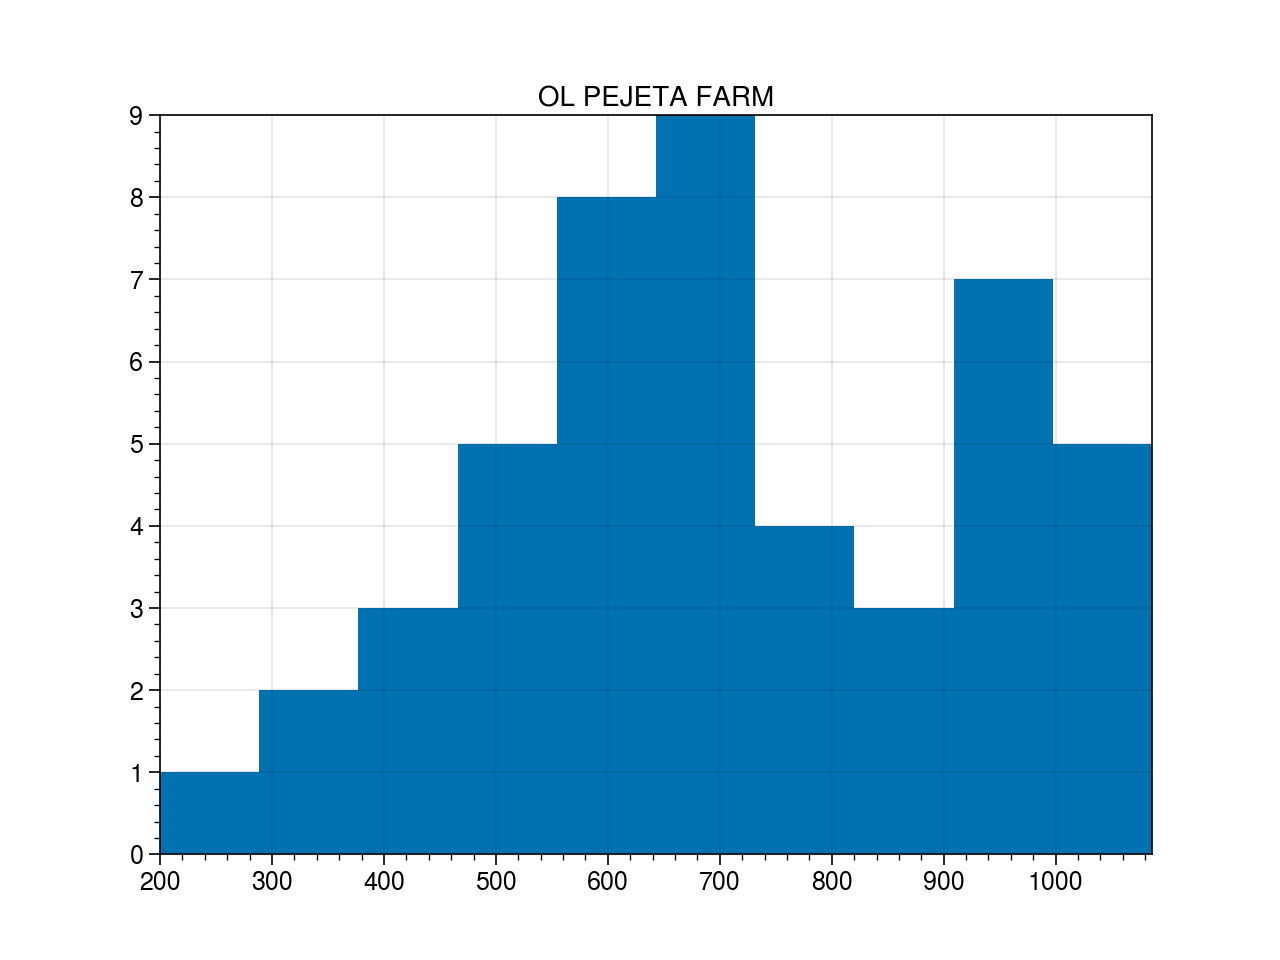

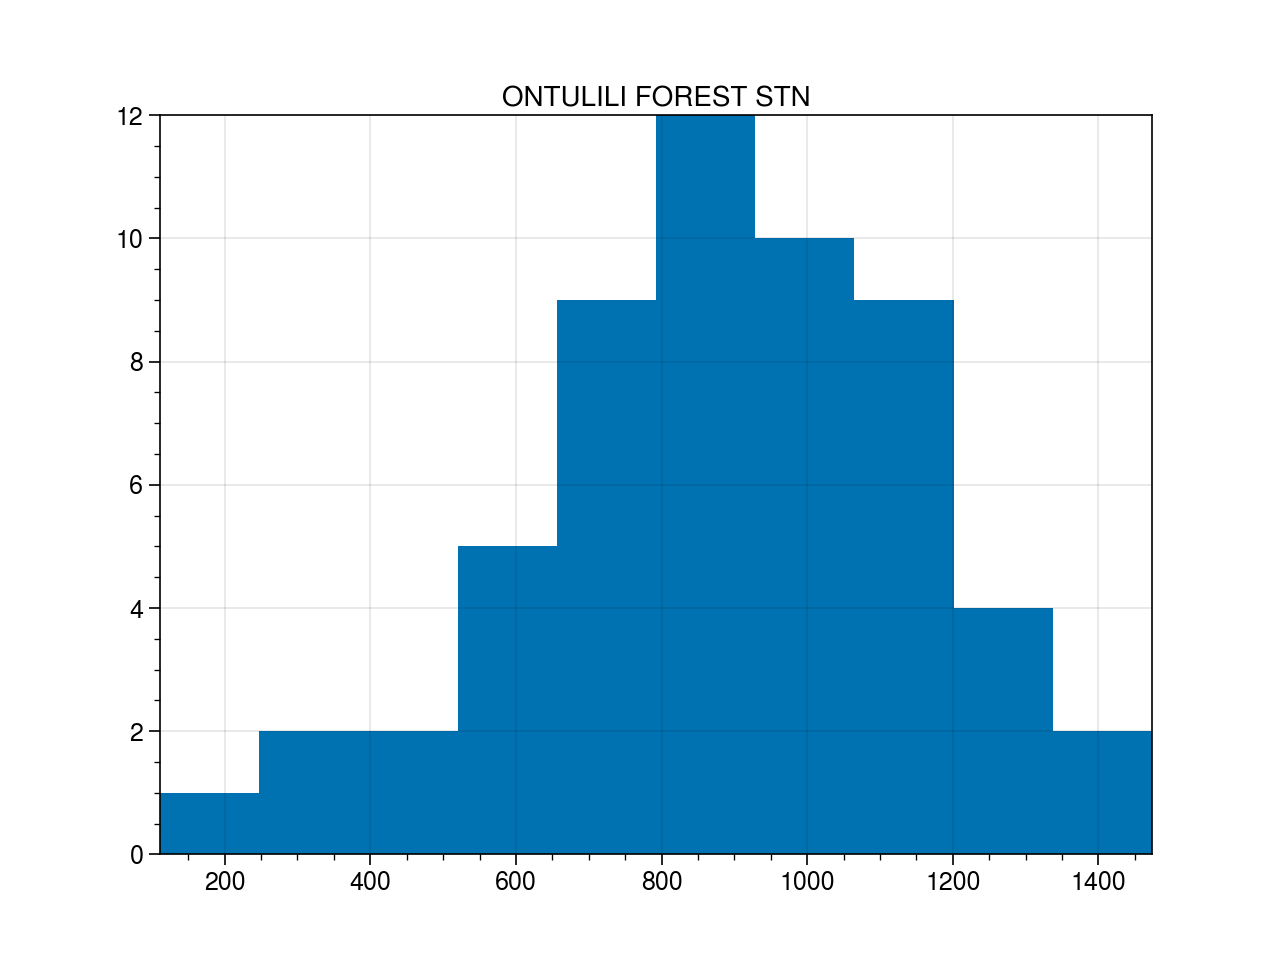

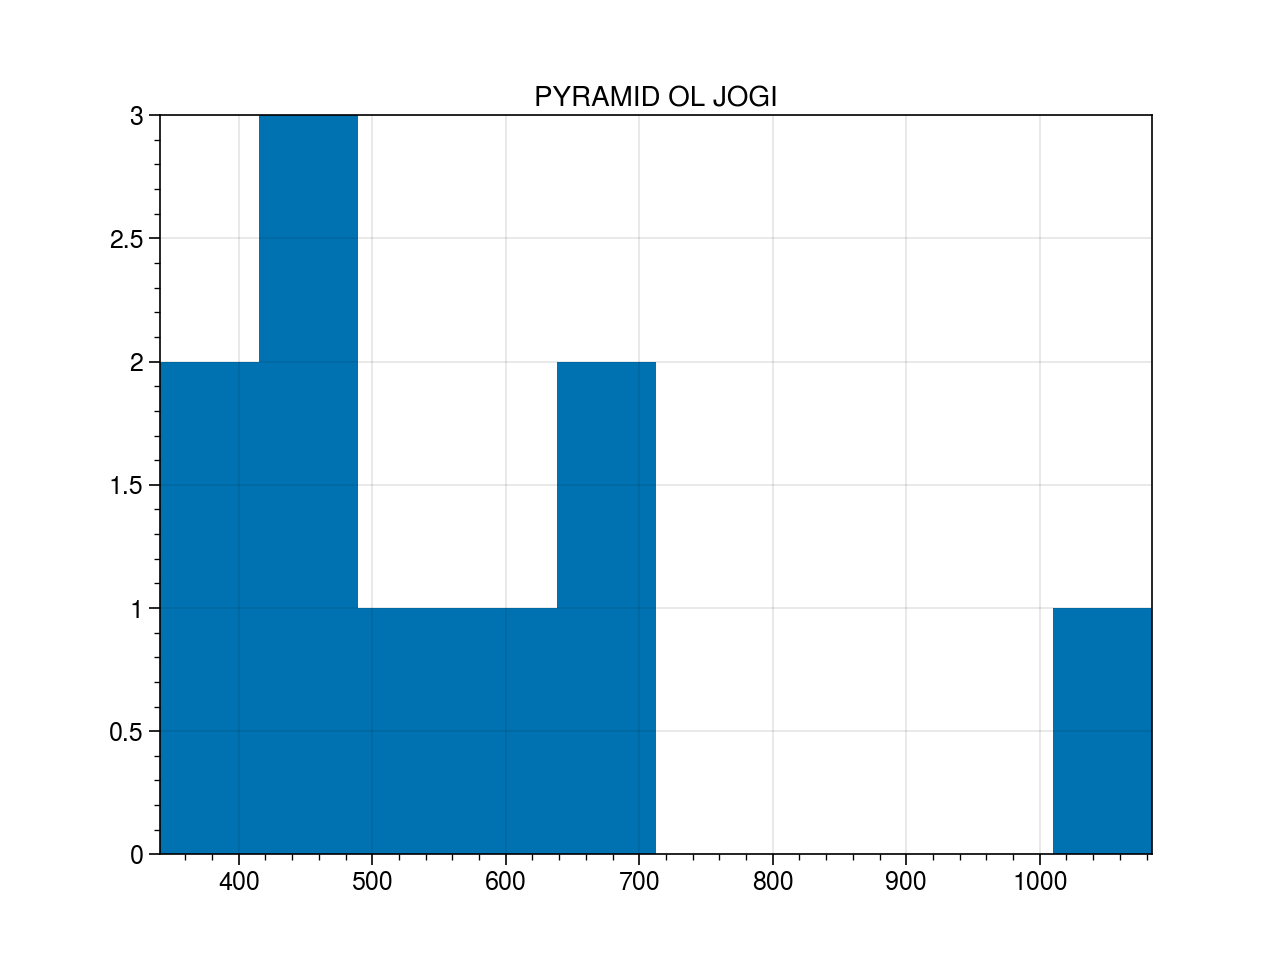

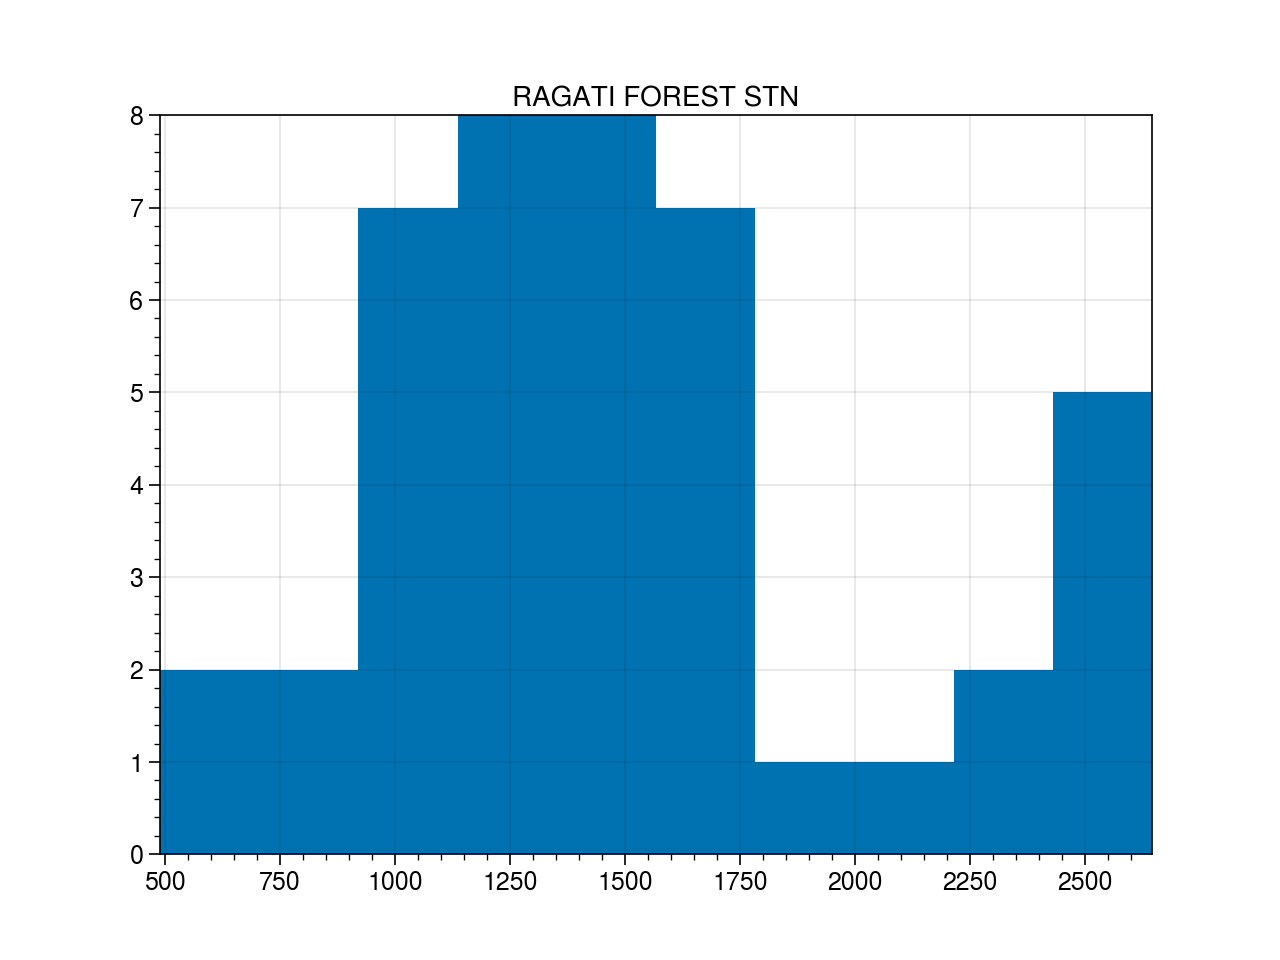

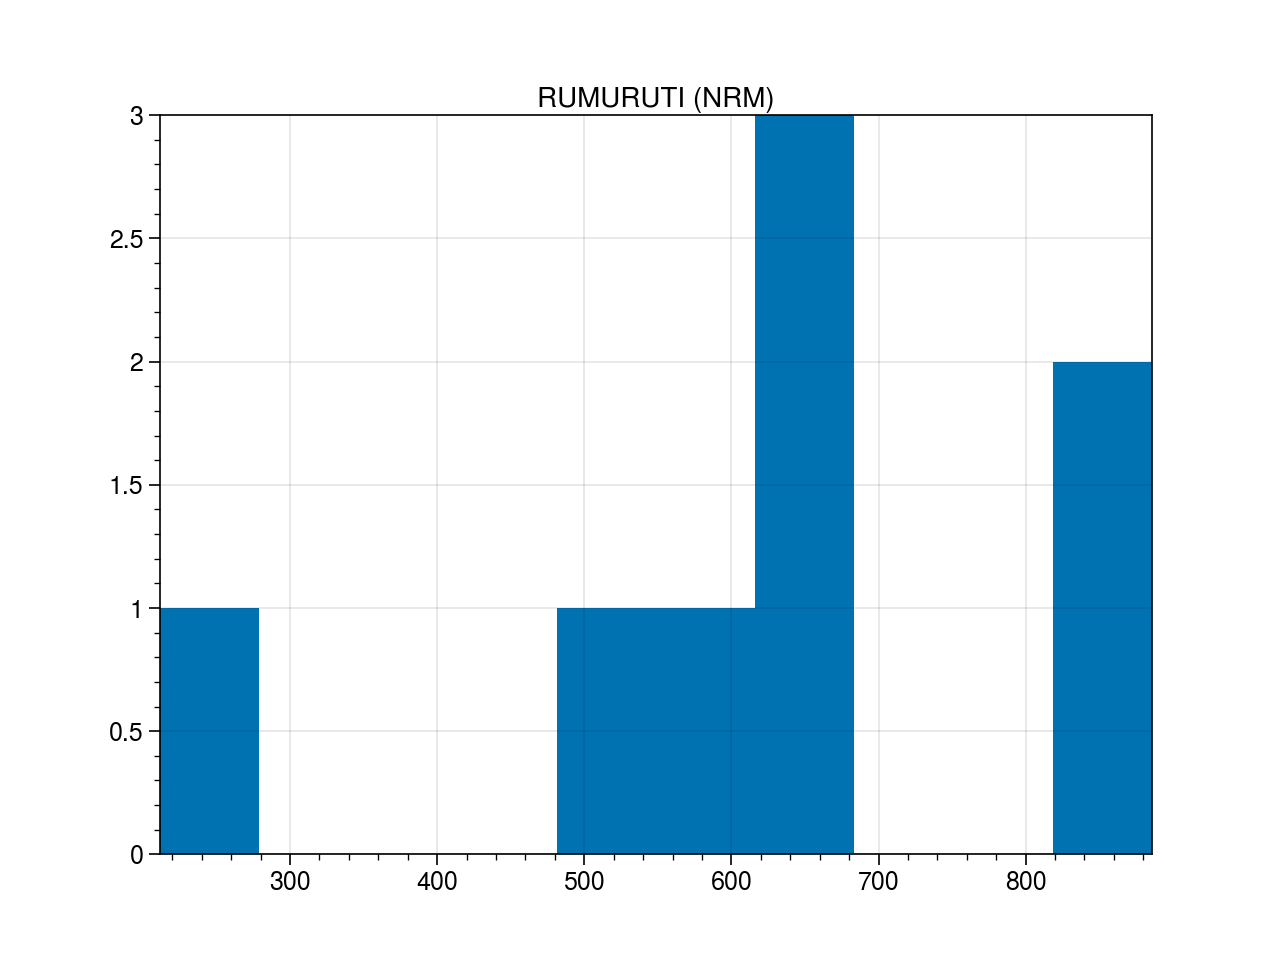

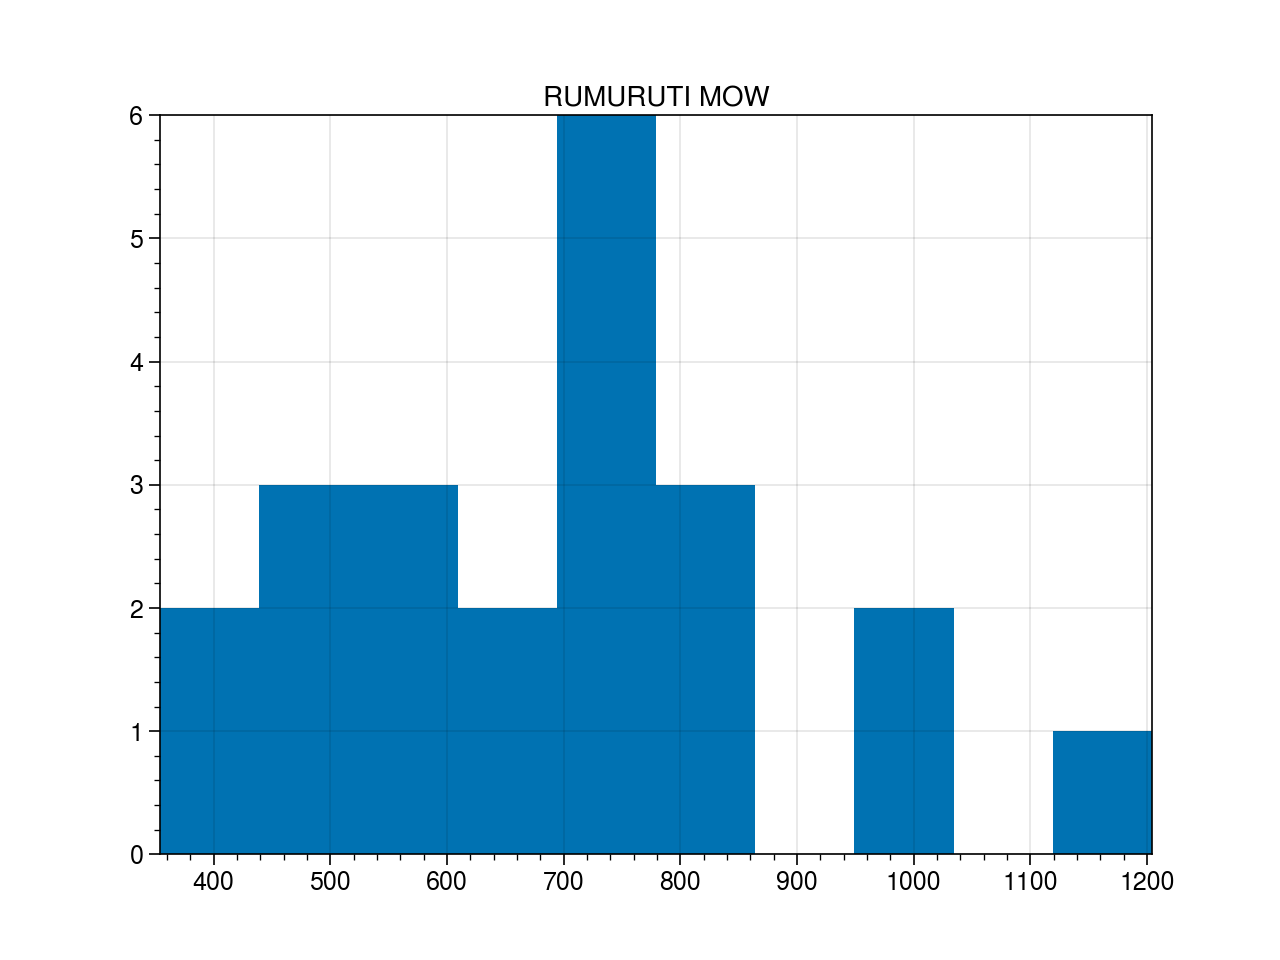

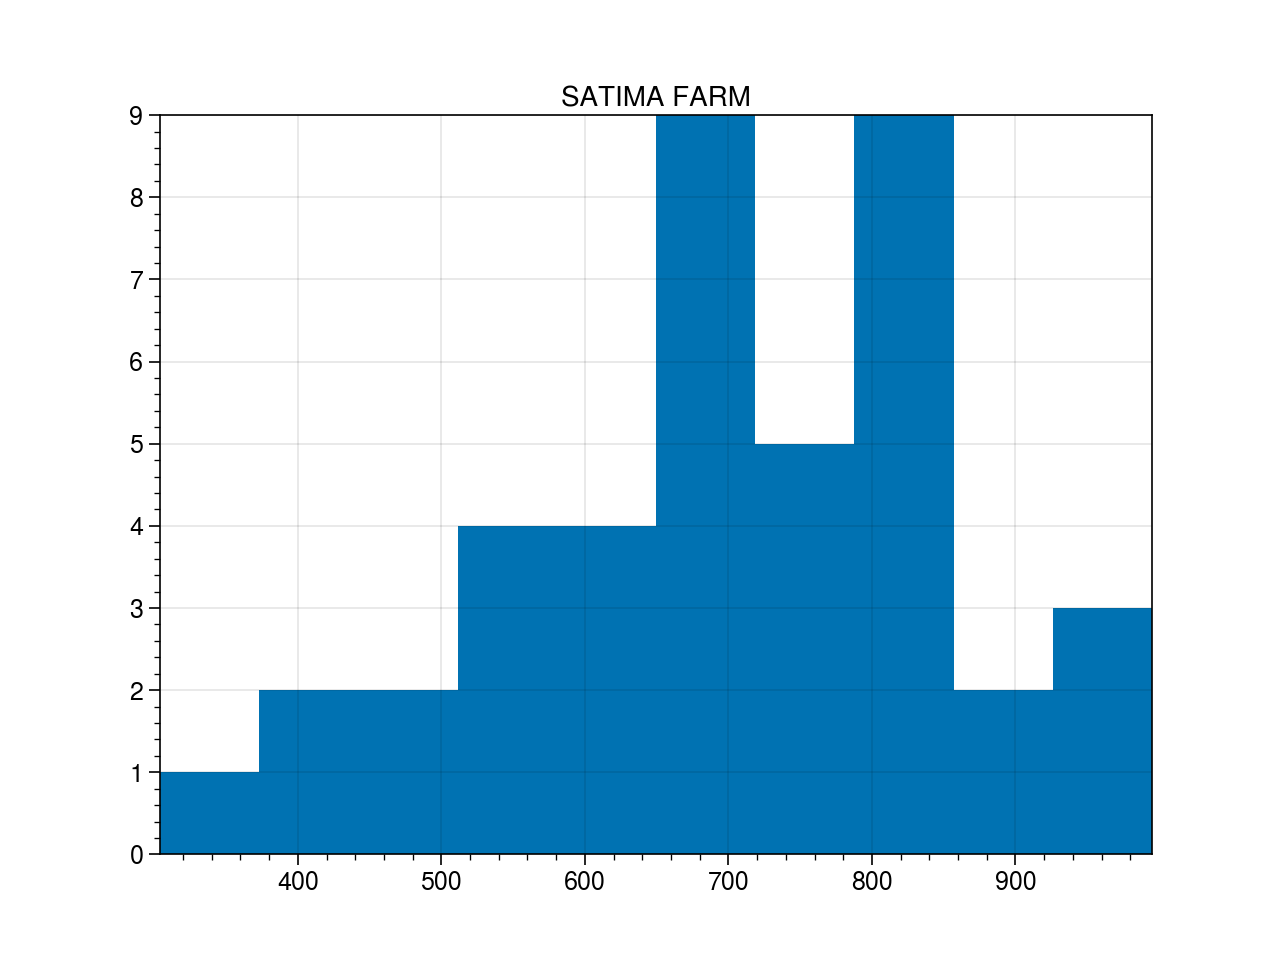

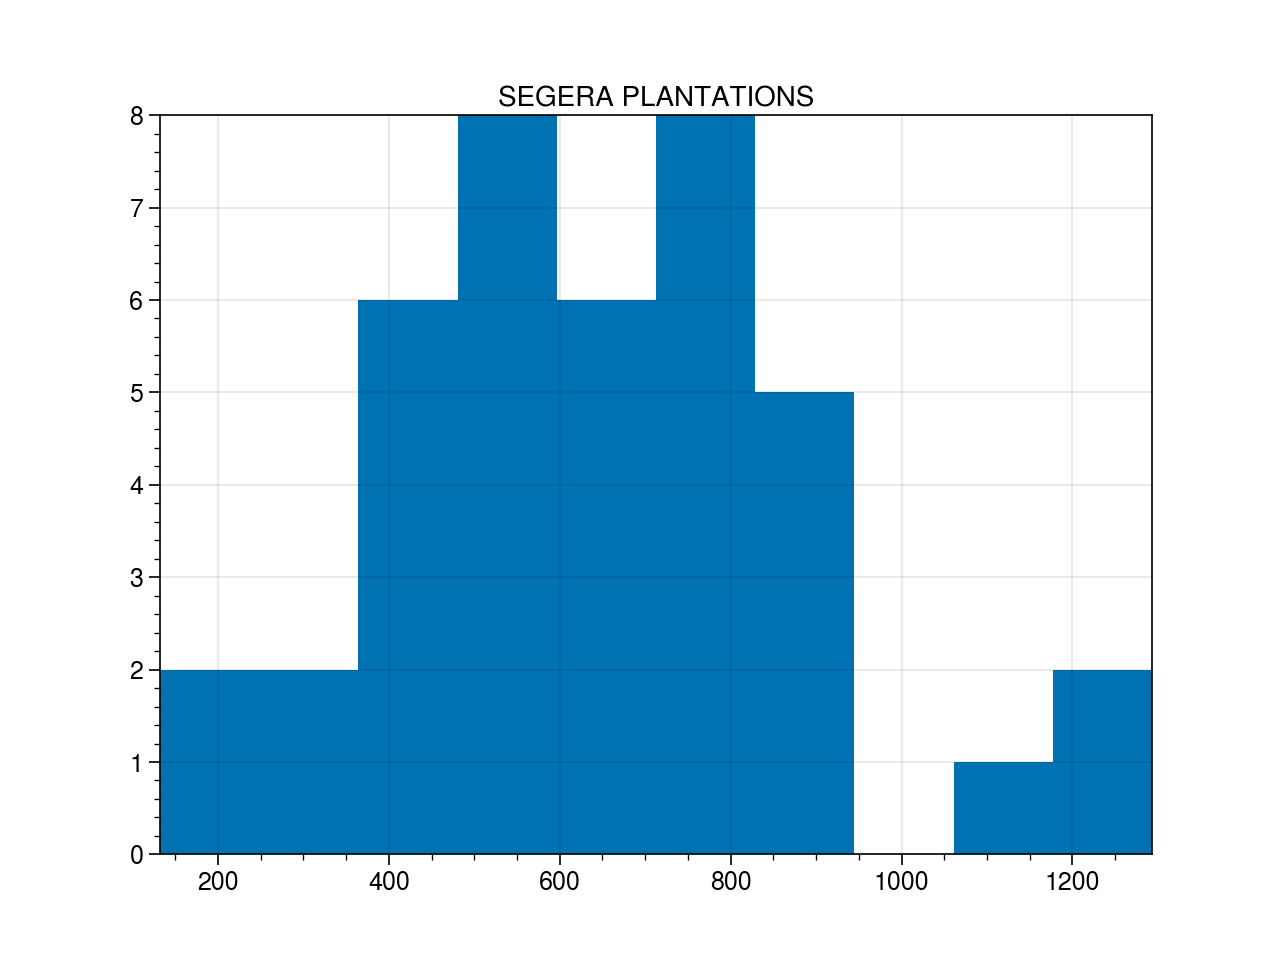

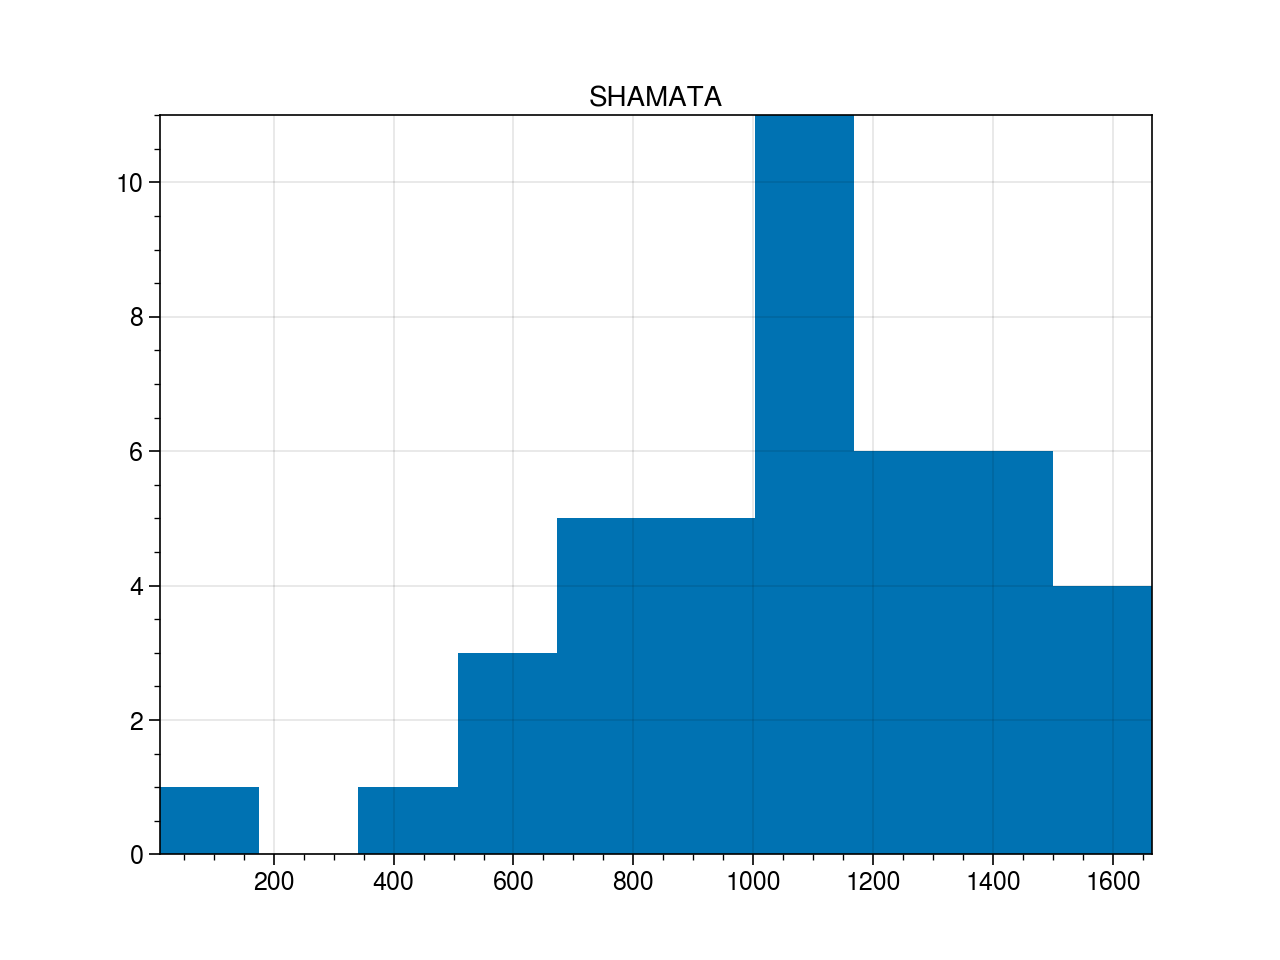

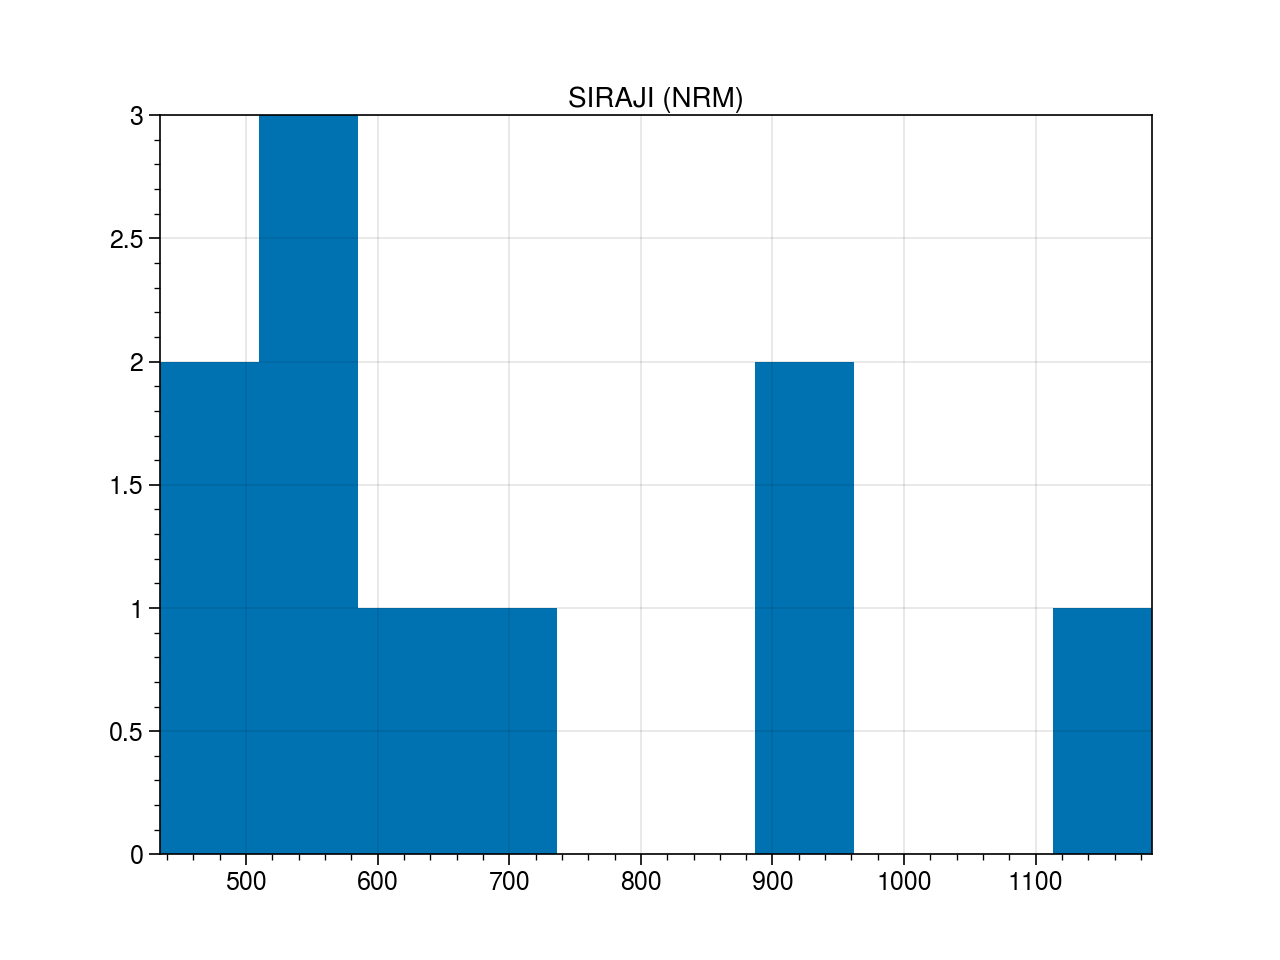

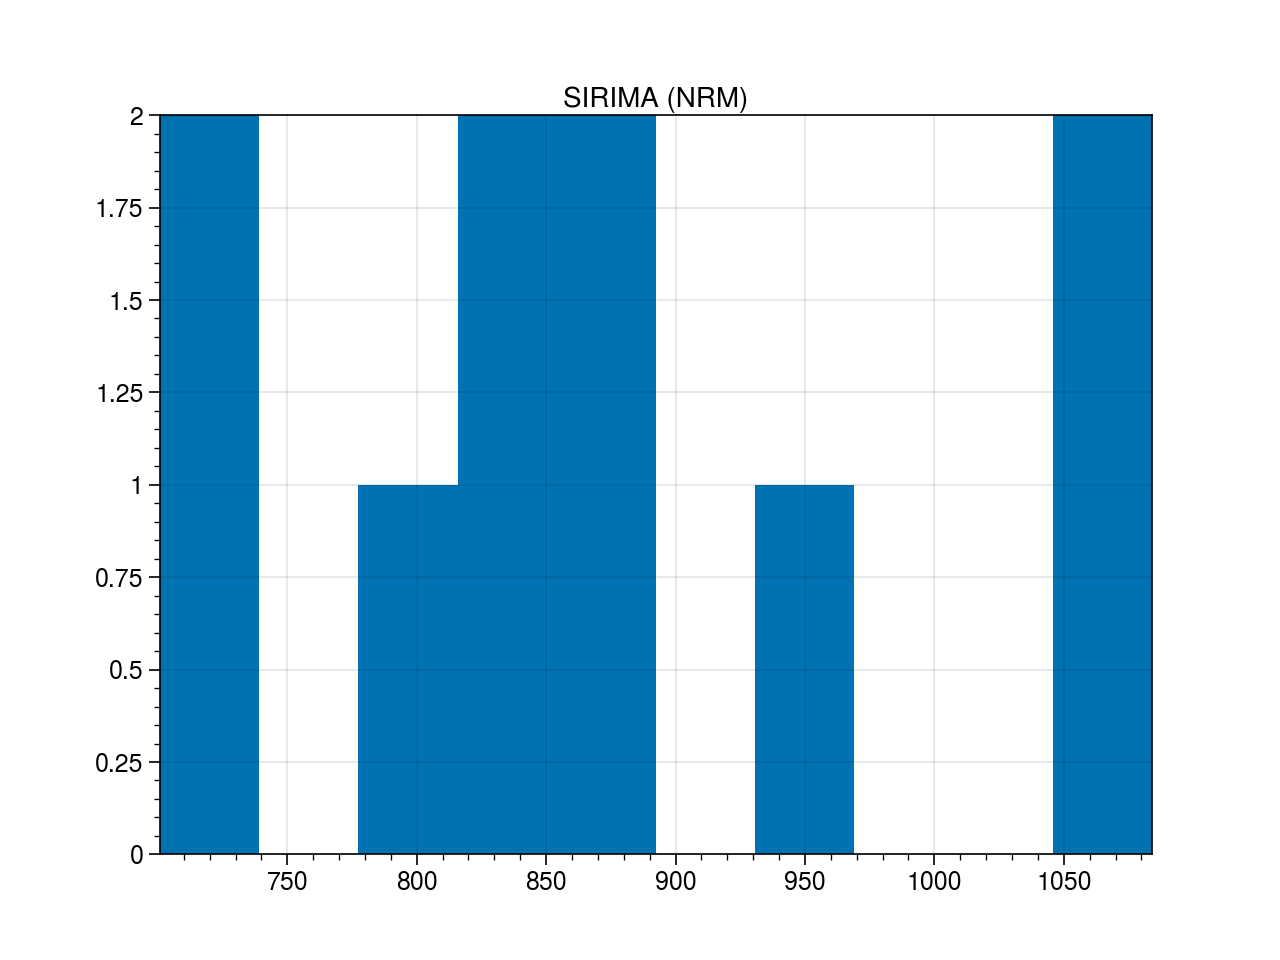

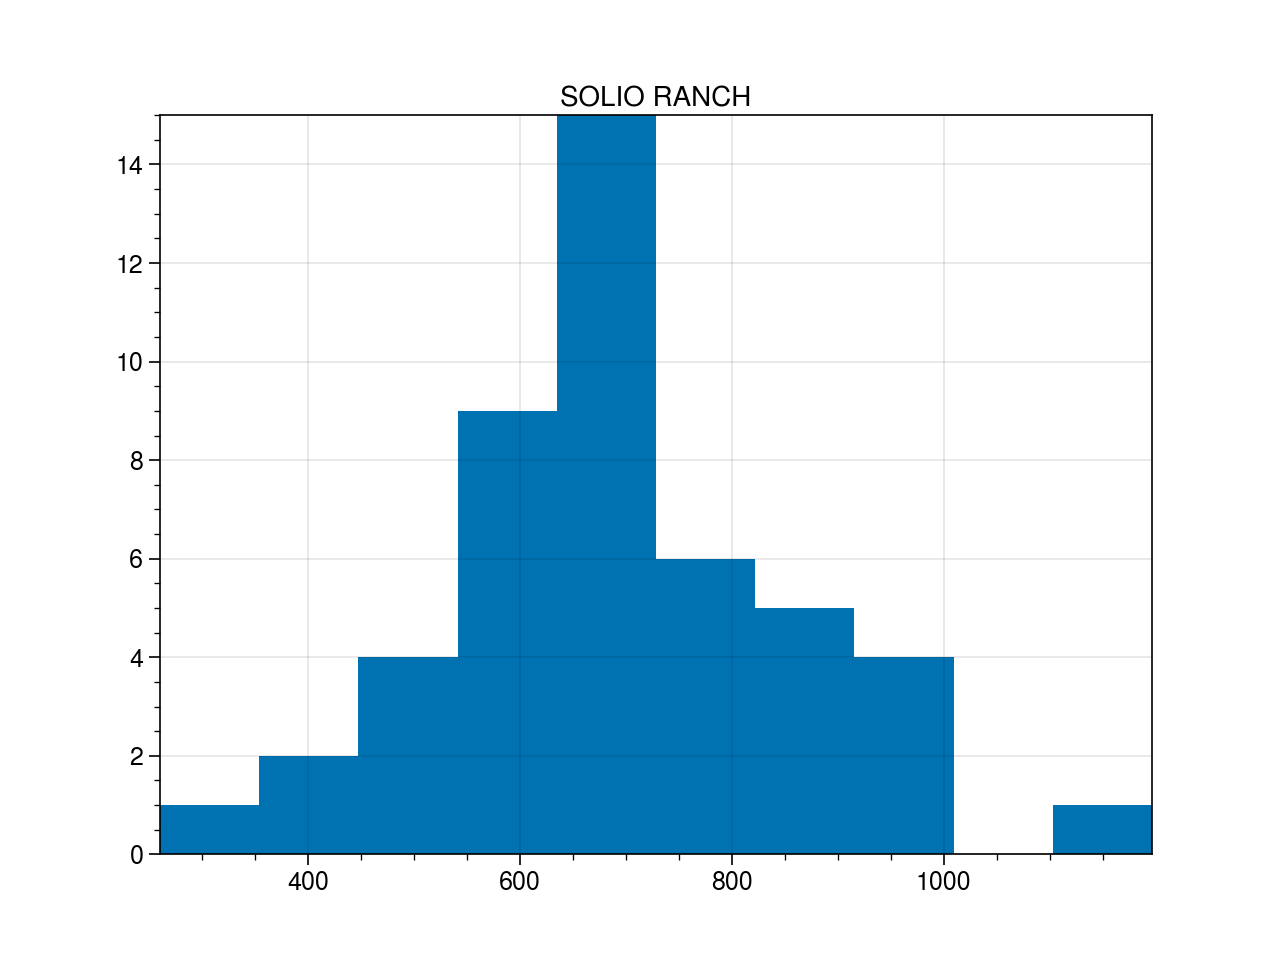

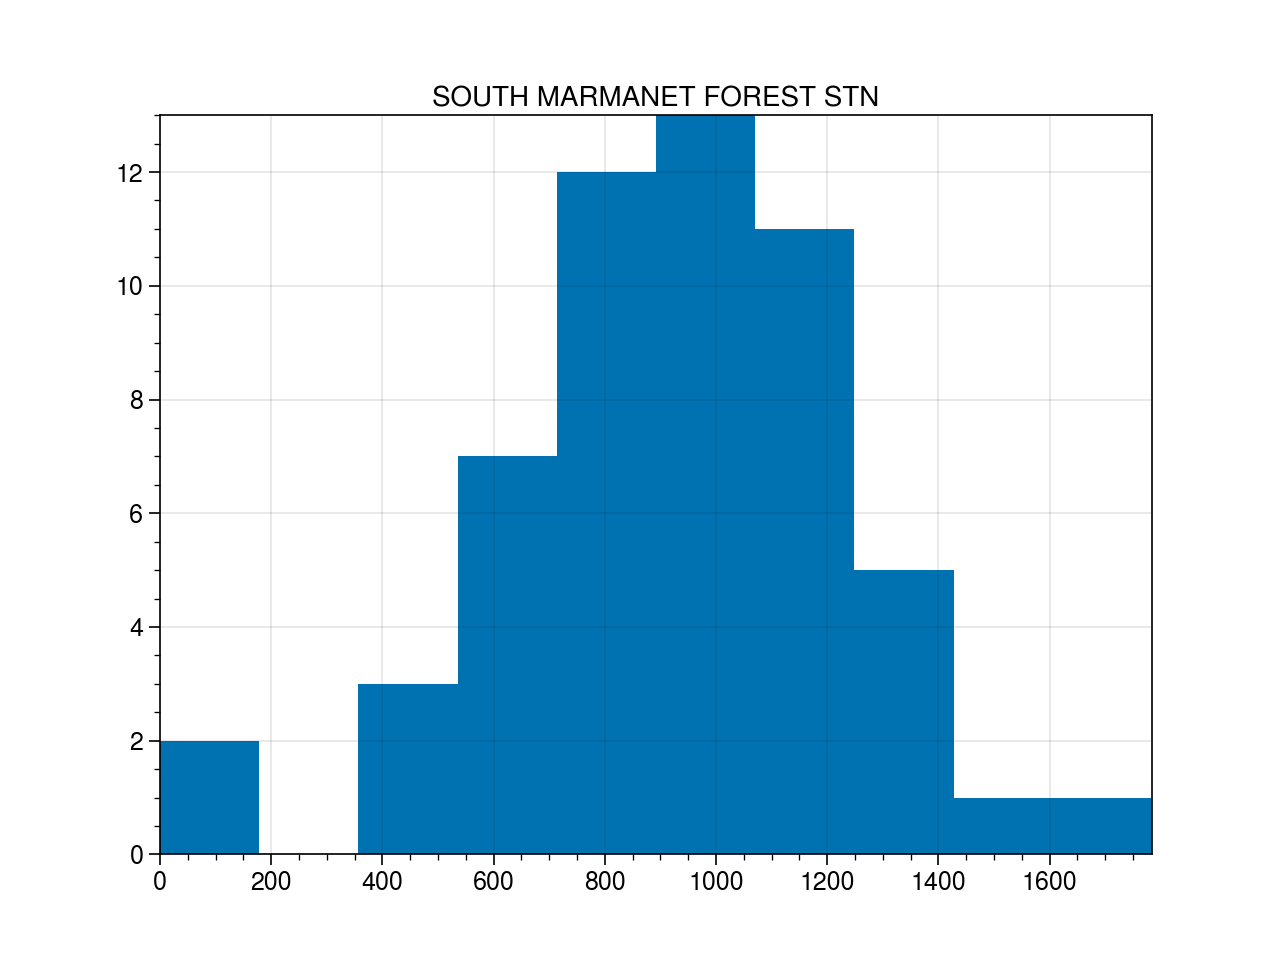

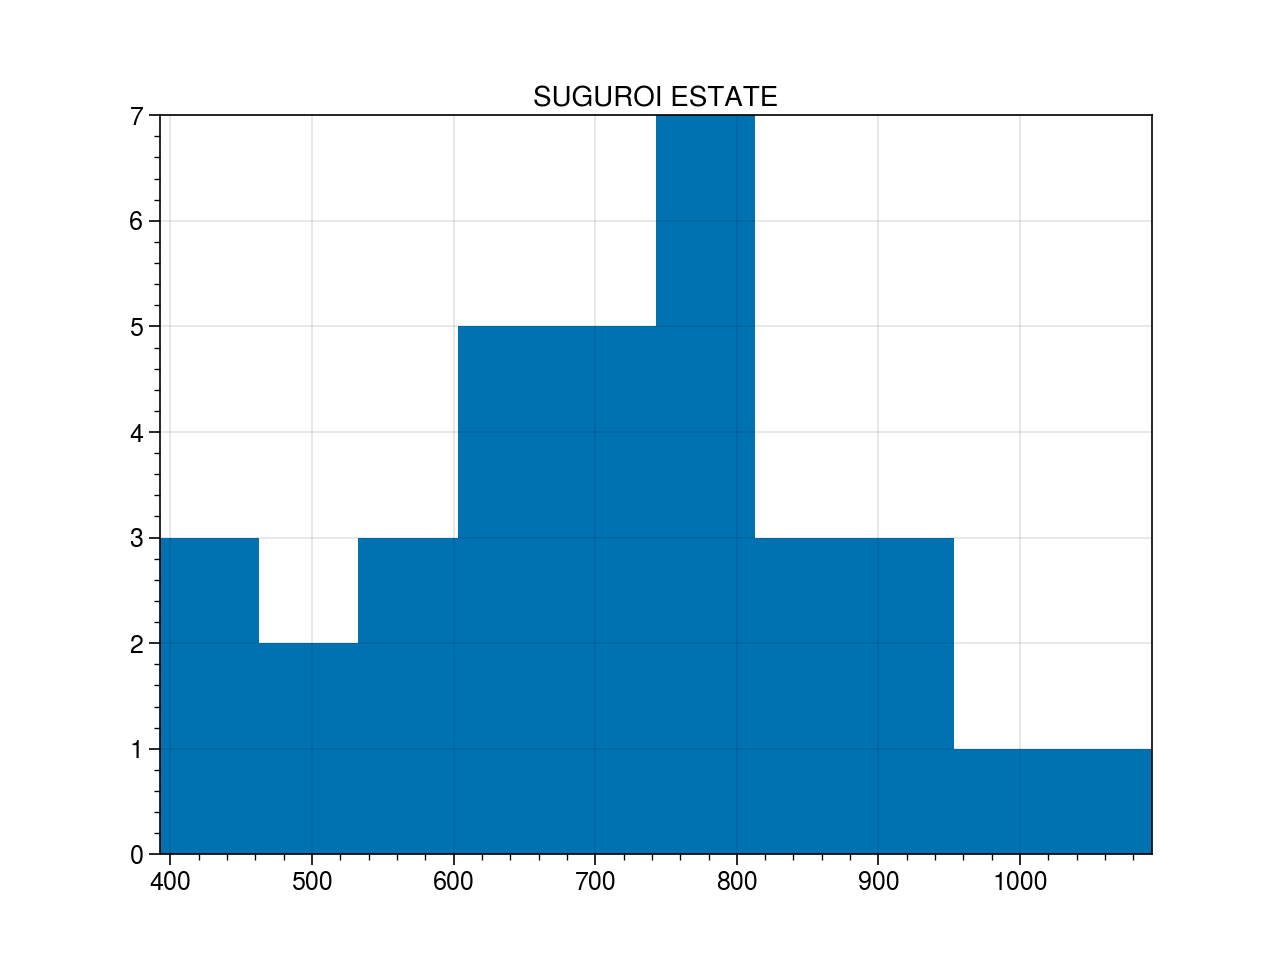

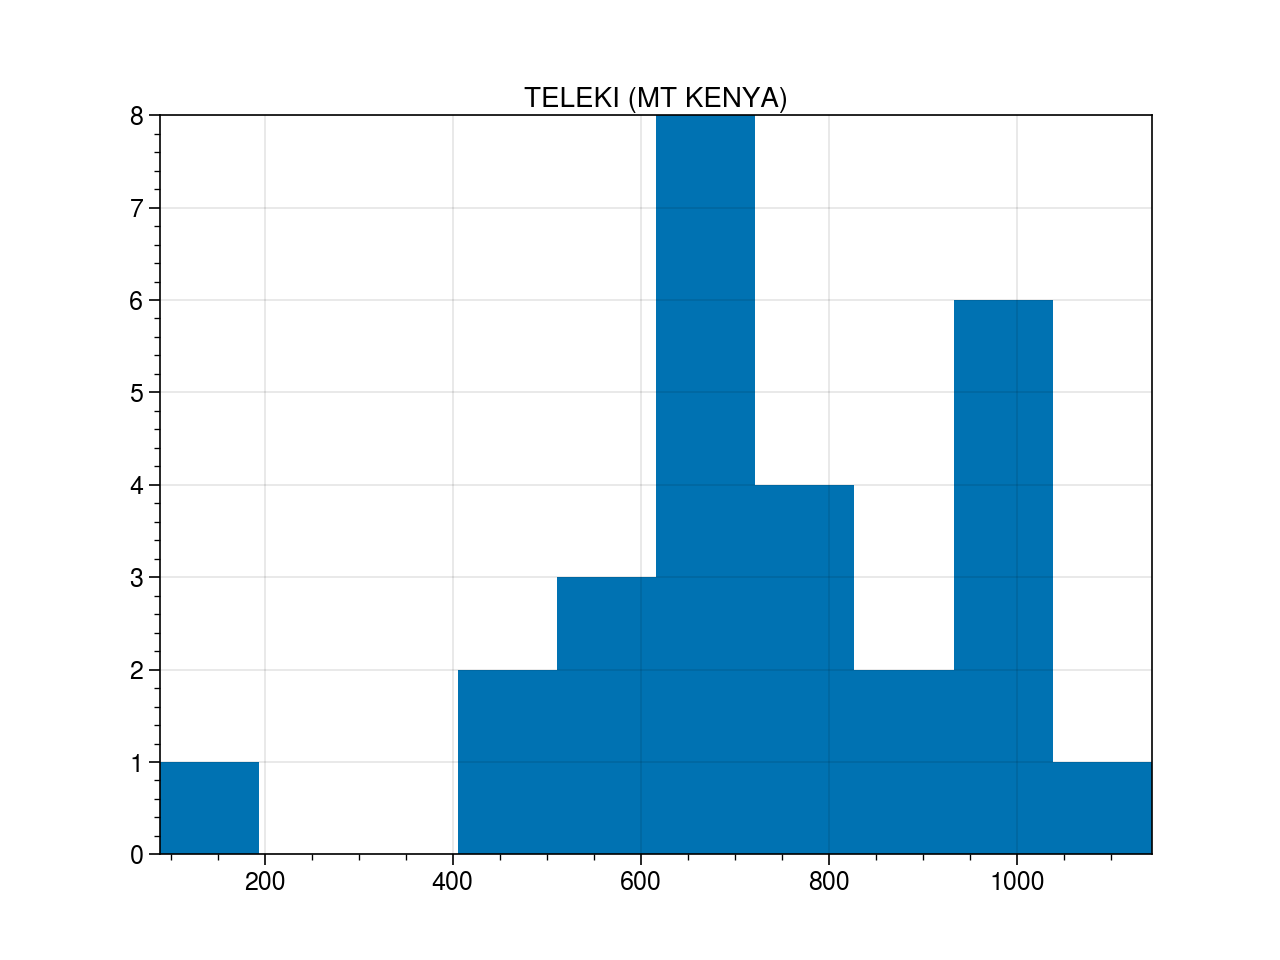

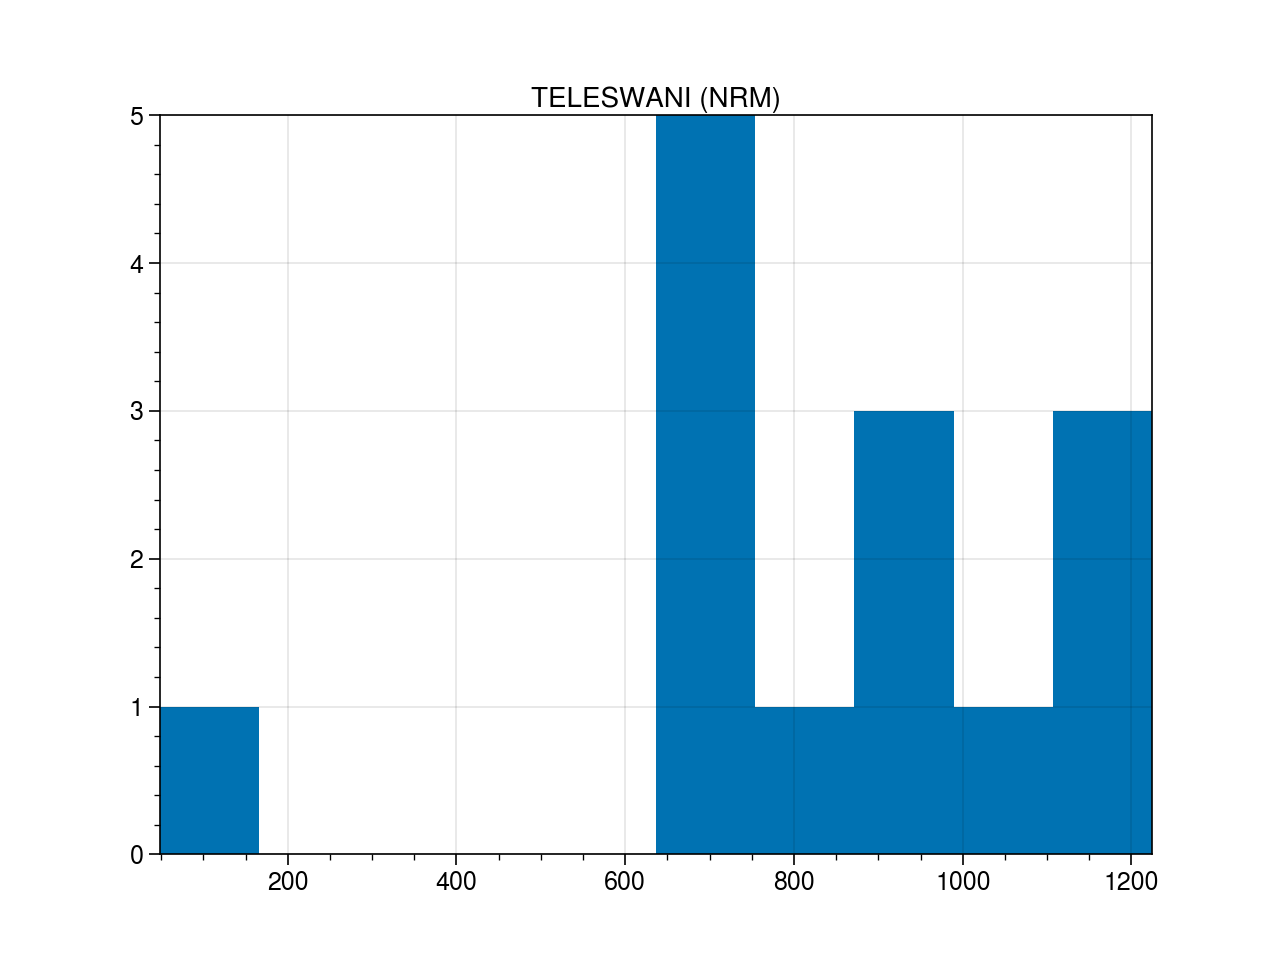

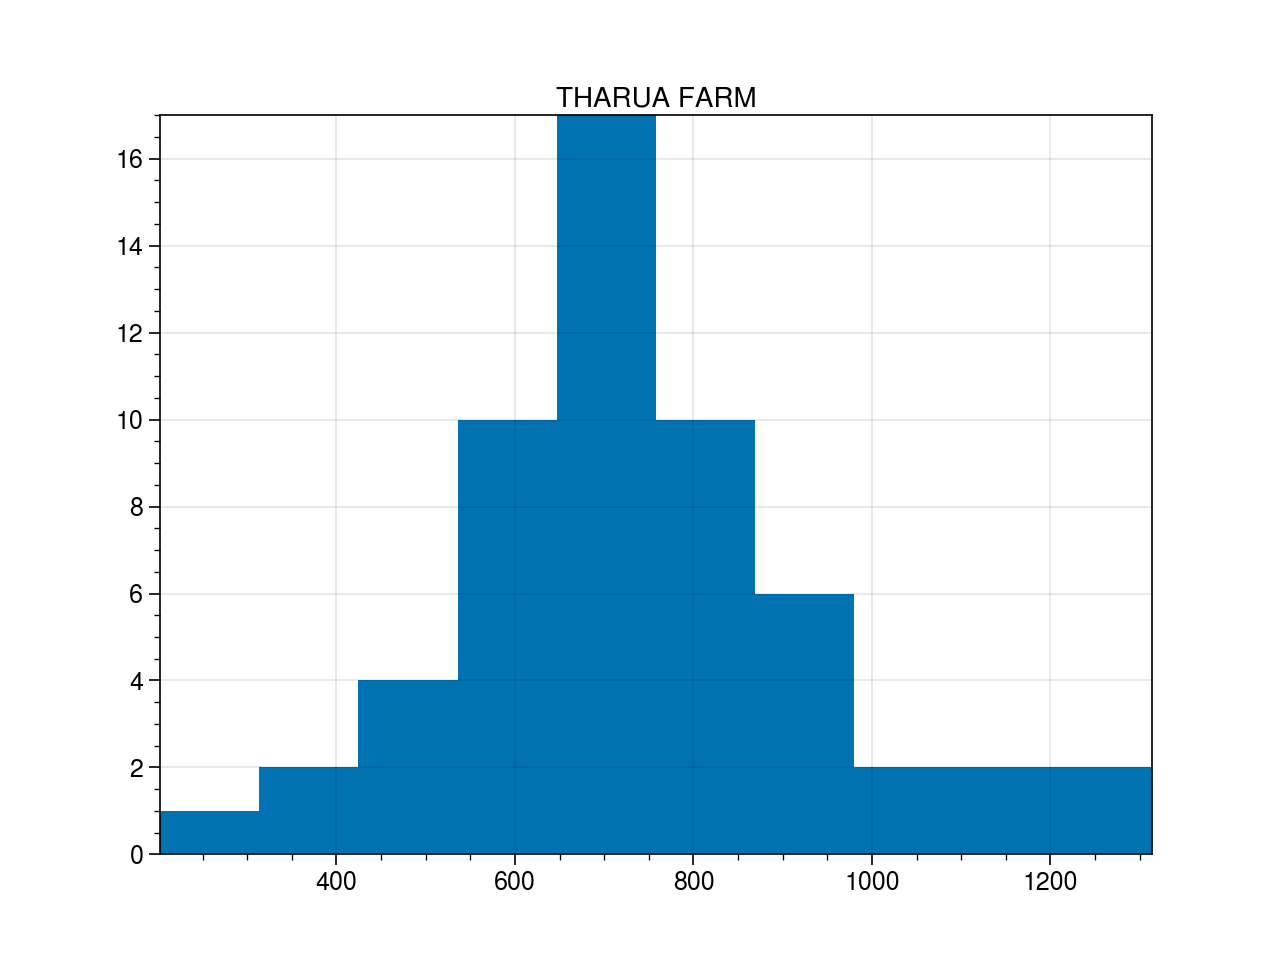

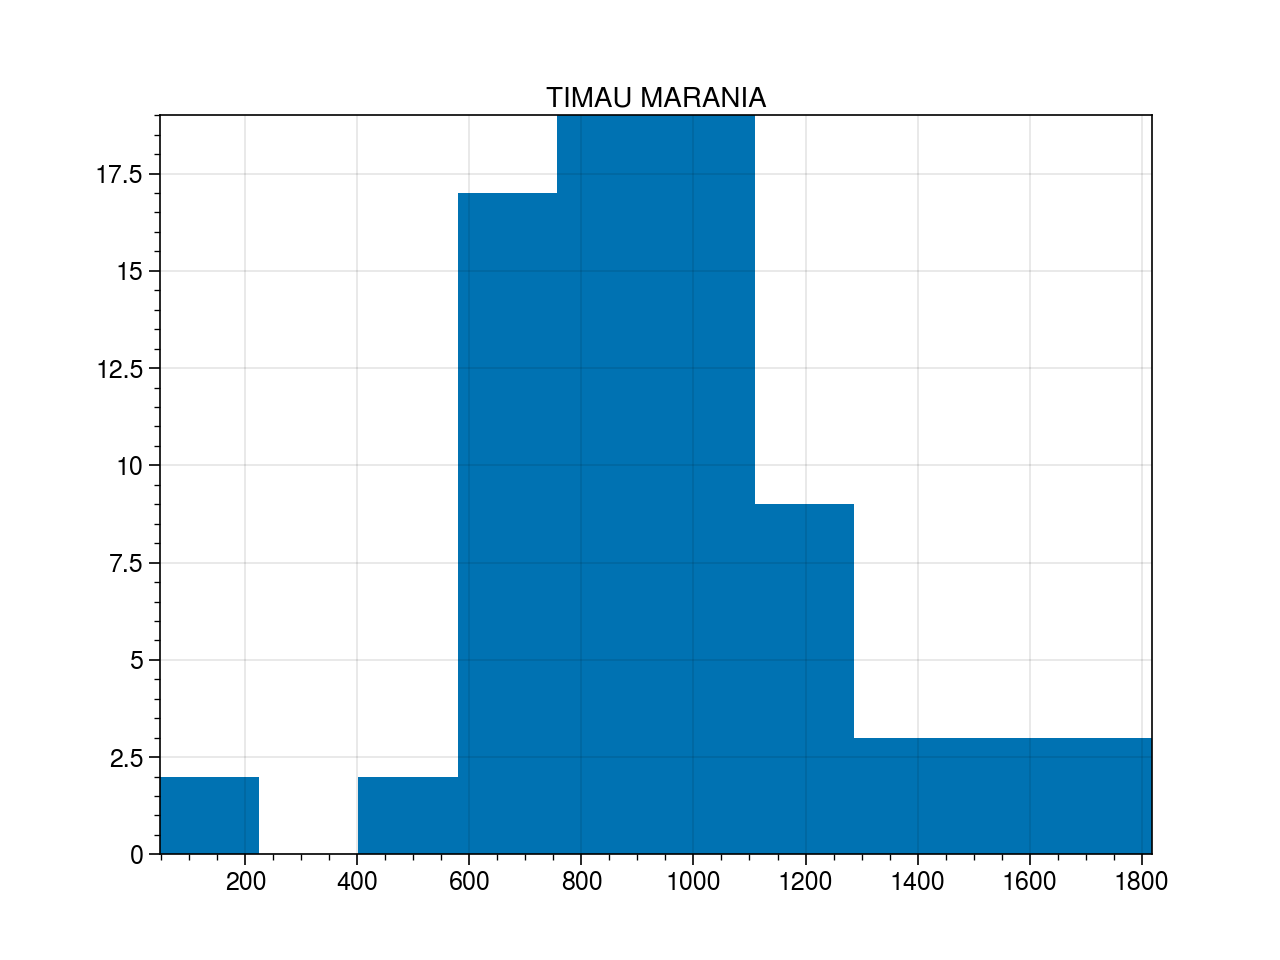

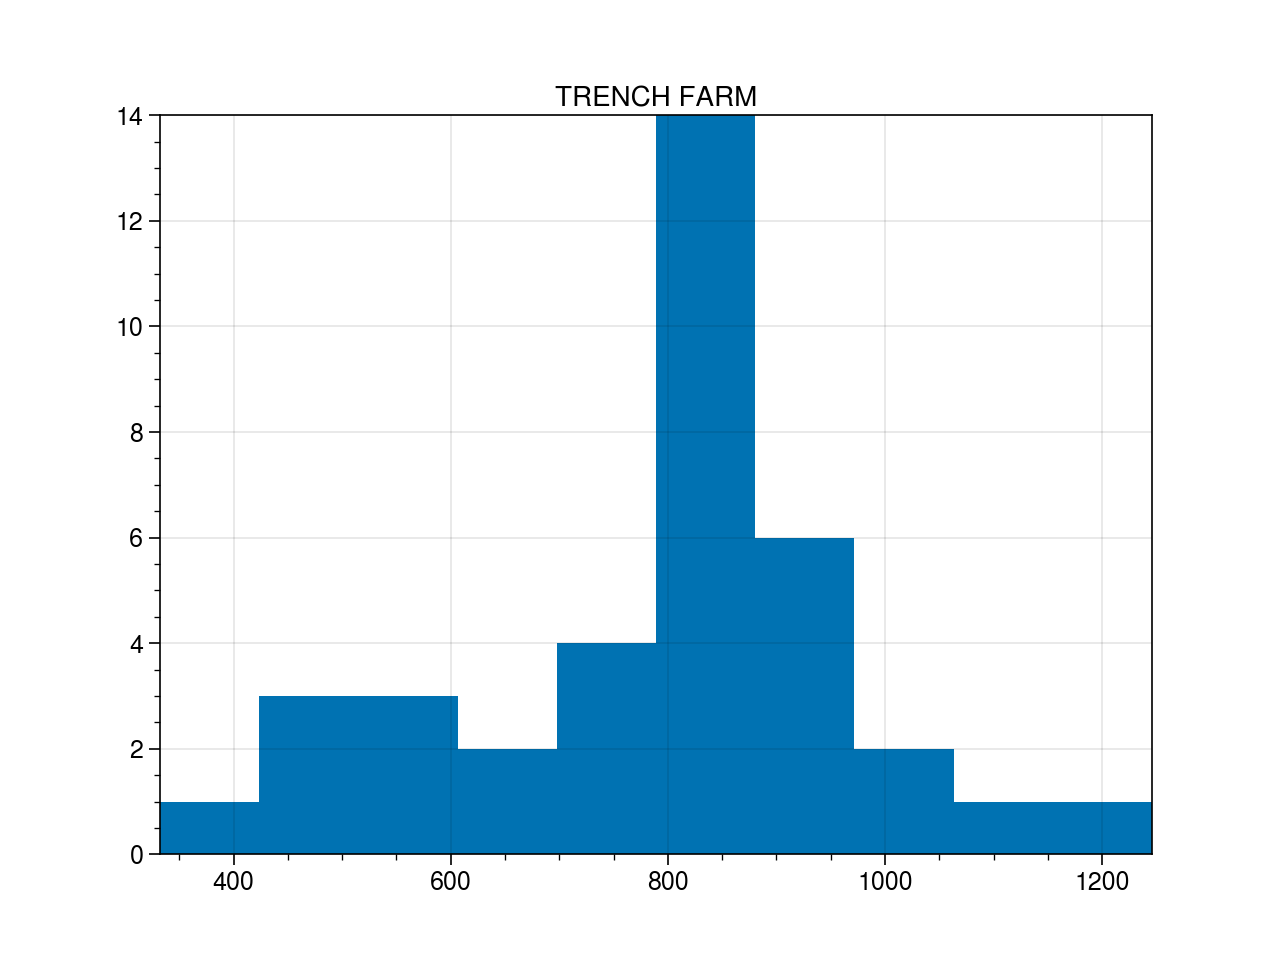

In [8]:
# Need to repeat this for all of the stations, visualize many histograms
stations = ['ARCHERS POST', 'ARDENCAPLE FARM', 'CASTLE FOREST STN',
       'CHOGORIA FOREST STN', 'CHUKA FOREST STN', 'COLCHECCIO', 'DOL DOL DAO',
       'EL KARAMA', 'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM',
       'GATHIURU FOREST STN', 'HOMBE FOREST STN', 'IRANGI FOREST STN',
       'ISIOLO DAO', 'JACOBSON FARM', 'JUNCTION (EWASO NAROK)',
       'KABARU FOREST STN', 'KAGURU', 'KALALU (NRM)', 'KAMWAKI FARM',
       'KARURI (NRM)', 'KINAMBA MOW', 'KISIMA FARM', 'LAMURIA MET STN',
       'LARIAK FOREST STN', 'LOGILADO (NRM)', 'LOLDAIGA FARM', 'LOLDOTO FARM',
       'LOLMARIK FARM', 'LORUKU FARM', 'MARALAL DC', 'MARIENE CRS',
       'MATANYA (NRM)', 'MERU FOREST STN', 'MOGWONI RANCH', 'MPALA FARM',
       'MUGIE RANCH', 'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)',
       'MURINGATO FOREST STN', 'MUTARA ADC FARM', 'MWEA IRRIGATION SCHEME',
       'NANYUKI FOREST STN', 'NANYUKI KAF', 'NARO MORU FG POST',
       'NARO MORU FOREST STN', 'NARO MORU GATE STN', 'NARO MORU MET STN',
       'NDARAGWA FOREST STN', 'NGENIA (NRM)', 'NGENIA B', 'NICOLSON FARM',
       'NYERI MOW', 'OL ARABEL FOREST STN', 'OL BOLOSAT FOREST STN',
       'OL DONYO FARM', 'OL JOGI FARM', 'OL JORO OROK FTC', 'OL MYSOR FARM',
       'OL PEJETA FARM', 'ONTULILI FOREST STN', 'PYRAMID OL JOGI',
       'RAGATI FOREST STN', 'RUMURUTI (NRM)', 'RUMURUTI MOW', 'SATIMA FARM',
       'SEGERA PLANTATIONS', 'SHAMATA', 'SIRAJI (NRM)', 'SIRIMA (NRM)',
       'SOLIO RANCH', 'SOUTH MARMANET FOREST STN', 'SUGUROI ESTATE',
       'TELEKI (MT KENYA)', 'TELESWANI (NRM)', 'THARUA FARM', 'TIMAU MARANIA',
       'TRENCH FARM']

for station in stations:
    df[[station,'Year']].dropna().groupby(['Year']).sum().hist()
    

In [9]:
d = df[['JACOBSON FARM','Year']].dropna()

### TODO. Figure out a way that drops years with missing 50% of the data.

Maybe it is fine for the SL and LR analysis because these aren't included. What gets messed up is the total rainfall analysis

What happens when I drop a year:

    # method 1: manually select year and drop those
    d[(d['Year'] != 2015)].groupby(['Year']).sum().hist()

    # method 2: select years with less than 100mm of rainfall
    d2 = d.groupby(['Year']).sum()
    d2[~(d2['JACOBSON FARM'] <= 100)].hist()

    # this also breaks the notebook when you do run all
    for station in df.columns:
        d2 = df[[station,'Year']].dropna().groupby(['Year']).sum()
        d2[~(d2[station] <= 100)].hist()

    df = df2 # This solves the problem for the low rainfall stations but not the highland stations

    # method 3: compare number of days in a year and drop years with less than half of days or something

maybe the way to do this is to first count the number of days in each year

In [10]:
_df = df[['JACOBSON FARM','Year','Month']].groupby(['Year']).count()

# now return rows with less than 365
_df[_df['JACOBSON FARM'] < 365]
#result[result['Value'] ! <= 10]  

,JACOBSON FARM,Month
Year,,
2009,363,365
2015,59,365
2016,0,336


In [11]:
# Let's see for all the stations what the situation is
#df = df.drop('Datetime', axis=1)
df=df_raw
stations = ['ARCHERS POST', 'ARDENCAPLE FARM', 'CASTLE FOREST STN',
       'CHOGORIA FOREST STN', 'CHUKA FOREST STN', 'COLCHECCIO', 'DOL DOL DAO',
       'EL KARAMA', 'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM',
       'GATHIURU FOREST STN', 'HOMBE FOREST STN', 'IRANGI FOREST STN',
       'ISIOLO DAO', 'JACOBSON FARM', 'JUNCTION (EWASO NAROK)',
       'KABARU FOREST STN', 'KAGURU', 'KALALU (NRM)', 'KAMWAKI FARM',
       'KARURI (NRM)', 'KINAMBA MOW', 'KISIMA FARM', 'LAMURIA MET STN',
       'LARIAK FOREST STN', 'LOGILADO (NRM)', 'LOLDAIGA FARM', 'LOLDOTO FARM',
       'LOLMARIK FARM', 'LORUKU FARM', 'MARALAL DC', 'MARIENE CRS',
       'MATANYA (NRM)', 'MERU FOREST STN', 'MOGWONI RANCH', 'MPALA FARM',
       'MUGIE RANCH', 'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)',
       'MURINGATO FOREST STN', 'MUTARA ADC FARM', 'MWEA IRRIGATION SCHEME',
       'NANYUKI FOREST STN', 'NANYUKI KAF', 'NARO MORU FG POST',
       'NARO MORU FOREST STN', 'NARO MORU GATE STN', 'NARO MORU MET STN',
       'NDARAGWA FOREST STN', 'NGENIA (NRM)', 'NGENIA B', 'NICOLSON FARM',
       'NYERI MOW', 'OL ARABEL FOREST STN', 'OL BOLOSAT FOREST STN',
       'OL DONYO FARM', 'OL JOGI FARM', 'OL JORO OROK FTC', 'OL MYSOR FARM',
       'OL PEJETA FARM', 'ONTULILI FOREST STN', 'PYRAMID OL JOGI',
       'RAGATI FOREST STN', 'RUMURUTI (NRM)', 'RUMURUTI MOW', 'SATIMA FARM',
       'SEGERA PLANTATIONS', 'SHAMATA', 'SIRAJI (NRM)', 'SIRIMA (NRM)',
       'SOLIO RANCH', 'SOUTH MARMANET FOREST STN', 'SUGUROI ESTATE',
       'TELEKI (MT KENYA)', 'TELESWANI (NRM)', 'THARUA FARM', 'TIMAU MARANIA',
       'TRENCH FARM']

for station in stations:
    _df = df[[station,'Year','Month']].dropna().groupby(['Year']).count()
    print(_df[_df[station] < 300]) # Should be 300 actually
    
# from this list the stations that are okay being used if considering records with more than 300 days or just one year
# at the end or beginning of the record with incomplete data
# if only 2-3 years show up as less than 300 days, checked to see if they were the first or last year of data collection
# as not all the records start on 1-1 or end on 12-31

# Stations to remove because more than 2-3 years of <300 day yearly records
delete = ['ARCHERS POST', 'CASTLE FOREST STN', 'COLCHECCIO', 'DOL DOL DAO', 'EL KARAMA', 'GATHIURU FOREST STN',
          'HOMBE FOREST STN', 'IRANGI FOREST STN', 'ISIOLO DAO', 'JUNCTION (EWASO NAROK)', 'KABARU FOREST STN',
          'KAGURU', 'KALALU (NRM)', 'KARURI (NRM)', 'KISIMA FARM', 'LAMURIA MET STN', 'LOGILADO (NRM)', 
          'LOLDAIGA FARM', 'LOLMARIK FARM', 'LORUKU FARM', 'MARALAL DC', 'MARIENE CRS', 'MATANYA (NRM)','MERU FOREST STN',
          'MURINGATO FOREST STN', 'NANYUKI KAF','NARO MORU FG POST', 'NARO MORU FOREST STN', 'NARO MORU GATE STN', 
          'NDARAGWA FOREST STN', 'NGENIA (NRM)', 'NGENIA B', 'NICOLSON FARM','NYERI MOW', 
          'OL ARABEL FOREST STN','OL JORO OROK FTC', 'OL PEJETA FARM', 'ONTULILI FOREST STN',
         'RAGATI FOREST STN', 'RUMURUTI (NRM)', 'SATIMA FARM','SHAMATA', 'SEGERA PLANTATIONS','SOLIO RANCH',
          'SOUTH MARMANET FOREST STN','SUGUROI ESTATE','THARUA FARM','TELEKI (MT KENYA)', 'TELESWANI (NRM)',
         'TRENCH FARM']

# Notes: 
# 0. MATANYA (NRM) (remove 2006 if last year)- Not sure??? 1986-2016 with missing 2007 and 2008. Need to remove
# 1. NANYUKI KAF (remove 1988 if last year) is 1971 to 2000, since 1988 is in the middle remove station from record
# 2. NDARAGWA FOREST STN (remove 2001 if first year remove 2015 if last year) - first year is 1981 so remove
# 3. NICOLSON FARM (remove 1994 if first year) - first year is 1970
# 4. OL ARABEL FOREST STN (remove if 2003 is first year) - 1983 is first year
# 5. SATIMA FARM (rempve 1997 if last year) - record is 1973 to 2015 so remove
# 6. SEGERA PLANTATIONS (remove 1987 if last year) - 1965 to 2004 so remove
# 7. SOUTH MARMANET FOREST STN (remove 1998 if last year) - 1957 to 2011 so remove
# 8. SUGUROI ESTATE (remove 1979 if first or last year) - 1962 to 1995 so remove
# 9. THARUA FARM (remove 1998 and 1999 if last years) - 1943 to 2011
# 10. TRENCH FARM (remove 1998 and 2000 if last years) - 2000 is last year



      ARCHERS POST  Month
Year                     
1978           181    181
      ARDENCAPLE FARM  Month
Year                        
2015               59     59
      CASTLE FOREST STN  Month
Year                          
1994                182    182
2003                212    212
2007                153    153
      CHOGORIA FOREST STN  Month
Year                            
2002                  212    212
Empty DataFrame
Columns: [CHUKA FOREST STN, Month]
Index: []
      COLCHECCIO  Month
Year                   
1968         244    244
1976         274    274
1977         243    243
1978         120    120
1979         213    213
1981         273    273
1982         151    151
1983         245    245
1998         273    273
      DOL DOL DAO  Month
Year                    
1963           59     59
1967          273    273
      EL KARAMA  Month
Year                  
2009        150    150
2015         83     83
Empty DataFrame
Columns: [EMBORI FARM, Month]
Index: []
      EM

      TIMAU MARANIA  Month
Year                      
2015             84     84
      TRENCH FARM  Month
Year                    
1998          273    273
2000          244    244


In [12]:
# Drop columns based on those in delete
df = df.drop(delete, axis=1)
len(df.columns) # lost more than half of the stations

33

In [13]:
# Now go through list of possibly okay stations to see what's up:

# stations that are okay - don't need to do anything with this
# CHUKA FOREST STN, EMBORI FARM, LOLDOTO FARM, 

# stations to check:
# ARDENCAPLE FARM (remove 2015) - Yes
# CHOGORIA FOREST STN (remove 2002 if last year) - Yes
# EMBU MET STN (remove 1976 if first year) - Yes
# ENASOIT FARM (remove 2002 if last year) - Yes
# JACOBSON FARM (remove 2015) - Yes
# KAMWAKI FARM (remove 2015 if last year) - Yes
# KINAMBA MOW (remove 2003 if last year)- Yes 
# MOGWONI RANCH (remove 2015 if last year) - Yes
# MUKENYA FARM (rempve 1958 if first year) - Yes
# MUKOGODO (NRM) (remove 2002 if last year) - Not sure???
# MUNYAKA (NRM) (remove 1991 if last year) - Not sure???
# MWEA IRRIGATION SCHEME (rempve 1998 if last year) - Yes
# NANYUKI FOREST STN (remove 2016) - Yes
# OL JOGI FARM (remove 1998 and 1999 if last two years) - Yes
# PYRAMID OL JOGI (remove 2002 if last year) - Yes
# RUMURUTI MOW (rempve 2003 if last year) - Yes
# SIRAJI (NRM) (remove 1992 if last year) - Not sure??
# SIRIMA (NRM) (remove 1998 if last year) - Not sure??
# TIMAU MARANIA (remove 2015 if last year) - Yes

# Import cleaned, merged datasets
AnnualRainfall = pd.read_csv("../data/CETRAD/AnnualRainfall.csv")  # Read in the Annual Rainfall per station
AnnualRainfall.head()

check_stations = ['ARDENCAPLE FARM', 'CHOGORIA FOREST STN','EMBU MET STN','ENASOIT FARM','JACOBSON FARM',
                 'KAMWAKI FARM','KINAMBA MOW','MOGWONI RANCH','MUKENYA FARM','MUKOGODO (NRM)','MUNYAKA (NRM)',
                 'MWEA IRRIGATION SCHEME','NANYUKI FOREST STN','NICOLSON FARM',
                 'OL JOGI FARM','PYRAMID OL JOGI','RUMURUTI MOW','SIRAJI (NRM)','SIRIMA (NRM)',
                  'SUGUROI ESTATE','TIMAU MARANIA']
# side note, average stats for a selection of farms
for s in check_stations:
    print('\n station:',s)
    d = AnnualRainfall[AnnualRainfall['Station'].str.match(s)]
    #print(d.dropna())
    d = d.dropna()
    print('mean:',d['Annual Rainfall'].mean(),'std:',d['Annual Rainfall'].std())
    diff = d.dropna().max()['Year']-d.dropna().min()['Year']
    print('first year',d.dropna().min()['Year'],'last year',d.dropna().max()['Year'],'\n length',diff)


 station: ARDENCAPLE FARM
mean: 636.7406160031251 std: 226.33523230793688
first year 1948 last year 2015 
 length 67

 station: CHOGORIA FOREST STN
mean: 2225.5107142857146 std: 609.4755637111213
first year 1989 last year 2002 
 length 13

 station: EMBU MET STN
mean: 1235.6999396444444 std: 321.88145362789595
first year 1976 last year 2011 
 length 35

 station: ENASOIT FARM
mean: 564.5562500000001 std: 198.49695689143775
first year 1971 last year 2002 
 length 31

 station: JACOBSON FARM
mean: 735.1669944634147 std: 173.57129656727116
first year 1934 last year 2015 
 length 81

 station: KAMWAKI FARM
mean: 622.0732991509805 std: 235.52991001025606
first year 1965 last year 2015 
 length 50

 station: KINAMBA MOW
mean: 810.142857142857 std: 149.6793172819078
first year 1990 last year 2003 
 length 13

 station: MOGWONI RANCH
mean: 630.8458942179487 std: 239.45270197136728
first year 1977 last year 2015 
 length 38

 station: MUKENYA FARM
mean: 616.0837209302326 std: 200.8694303820656

In [14]:
# At the end go through this loop again to check
df.columns

good_stations = ['ARDENCAPLE FARM', 'CHOGORIA FOREST STN', 'CHUKA FOREST STN',
       'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'JACOBSON FARM',
       'KAMWAKI FARM', 'KINAMBA MOW', 'LARIAK FOREST STN', 'LOLDOTO FARM',
        'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH',
       'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MUTARA ADC FARM',
       'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NARO MORU MET STN',
       'OL BOLOSAT FOREST STN', 'OL DONYO FARM', 'OL JOGI FARM',
       'OL MYSOR FARM', 'PYRAMID OL JOGI', 'RUMURUTI MOW', 'SIRAJI (NRM)',
       'SIRIMA (NRM)', 'TIMAU MARANIA']

for station in good_stations:
    _df = df[[station,'Year','Month']].dropna().groupby(['Year']).count()
    print(_df[_df[station] < 300]) # Should be 300 actually

      ARDENCAPLE FARM  Month
Year                        
2015               59     59
      CHOGORIA FOREST STN  Month
Year                            
2002                  212    212
Empty DataFrame
Columns: [CHUKA FOREST STN, Month]
Index: []
Empty DataFrame
Columns: [EMBORI FARM, Month]
Index: []
      EMBU MET STN  Month
Year                     
1976           245    245
      ENASOIT FARM  Month
Year                     
2002           240    240
      JACOBSON FARM  Month
Year                      
2015             59     59
      KAMWAKI FARM  Month
Year                     
2015            59     59
      KINAMBA MOW  Month
Year                    
2003          198    198
Empty DataFrame
Columns: [LARIAK FOREST STN, Month]
Index: []
Empty DataFrame
Columns: [LOLDOTO FARM, Month]
Index: []
      MOGWONI RANCH  Month
Year                      
2015             61     61
Empty DataFrame
Columns: [MPALA FARM, Month]
Index: []
Empty DataFrame
Columns: [MUGIE RANCH, Month]
Index:

In [15]:
# Now I need to drop certain years depending on previous list
# organize by years that need to be dropped

# Last years
_2015 = ['ARDENCAPLE FARM','JACOBSON FARM','KAMWAKI FARM','MOGWONI RANCH','TIMAU MARANIA']
for col in _2015:
    df[col].loc[(df['Year']==2015)] = np.nan
    #print(df)

# I think this worked
#x = df[['ARDENCAPLE FARM','Year']]
#x.loc[x['Year']==2015]

_2002 = ['CHOGORIA FOREST STN','ENASOIT FARM','PYRAMID OL JOGI','MUKOGODO (NRM)']
for col in _2002:
    df[col].loc[(df['Year']==2002)] = np.nan
    #print(df)
    
_2003 = ['KINAMBA MOW','RUMURUTI MOW']
for col in _2003:
    df[col].loc[(df['Year']==2003)] = np.nan
    
_1998 = ['MWEA IRRIGATION SCHEME','SIRIMA (NRM)']
for col in _1998:
    df[col].loc[(df['Year']==1998)] = np.nan
    
_2016 = ['NANYUKI FOREST STN']
for col in _2016:
    df[col].loc[(df['Year']==2016)] = np.nan
    
_1998_1999 = ['OL JOGI FARM']
for col in _1998_1999:
    df[col].loc[(df['Year']==1998)] = np.nan
    df[col].loc[(df['Year']==1999)] = np.nan

_1991 = ['MUNYAKA (NRM)']    
for col in _1991:
    df[col].loc[(df['Year']==1991)] = np.nan
    
_1992 = ['SIRAJI (NRM)']    
for col in _1992:
    df[col].loc[(df['Year']==1992)] = np.nan
    
# First years
_1976 = ['EMBU MET STN']
for col in _1976:
    df[col].loc[(df['Year']==1976)] = np.nan
    
_1958 = ['MUKENYA FARM']
for col in _1958:
    df[col].loc[(df['Year']==1958)] = np.nan

# I'm not sure why these stations show up as NaNs, so checking the manually in the AnnualRainfall.csv file
# Not sure
# MUKOGODO (NRM) (remove 2002 if last year) - 1989-2002, remove 2002
# MUNYAKA (NRM) (remove 1991 if last year) - 1991-2016, drop 1991
# SIRAJI (NRM) (remove 1992 if last year) - 1992 to 2001, so drop 1992
# SIRIMA (NRM) (remove 1998 if last year) - 1989-1998, drop 1998

df

# What I want to do is fill NaNs for rows that equal years and columns that equal names

# As a final step, make sure I didn't lose any stations that I'm taking from the original dataframe
df

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,ARDENCAPLE FARM,CHOGORIA FOREST STN,CHUKA FOREST STN,EMBORI FARM,EMBU MET STN,ENASOIT FARM,JACOBSON FARM,KAMWAKI FARM,KINAMBA MOW,LARIAK FOREST STN,...,OL JOGI FARM,OL MYSOR FARM,PYRAMID OL JOGI,RUMURUTI MOW,SIRAJI (NRM),SIRIMA (NRM),TIMAU MARANIA,Datetime,Year,Month
Datetime,,,,,,,,,,,,,,,,,,,,,
1934-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-01,1934,1
1934-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-02,1934,1
1934-01-03,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-03,1934,1
1934-01-04,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-04,1934,1
1934-01-05,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1934-01-05,1934,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-27,2016,11
2016-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-28,2016,11
2016-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-29,2016,11


In [16]:
# go through loop again to check 
df.columns
df_s = ['ARDENCAPLE FARM', 'CHOGORIA FOREST STN', 'CHUKA FOREST STN',
       'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'JACOBSON FARM',
       'KAMWAKI FARM', 'KINAMBA MOW', 'LARIAK FOREST STN', 'LOLDOTO FARM',
        'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH',
       'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MUTARA ADC FARM',
       'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NARO MORU MET STN',
       'OL BOLOSAT FOREST STN', 'OL DONYO FARM', 'OL JOGI FARM',
       'OL MYSOR FARM', 'PYRAMID OL JOGI', 'RUMURUTI MOW', 'SIRAJI (NRM)',
       'SIRIMA (NRM)', 'TIMAU MARANIA']

for station in df_s:
    _df = df[[station,'Year','Month']].dropna().groupby(['Year']).count()
    print(_df[_df[station] < 300]) # Should be 300 actually

Empty DataFrame
Columns: [ARDENCAPLE FARM, Month]
Index: []
Empty DataFrame
Columns: [CHOGORIA FOREST STN, Month]
Index: []
Empty DataFrame
Columns: [CHUKA FOREST STN, Month]
Index: []
Empty DataFrame
Columns: [EMBORI FARM, Month]
Index: []
Empty DataFrame
Columns: [EMBU MET STN, Month]
Index: []
Empty DataFrame
Columns: [ENASOIT FARM, Month]
Index: []
Empty DataFrame
Columns: [JACOBSON FARM, Month]
Index: []
Empty DataFrame
Columns: [KAMWAKI FARM, Month]
Index: []
Empty DataFrame
Columns: [KINAMBA MOW, Month]
Index: []
Empty DataFrame
Columns: [LARIAK FOREST STN, Month]
Index: []
Empty DataFrame
Columns: [LOLDOTO FARM, Month]
Index: []
Empty DataFrame
Columns: [MOGWONI RANCH, Month]
Index: []
Empty DataFrame
Columns: [MPALA FARM, Month]
Index: []
Empty DataFrame
Columns: [MUGIE RANCH, Month]
Index: []
Empty DataFrame
Columns: [MUKENYA FARM, Month]
Index: []
Empty DataFrame
Columns: [MUKOGODO (NRM), Month]
Index: []
Empty DataFrame
Columns: [MUNYAKA (NRM), Month]
Index: []
Empty DataFr

In [17]:
# Now these are all empty! Yay!
#df.to_csv('../data/CETRAD/CETRAD_rainfall_QAQC.csv',sep=',')

# after this export dataset and run mk on new dataset

### Step 1. Select stations for use
For brevity in this document, stations were combined into one dataframe and annual rainfall totals were calculated in another csv which is brought back in here. The original objective is to select three representative stations of low, medium, and high total rainfall for the study region. And then calculate alphas, lambdas using those records.

In [18]:
# Import cleaned, merged datasets
AnnualRainfall = pd.read_csv("../data/CETRAD/AnnualRainfall.csv")  # Read in the Annual Rainfall per station
AnnualRainfall.head()

stations = ['OL JOGI', 'OL PEJETA FARM','SOLIO RANCH','NANYUKI KAF','SEGERA PLANTATIONS',
           'EL KARAMA','MUKENYA FARM','JACOBSON FARM']
# side note, average stats for a selection of farms
for s in stations:
    print('\n station:',s)
    d = AnnualRainfall[AnnualRainfall['Station'].str.match(s)]
    print('mean:',d['Annual Rainfall'].mean(),'std:',d['Annual Rainfall'].std())
    diff = d.dropna().max()['Year']-d.dropna().min()['Year']
    print('first year',d.dropna().min()['Year'],'last year',d.dropna().max()['Year'],'\n length',diff)



 station: OL JOGI
mean: 538.0106060606062 std: 218.33831108424653
first year 1967 last year 1999 
 length 32

 station: OL PEJETA FARM
mean: 713.2824187468085 std: 215.8784657800303
first year 1965 last year 2014 
 length 49

 station: SOLIO RANCH
mean: 695.2840482574468 std: 165.9528843370657
first year 1967 last year 2014 
 length 47

 station: NANYUKI KAF
mean: 635.5533333333333 std: 184.1096875709458
first year 1971 last year 2000 
 length 29

 station: SEGERA PLANTATIONS
mean: 636.0735000000001 std: 241.78579900982712
first year 1965 last year 2004 
 length 39

 station: EL KARAMA
mean: 705.282133656923 std: 233.3816853083985
first year 1950 last year 2015 
 length 65

 station: MUKENYA FARM
mean: 616.0837209302325 std: 200.86943038206562
first year 1958 last year 2004 
 length 46

 station: JACOBSON FARM
mean: 735.1669944634147 std: 173.57129656727116
first year 1934 last year 2015 
 length 81


## 3. Mann-Kendall Tests <a id='min_max'></a>
What is the min and max number of years in the record; groupby station and get difference between min and max year. 


In [19]:
# drop rows with NaN in Annual Rainfall
df = AnnualRainfall.dropna(subset=['Annual Rainfall'],inplace=False)

vals = df.groupby('Station')['Year'].agg(np.ptp).to_frame()
vals['Year'].min()

print('shortest record',vals['Year'].min(),'\n longest record',vals['Year'].max())

shortest record 7 
 longest record 81


### 1b. What are the stations with 40+ years of data?

In [20]:
my_stations = vals[vals.Year > 39]
print('total number of stations',len(vals),'\n stations with 40+ yrs',len(my_stations))

# turn my_stations into list so that for the following statistics we only use these stations
my_stations.reset_index(inplace=True)
stations = my_stations['Station'].tolist()

# test
print('this needs to be true:',len(my_stations) == len(stations)) # need this to be true

# make sure the orig. df is longer than the subsetted one
print('make sure this orig. df:',len(df),'is longer than the subsetted one:', len(df[df.Station.isin(stations)]))

# now name list of stations to use as shortlist
shortlist = df[df.Station.isin(stations)]

total number of stations 80 
 stations with 40+ yrs 39
this needs to be true: True
make sure this orig. df: 3046 is longer than the subsetted one: 2038


### Define function for Mann-Kendall test

In [21]:
def mkt_stats(ALPHA=0.05, EPS=1, HA="upordown", DF=shortlist, COL='Station',tseries = 'Year', xseries = 'Annual Rainfall'):
    """" Usage:
    
    # now can try running statistical test on Annual Rainfall
    # need to run this for each station. Can do this in a for loop.
    # for every station which is a row in shortlist, do the statistical calculation
    # we want to know whether the trend is significant (p), the slope per station (m) to get the mean and standard error

    """
    results = []

    for s in stations:
        #print(shortlist[shortlist['Station'].str.match(s)])
        d = DF[DF[COL].str.match(s)]

        t_ = d[tseries].array # get the years for each station
        x_ = d[xseries].array # get the annual rainfall for each station

        # this is for any individual station
        MK, m, c, p = mkt.test(t_, x_, eps=EPS, alpha=ALPHA, Ha=HA)
        # scipy Theil-Sen estimator
        ss, medintercept, lo_slope, up_slope = scipy.stats.mstats.theilslopes(x_, alpha=ALPHA)

        # cat into single dataframe
        df = pd.DataFrame({'Station':s,'Hypothesis_test': MK, 'Slope': m, 'Intercept':c, 'Sig.':p, 'SenSlope':ss}, index=[0])
        results.append(df)

    final = pd.concat(results)
    pct_annual_rf = len(final[final['Hypothesis_test'].str.match('accept')]) / len(stations) * 100
    l_accept_annual_rf = len(final[final['Hypothesis_test'].str.match('accept')])
    accept_annual_rf = final[final['Hypothesis_test'].str.match('accept')]
    
    # percent of stations with statistically sig. trends
    print('number of stations with sig. trends:',l_accept_annual_rf,
          '\n percent of stations with sig. trends:',pct_annual_rf)

    # calculate the mean and se of the slopes
    m_annual_rf = accept_annual_rf['Slope'].mean()
    se_annual_rf = accept_annual_rf['Slope'].var()
    ss_annual_rf = final['SenSlope'].mean()
    sse_annual_rf = scipy.stats.sem(final['SenSlope'])
    
    # what stations are significant?
    print(final[final['Hypothesis_test'].str.match('accept')].Station)
    
    return final, pct_annual_rf, l_accept_annual_rf, accept_annual_rf, m_annual_rf, se_annual_rf, ss_annual_rf, sse_annual_rf    

### 1c. Are rain trends increasing or decreasing for Annual Rainfall (mm)? <a id='mannk'></a>
- Mann-Kendall test on Annual rainfall (mm). I used the package [mkt](https://up-rs-esp.github.io/mkt/#updated-formulae-for-implementation). To do this, I forked the original directory and moved the script `mkt.py` into maize-Toff/scripts so that I could access the function.
- Select stations with 40+ years of data -- not sure why Trenton used this and whether I need to justify.

Need to go through and read the docs to make sure what I'm assuming is correct:
1. What is the least count? Minimum possible measurement value. Some measure of error? When you change this number around the final result is not that different (same for 1 vs. 0.1, for example.)
2. For the alpha, going to use the same value as Trenton: 0.05
3. Ha is the type of test: one sided or two sided: up, down or up or down. I went with the last one to account for either increasing or decreasing trends.

In [22]:
final, pct_annual_rf, l_accept_annual_rf, accept_annual_rf, m_annual_rf, se_annual_rf, ss_annual_rf, sse_annual_rf = mkt_stats()

number of stations with sig. trends: 5 
 percent of stations with sig. trends: 12.82051282051282
0       CASTLE FOREST STN
0              COLCHECCIO
0        HOMBE FOREST STN
0    MURINGATO FOREST STN
0           TIMAU MARANIA
Name: Station, dtype: object


In [23]:
scipy.stats.sem(final['SenSlope'])

0.6193726590716221

### 1d. Rain trends for OND and MAM

Critical question: What happens if rains don't always start in May or October?


In [24]:
# try using df2 dataset
#df=d2
# Need to groupby month to get total rainfall during short and long rains
df = pd.melt(df_raw, id_vars=['Datetime','Year','Month']).dropna(); df

# Assign two seasons: Short rains = months 3,4,5; Long rains = 10,11,12

df1 = (df.assign(Season = np.select([df['Month'].between(3,5),
                                         df['Month'].between(10,12)],
                                         ['LongRains','ShortRains'], default=None))# this is right
         .groupby(['variable','Season','Year']).value
         .sum()
         .reset_index(name='SummedValue') #.replace(0, np.NaN).dropna()
          )
# For some reason the LongRains print first, but I checked this out in a csv
# and it's fine. For check, long rains Archers post 1957 should be 83.8 and it is. 
#df1 #(5999 rows and 4 columns)

# This solution also works but isn't as clear
#bins = [0,3,8,11]
#s = pd.cut(df['Month'],bins,labels=['1:3','irrelevant','9:11'])

#(df[s.isin(['1:3','9:11'])].assign(MonthGroups=s.astype(str))
#.groupby(['variable','MonthGroups','Year'])['value'].sum().reset_index())
df1

# Define two seasons
df_lr = df1.loc[df1['Season'] == 'LongRains']
df_sr = df1.loc[df1['Season'] == 'ShortRains']

# MK Test for Short Rains
final_ond, pct_ond_rf, l_accept_ond_rf, accept_ond_rf, m_ond_rf, se_ond_rf, ss_ond_rf, sse_ond_rf  = mkt_stats(DF=df_sr, COL='variable',tseries = 'Year', xseries = 'SummedValue')

df_lr_tot = df_lr
df_sr_tot = df_sr

number of stations with sig. trends: 3 
 percent of stations with sig. trends: 7.6923076923076925
0       COLCHECCIO
0          SHAMATA
0    TIMAU MARANIA
Name: Station, dtype: object


In [39]:
df_lr_tot.to_csv('~/Desktop/LongRains_Total.csv', sep=',')
df_sr_tot.to_csv('~/Desktop/ShortRains_Total.csv', sep=',')

In [25]:
# Long rains MKT Test
final_mam, pct_mam_rf, l_accept_mam_rf, accept_mam_rf, m_mam_rf, se_mam_rf,ss_mam_rf, sse_mam_rf  = mkt_stats(DF=df_lr, COL='variable',tseries = 'Year', xseries = 'SummedValue')

number of stations with sig. trends: 0 
 percent of stations with sig. trends: 0.0
Series([], Name: Station, dtype: object)


### 1e. Average arrival rate of rain events (lambda) for OND and MAM.


In [40]:
# Need to groupby month to get total rainfall during short and long rains
df = pd.melt(df_raw, id_vars=['Datetime','Year','Month']).dropna(); df

df1 = (df.assign(Season = np.select([df['Month'].between(3,5),
                                         df['Month'].between(10,12)],
                                         ['LongRains','ShortRains'], default=None))# this is right
         .groupby(['variable','Season','Datetime','Year']).value
         .sum()
         .reset_index(name='Value') #.replace(0, np.NaN).dropna()
         )
rainfall = df1
#Lambda by season
#for s in station:
    # First, find all the rows in the data where it rained and group by month.
#    rain_days = rainfall.loc[rainfall[station] > 0]

# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall.Value > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall.Value >= 0]

rain_days.head()
rainfall

lambda_by_season = (
    rain_days.groupby(['Season','variable','Year'])['Value'].count() /
    all_days.groupby(['Season','variable','Year'])['Value'].count()
    )

#pd.DataFrame(lambda_by_season).plot.bar() # this is a monstruous plot

# get to dataframe

lbs = lambda_by_season.to_frame().reset_index()

# Define two seasons
df_lr = lbs.loc[lbs['Season'] == 'LongRains']
df_sr = lbs.loc[lbs['Season'] == 'ShortRains']

df_lr_l = df_lr
df_sr_l = df_sr

df_lr_l.to_csv('~/Desktop/LongRains_Lambda.csv', sep=',')
df_sr_l.to_csv('~/Desktop/ShortRains_Lambda.csv', sep=',')

In [27]:
# Long rains MKT Test
final_mamL, pct_mamL_rf, l_accept_mamL_rf, accept_mamL_rf, m_mamL_rf, se_mamL_rf, ss_mamL_rf, sse_mamL_rf  = mkt_stats(EPS=0.001, DF=df_lr, COL='variable',tseries = 'Year', xseries = 'Value')
sse_mamL_rf
final_mamL

# why are there NaNs? Need to look into this.
print(sse_mamL_rf)

number of stations with sig. trends: 16 
 percent of stations with sig. trends: 41.02564102564102
0            CASTLE FOREST STN
0                    EL KARAMA
0          GATHIURU FOREST STN
0            IRANGI FOREST STN
0                   ISIOLO DAO
0                JACOBSON FARM
0            KABARU FOREST STN
0                 LOLDOTO FARM
0              MERU FOREST STN
0         MURINGATO FOREST STN
0              MUTARA ADC FARM
0           NARO MORU GATE STN
0                    NYERI MOW
0        OL BOLOSAT FOREST STN
0                      SHAMATA
0    SOUTH MARMANET FOREST STN
Name: Station, dtype: object
nan


In [28]:
# Short rains MKT Test
final_ondL, pct_ondL_rf, l_accept_ondL_rf, accept_ondL_rf, m_ondL_rf, se_ondL_rf, ss_ondL_rf, sse_ondL_rf  = mkt_stats(EPS=0.001, DF=df_sr, COL='variable',tseries = 'Year', xseries = 'Value')

# Note: EPS = 0.001 # Needed to change this value -- what does Trenton use?

scipy.stats.sem(final['SenSlope'])
print(se_ondL_rf)

number of stations with sig. trends: 17 
 percent of stations with sig. trends: 43.58974358974359
0              ARDENCAPLE FARM
0                   COLCHECCIO
0                JACOBSON FARM
0            KABARU FOREST STN
0                 KAMWAKI FARM
0              LAMURIA MET STN
0                 LOLDOTO FARM
0                  LORUKU FARM
0                   MPALA FARM
0         MURINGATO FOREST STN
0              MUTARA ADC FARM
0           NARO MORU GATE STN
0                    NYERI MOW
0               OL PEJETA FARM
0            RAGATI FOREST STN
0                  SOLIO RANCH
0    SOUTH MARMANET FOREST STN
Name: Station, dtype: object
9.355150945176644e-06


### 1f. Average rain per storm (alpha) for OND and MAM.


In [41]:
alpha_by_season = rain_days.groupby(['Season','Year','variable'])['Value'].mean()
alpha_by_season

abys = alpha_by_season.to_frame().reset_index()

# Define two seasons
df_lr = abys.loc[abys['Season'] == 'LongRains']
df_sr = abys.loc[abys['Season'] == 'ShortRains']
#df_sr

df_lr_a = df_lr
df_sr_a = df_sr

df_lr_a.to_csv('~/Desktop/LongRains_Alpha.csv', sep=',')
df_sr_a.to_csv('~/Desktop/ShortRains_Alpha.csv', sep=',')

In [30]:
# Long rains MKT Test

final_mamA, pct_mamA_rf, l_accept_mamA_rf, accept_mamA_rf, m_mamA_rf, se_mamA_rf, ss_mamA_rf, sse_mamA_rf  = mkt_stats(EPS=0.001, DF=df_lr, COL='variable',tseries = 'Year', xseries = 'Value')

print(sse_mamA_rf)


number of stations with sig. trends: 11 
 percent of stations with sig. trends: 28.205128205128204
0              ARDENCAPLE FARM
0                JACOBSON FARM
0            KABARU FOREST STN
0                 LOLDOTO FARM
0         MURINGATO FOREST STN
0              MUTARA ADC FARM
0          ONTULILI FOREST STN
0                      SHAMATA
0    SOUTH MARMANET FOREST STN
0                  THARUA FARM
0                TIMAU MARANIA
Name: Station, dtype: object
0.008719811524364825


In [31]:
# Short rains MKT Test
final_ondA, pct_ondA_rf, l_accept_ondA_rf, accept_ondA_rf, m_ondA_rf, se_ondA_rf, ss_ondA_rf, sse_ondA_rf  = mkt_stats(EPS=0.001, DF=df_sr, COL='variable',tseries = 'Year', xseries = 'Value')


number of stations with sig. trends: 13 
 percent of stations with sig. trends: 33.33333333333333
0              ARDENCAPLE FARM
0                    EL KARAMA
0             HOMBE FOREST STN
0                JACOBSON FARM
0            KABARU FOREST STN
0                 LOLDOTO FARM
0         MURINGATO FOREST STN
0              MUTARA ADC FARM
0           NARO MORU GATE STN
0                    NYERI MOW
0                      SHAMATA
0    SOUTH MARMANET FOREST STN
0                TIMAU MARANIA
Name: Station, dtype: object


In [32]:
sse_ondL_rf

nan

## Test for autocorrelation  <a id='auto'></a>

There's a potential issue with this data and using the MK test. Most likely this data is [serially correlated/autocorrelated](https://www.statisticshowto.com/serial-correlation-autocorrelation), which means we'll have to do some pre-whitening. Let's hope not for that, but most likely will have to do. We'll check for autocorrelation in the meantime.

Two ways to test:
1. [Durbin-Watson test](https://www.statology.org/durbin-watson-test-python/)
2. Plot residuals and look for clusters on one side of the residual line using [PACF](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html).

Some thoughts from Yi:

- You can directly perform the Durbin-Waston test on the data. Most of the context describing DW test is always using it in ordinary least square regression to test whether the residuals are lag-1 autocorrelated. But in your case, we are testing if the rainfall data are lag-1 autocorrelated so you can directly perform DW test on it. An alternative and more visually compelling way is plotting the PACF of your data to see the which lags have spikes that cross the upper confidence interval.

- For R package `fume`, I am not able to verify its legitimacy but I found out that it's not supported in R for a long time. So I would suggest an alternative package called `modifiedmk` the recent update of which is this march. https://cran.r-project.org/web/packages/modifiedmk/index.html

- You should try multiple methods in this package according to the author in his answer to this question.https://www.researchgate.net/post/Autocorrelation_Correction_Method_for_Mann-Kendall_test


### Durbin-Watson test

Below I run the DW test on all the annual data and then only for rainy days. Since neither of the test statistics are within the range of 1.5 and 2.5, we consider autocorrelation to be problematic in our modeling.

In [8]:
# Perform Durbin-Watson test on all daily rainfall on Jacobson Farm
print(durbin_watson(df[df['variable'].str.match('JACOB')]['value']))
j = df[df['variable'].str.match('JACOB')]['value']

# for only rainfall days
j_ = j[[i for i in j > 0]]
print(durbin_watson(j_))

KeyError: 'variable'

### Plot PACF

Any place where the dot is above the upper confidence interval then we have an issue with autocorrelation.

For more reading on this check out:
- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html
- https://campus.datacamp.com/courses/time-series-analysis-in-python/autoregressive-ar-models?ex=11

In [1]:
import statsmodels as sm

In [2]:
sm.graphics.tsaplots.plot_pacf(j_)

AttributeError: module 'statsmodels' has no attribute 'graphics'

In [36]:
## Exporting rainfall data to try in R

shortlist.to_csv('~/Desktop/AnnualRainfall.csv', sep=',')

### Exporting Jacobson Farm data to try in R

In [ ]:
d = shortlist[shortlist['Station'].str.match('JACOBSON FARM')]
d

t_ = d['Year'] #.array # get the years for each station
x_ = d['Annual Rainfall'] #.array # get the annual rainfall for each station
#t_.to_csv('~/Desktop/mann-kendall/JF_Annual_t.csv',sep=',')
#x_.to_csv('~/Desktop/mann-kendall/JF_Annual_x.csv',sep=',')

In [ ]:
d = df_lr_tot[df_lr_tot['variable'].str.match('JACOBSON FARM')]
d

x_ = d['SummedValue']
x_.to_csv('~/Desktop/mann-kendall/JF_LR_tot_x.csv',sep=',')

d = df_sr_tot[df_sr_tot['variable'].str.match('JACOBSON FARM')]
x_ = d['SummedValue']
#x_.to_csv('~/Desktop/mann-kendall/JF_SR_tot_x.csv',sep=',')

In [ ]:
df_lr_l

d = df_lr_l[df_lr_l['variable'].str.match('JACOBSON FARM')]
x_ = d['Value']
#x_.to_csv('~/Desktop/mann-kendall/JF_LR_l_x.csv',sep=',')

d = df_sr_l[df_sr_l['variable'].str.match('JACOBSON FARM')]
x_ = d['Value']
#x_.to_csv('~/Desktop/mann-kendall/JF_SR_l_x.csv',sep=',')

In [ ]:
df_lr_a

df_lr_l

d = df_lr_a[df_lr_a['variable'].str.match('JACOBSON FARM')]
x_ = d['Value']
#x_.to_csv('~/Desktop/mann-kendall/JF_LR_a_x.csv',sep=',')

d = df_sr_a[df_sr_a['variable'].str.match('JACOBSON FARM')]
x_ = d['Value']
#x_.to_csv('~/Desktop/mann-kendall/JF_SR_a_x.csv',sep=',')

a question... is it mean and standard error of all stations or just the significant ones?

<a id='sen'></a>

## 5. Use Sen's method for Mean slope of all stations

Trenton cited Maidment's [Handbook of hydrology](https://babel.hathitrust.org/cgi/pt?id=mdp.39015029254243&view=1up&seq=993), which brought me to this original cite here: 

16.5 Sen's Non parametric estimator of slope [Gilbert 1987](https://www.osti.gov/servlets/purl/7037501).
There a few pythoh packages that can return this for me: [scipy](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.mstats.theilslopes.html); [pymannkendall](https://pypi.org/project/pymannkendall/); [TheilSen](https://davidcarslaw.github.io/openair/reference/TheilSen.html).
[SciKitLearn](https://scikit-learn.org/stable/auto_examples/linear_model/plot_theilsen.html)

#### But what is _it_?
- Sen's method (1968) discovers trends in univariate data which is more resistent to outliers than a normal slope calculation. Breakdown point is 0.29. It is nonparametric. Also called Theil-Sen Regression. Steps are:

    1. Calculate slopes for all ordered pair time points.
    2. Find the median of all slopes. 


I ended up using scipy's function, [theilslopes](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.theilslopes.html).

<a id='table'></a>

## Make table

In [37]:
# eventually I will want a table with the following and so I can start to make it here
p_desc = ['Total rainfall (mm)','Total rainfall (mm)',  'Annuall rainfall (mm)', 
          'Average rain per storm, 'r'$\alpha $, (mm)','Average rain per storm,  'r'$\alpha $, (mm)',
         'Average arrival rate of rain, λ, (day$^{-1}$)',
         'Average arrival rate of rain, λ, (day$^{-1}$)']
perc_stn = [pct_ond_rf,pct_mam_rf,pct_annual_rf,pct_ondA_rf,pct_mamA_rf,pct_ondL_rf,pct_mamL_rf]
m_slope =  [m_ond_rf,m_mam_rf,m_annual_rf,m_ondA_rf,m_mamA_rf,m_ondL_rf,m_mamL_rf] # This uses's Sens's method. Not sure what that is. 
var_slope = [se_ond_rf,se_mam_rf,se_annual_rf,se_ondA_rf,se_mamA_rf,se_ondL_rf,se_mamL_rf]
s_slope = [ss_ond_rf,ss_mam_rf,ss_annual_rf,ss_ondA_rf,ss_mamA_rf,ss_ondL_rf,ss_mamL_rf]
se_slope = [sse_ond_rf,sse_mam_rf,sse_annual_rf,sse_ondA_rf,sse_mamA_rf,se_ondL_rf,se_mamL_rf] # Note! Manually changed this to make it work but requires a deeper dive

season = ['Short rains', 'Long rains','Both','Short rains','Long rains','Short rains','Long rains']

table1 = pd.DataFrame({'Parameter description ':p_desc,
                       'Season': season,
                       '% of stations with significant trends (p < 0.05, Mann-Kendall test)': perc_stn,
                       #'Mean slope': m_slope,
                       #'SE slopes':var_slope,
                         'Mean slope of all stations using Theil-Sen method':s_slope,
                     'Standard error of slopes':se_slope})

table1 = table1.round({'% of stations with significant trends (p < 0.05, Mann-Kendall test)':1,'Mean slope of all stations using Theil-Sen method':4
                      }) #
#table1.to_csv('table1.csv',sep=',')

table1

# make easier table for latex export.. Just the numbers!
#export = table1[table1.columns[-3:]]
#export.to_latex(index=False)

# I think the NaNs had to do with rounding
#print(sse_ondL_rf)

,Parameter description,Season,"% of stations with significant trends (p < 0.05, Mann-Kendall test)",Mean slope of all stations using Theil-Sen method,Standard error of slopes
0,Total rainfall (mm),Short rains,7.7,0.6469,0.226673
1,Total rainfall (mm),Long rains,0.0,-0.5033,0.210348
2,Annuall rainfall (mm),Both,12.8,-0.0673,0.619373
3,"Average rain per storm, $\alpha $, (mm)",Short rains,33.3,0.0307,0.010497
4,"Average rain per storm, $\alpha $, (mm)",Long rains,28.2,0.0316,0.008720
5,"Average arrival rate of rain, λ, (day$^{-1}$)",Short rains,43.6,0.0000,0.000009
6,"Average arrival rate of rain, λ, (day$^{-1}$)",Long rains,41.0,-0.0014,0.000003


<a id='fig'></a>
## 6. Make a figure like Trenton's

Using one location.. JACOBSON FARM

This code is sooooooooo ugly. But it works.

In [ ]:
station = 'JACOBSON FARM'
#df_sr_tot = df_sr_tot.set_index('Year')

fig, axs = plot.subplots(nrows=3, ncols=2, share=0, spanx=3, journal='agu4') #span=1, axwidth=1)share=0,
# axwidth=2, 

axs.format(
        xlabel='Year', #ylabel='ylabel', suptitle='test',
        abc=True, abcloc='ur' #grid=False, xticks=25, yticks=5
    )

ALPHA = 0.05

# TOTAL, SHORT RAINS --- this is soooo janky but it works.   
test = df_sr_tot.loc[df_sr_tot['variable'] == station] # dataframe with time series
test2 = final_ond.loc[final_ond['Station'] == station] # dataframe with mk results

yval = test['SummedValue'].tolist()
idx = test['Year'].tolist()
df = pd.DataFrame(yval, columns = ['SummedValue'], index=idx)
m = test2['Slope'].item()
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
#t = [float(item) for item in idx]
t = df.index
x = test['SummedValue']
df['Rainfall (mm)'] = m * t + c
df['x_str'] = idx
print(p)

# plot results
axs[0,0].bar(df.SummedValue, color='gray') #"k.-", label="Sampled time series"
axs[0,0].format(title='Short Rainy Season, Total') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[0,0].plot(df['Rainfall (mm)'])
axs[0,0].set_ylim([0, 600])

#axs[0,0].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 516))
axs[0,0].annotate("p < 0.05\nm = %.2f" % (m), xy=(1937, 516))


# TOTAL, LONG RAINS    
test = df_lr_tot.loc[df_lr_tot['variable'] == station]
test2 = final_mam.loc[final_mam['Station'] == station]

yval = test['SummedValue'].tolist()
idx = test['Year'].tolist()
df = pd.DataFrame(yval, columns = ['SummedValue'], index=idx)
df['Rainfall (mm)'] = m * t + c
df['x_str'] = idx
m = test2['Slope'].item()
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
#t = [float(item) for item in idx]
t = df.index
x = test['SummedValue']

# plot results
#axs[0,1].bar(df.SummedValue, color='gray') #"k.-", label="Sampled time series"
axs[0,1].format(title='Long Rainy Season, Total') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
#axs[0,1].plot(df['Rainfall (mm)'])
axs[0,1].set_ylim([0, 600])

axs[0,1].annotate("p = %.2f\nm = %.2f" % (p, m), xy=(1937, 516)) # 


axs[0,1].bar(
        df.SummedValue, color='gray', label='Sampled time series', legend='r', #cycle='Set3',
        legend_kw={'ncols': 1, 'frame': False} #'title': 'Legend'
    )

    
axs[0,1].plot(df['Rainfall (mm)'], label='Linear fit', legend='r', #cycle='Set3',color='blue', 
        legend_kw={'loc':'upper center','ncols': 1, 'frame': False} # , 'title': 'Legend'
    )    


# ALPHA, SHORT RAINS
test = df_sr_a.loc[df_sr_a['variable'] == station]
test2 = final_ondA.loc[final_ondA['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
t_as=t
m = test2['Slope'].item(); m
m_as=m
c = test2['Intercept'].item()
c_as=c
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']
x_as=x

df['Rain per storm, 'r'$\alpha $, (mm)'] = m * t + c
df['x_str'] = idx
df

# plot results
axs[1,0].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[1,0].format(title='Short Rainy Season, Alpha') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[1,0].plot(df['Rain per storm, 'r'$\alpha $, (mm)'])
axs[1,0].set_ylim([0, 25])

#axs[1,0].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 21.5))
axs[1,0].annotate("p < 0.05\nm = %.3f" % (m), xy=(1937, 21.5))


# ALPHA, LONG RAINS
test = df_lr_a.loc[df_lr_a['variable'] == station]
test2 = final_mamA.loc[final_mamA['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
t_al = t
m = test2['Slope'].item(); m
m_al = m
c = test2['Intercept'].item()
c_al = c
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']
x_al = x

df['Rain per storm, 'r'$\alpha $, (mm)'] = m * t + c
df['x_str'] = idx
df

axs[1,1].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[1,1].format(title='Long Rainy Season, Alpha') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[1,1].plot(df['Rain per storm, 'r'$\alpha $, (mm)'])
axs[1,1].set_ylim([0, 25])
#axs[1,1].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 21.5)) #21.5/25 = 0.86
axs[1,1].annotate("p < 0.05\nm = %.3f" % (m), xy=(1937, 21.5)) #21.5/25 = 0.86


# LAMBDA, SHORT RAINS
test = df_sr_l.loc[df_sr_l['variable'] == station]
test2 = final_ondL.loc[final_ondL['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
t_ls = t
m = test2['Slope'].item(); m
m_ls = m
c = test2['Intercept'].item()
c_ls = c
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']
x_ls = x

df['Inter-storm arrival, λ, (day$^{-1}$)'] = m * t + c
df['x_str'] = idx

# plot results
axs[2,0].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[2,0].format(title='Short Rainy Season, Lambda') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[2,0].plot(df['Inter-storm arrival, λ, (day$^{-1}$)'])
axs[2,0].set_ylim([0, 0.8])
#axs[2,0].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 0.69)) # 0.85
axs[2,0].annotate("p < 0.05\nm = %.4f" % (m), xy=(1937, 0.69)) # 0.85


# LAMBDA, LONG RAINS
test = df_lr_l.loc[df_lr_l['variable'] == station]
test2 = final_mamL.loc[final_mamL['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
t_ll = t
m = test2['Slope'].item(); m
m_ll=m
c = test2['Intercept'].item()
c_ll=c
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']
x_ll=x

df['Inter-storm arrival, λ, (day$^{-1}$)'] = m * t + c
df['x_str'] = idx

axs[2,1].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[2,1].format(title='Long Rainy Season, Lambda') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[2,1].plot(df['Inter-storm arrival, λ, (day$^{-1}$)'])
axs[2,1].set_ylim([0, 0.8])

# Annotations
#axs[2,1].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 0.69))
axs[2,1].annotate("p < 0.05\nm = %.4f" % (m), xy=(1937, 0.69))

# Export figure as a jpg and pdf
#plt.savefig('../output/figures/jacobson_ts.pdf')
#plt.savefig('../output/figures/jacobson_ts.png')


## 7. Scatterplot comparing alphas and lambdas <a id='scatter'></a>

Make scatterplot figure Kelly suggested

In [ ]:
plt.scatter(df_lr_a.loc[df_lr_a['variable'] == station].Value, 
            df_lr_l.loc[df_lr_l['variable'] == station].Value,
            c='b', label='Long Rains')

plt.scatter(df_sr_a.loc[df_sr_a['variable'] == station].Value, 
            df_sr_l.loc[df_sr_l['variable'] == station].Value,
            c='r', label='Short Rains')

plt.xlabel('Alpha, mm')
plt.ylabel('Lambda, day-1')

plt.title('Relationship between yearly alphas and lambdas for Jacobson Farm, n=81')
plt.legend()

## Make scatterplot but for all stations

Stations that I tried but gave `mismatch x and y` error or needs QAQC.

      'KAMWAKI FARM',  'MOGWONI RANCH','MUGIE RANCH','MPALA FARM','OL DONYO FARM' 'OL BOLOSAT FOREST STN' 'COLCHECCIO', 'KABARU FOREST STN',OL PEJETA FARM 'MURINGATO FOREST STN','SOLIO RANCH', ''SOUTH MARMANET FOREST STN',- mismatch x and y 
    'LOLDOTO FARM', ,'NANYUKI FOREST STN'- needs QAQC maybe

In [ ]:
short_list = ['ARCHERS POST','ARDENCAPLE FARM', 'CASTLE FOREST STN','CHOGORIA FOREST STN', 'CHUKA FOREST STN','EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'JACOBSON FARM',
              'KINAMBA MOW','LAMURIA MET STN','LARIAK FOREST STN','LORUKU FARM','MUKENYA FARM', 'MUKOGODO (NRM)',
             'MUNYAKA (NRM)','MUTARA ADC FARM','MWEA IRRIGATION SCHEME','NARO MORU FOREST STN','NARO MORU GATE STN',
             'NARO MORU MET STN','NYERI MOW','OL JOGI FARM','OL MYSOR FARM','PYRAMID OL JOGI',
              'RAGATI FOREST STN','RUMURUTI MOW',  'SIRAJI (NRM)','SIRIMA (NRM)','TIMAU MARANIA']
    
f, axs = plot.subplots(nrows=6, ncols=5, axwidth=2.2, aspect=1, sharex=0, sharey=0)
axs.format(abc=False, abcloc='ur', xlabel='Alpha, mm', ylabel='Lambda, day^-1',
        xticks=3, yticks=.1, suptitle='Scatterplot of yearly alphas and lambdas for 25 stations') 

for ax, i in zip(axs, short_list):
    ax.scatter(df_lr_a.loc[df_lr_a['variable'] == i].Value, 
            df_lr_l.loc[df_lr_l['variable'] == i].Value,
            c='b', label='Long Rains')

    ax.scatter(df_sr_a.loc[df_sr_a['variable'] == i].Value, 
                df_sr_l.loc[df_sr_l['variable'] == i].Value,
                c='r', label='Short Rains')
    ax.set_xlabel('Alpha, mm')
    ax.set_ylabel('Lambda, day^-1')
    ax.format(
        title=f'{i}', titleweight='bold',
        titleloc='uc', #titlecolor='red9',
    )

In [ ]:
# good_stations = ['ARDENCAPLE FARM', 'CHOGORIA FOREST STN', 'CHUKA FOREST STN',
#        'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'JACOBSON FARM',
#        'KAMWAKI FARM', 'KINAMBA MOW', 'LARIAK FOREST STN', 'LOLDOTO FARM',
#         'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH',
#        'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MUTARA ADC FARM',
#        'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NARO MORU MET STN',
#        'OL BOLOSAT FOREST STN', 'OL DONYO FARM', 'OL JOGI FARM',
#        'OL MYSOR FARM', 'PYRAMID OL JOGI', 'RUMURUTI MOW', 'SIRAJI (NRM)',
#        'SIRIMA (NRM)', 'TIMAU MARANIA']

<a id='extract'></a>
## 8. Extract values from long-term trend

### Table of values for 2-past-cropping-outcomes

In [ ]:
slopes = pd.DataFrame({'Parameter':['alpha','alpha','lambda','lambda'],
                       'Season': ['Short rains','Long rains','Short rains','Long rains'],
                       'Slope': [m_as,m_al,m_ls,m_ll],
                       'c':[c_as,c_al,c_ls,c_ll]
                      })
slopes

### To get the values of 5 months put together, let's get the average of these two. 

In [ ]:
def average(n1, n2):
    return (n1 + n2) / 2.0  # `2.0` to get floating precision

average(m_as, m_al)

slopes_final = pd.DataFrame({'Parameter':['alpha','lambda'],
                       'Slope': [average(m_as,m_al),average(m_ls,m_ll)],
                       'c':[average(c_as,c_al),average(c_ls,c_ll)]
                      })

slopes_final

<a id='excess'></a>
# 9. Excess Code



Can't actually take from the trend line because I need the monthly alphas and lambdas... So, instead averaging values.

# This part gets really messy/bad (!)

In [ ]:
def make_climate_parameters(station='OL JOGI FARM'):

	# Prepare the CETRAD dataset.
	year_min = 30 # minimum number of years to consider for a valid climate record.

	df = pd.read_csv("../data/CETRAD/CETRAD_rainfall.csv")  # Read in the raw csv data.

	# Step 1. Convert text strings into datetime objects.
	format = '%m/%d/%y' # Column RDate has data in M/D/YY
	df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

	# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
	# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
	# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
	# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
	df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

	# Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
	df['Year'] = [dt.year for dt in df['Datetime']]
	df['Month'] = [dt.month for dt in df['Datetime']]

	n_years = len(df['Year'].unique())

	# Check to make sure we have enough data for fitting and parameter estimation.
	if n_years < year_min:
		print("WARNING! Station record for {station} has only {n_years} years.".format(
			station=station,
			n_years=n_years))

	# Step 4. Use the Datetime values as the index for this dataframe.
	df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

	# Step 5.  Delete the old RDate column, which we no longer need. 
	# We will keep the Datetime column, in case we need it later.
	df = df.drop(['RDate'], axis=1)

	columns = [station] + ['Year', 'Month', 'Datetime']
	rainfall = df[columns]

	# First, find all the rows in the data where it rained and group by month.
	rain_days = rainfall.loc[rainfall[station] > 0]

	# Find all locations in the data where an observation was made.
	all_days = rainfall.loc[rainfall[station] >= 0]

	# Find just the rainfall amounts on days that it rained.
	data = rainfall.loc[rainfall[station] > 0][station]
	
	# Fit the daily rainfall amounts to an exponential distribution.
	check_exponential(data)

	# Determine the Monthly values of alpha and lambda from the station data:
	lambda_by_month = (
	    rain_days.groupby('Month')[station].count() /
	    all_days.groupby('Month')[station].count()
	)

	alpha_by_month = rain_days.groupby('Month')[station].mean()

	# MAKE THE CLIMATE PARAMETER DICT:
	climate = pd.DataFrame(alpha_by_month)
	climate = climate.rename(columns={station: 'alpha_by_month'})
	climate['lambda_by_month'] = lambda_by_month

	return climate['alpha_by_month'].to_list(), climate['lambda_by_month'].to_list(), rainfall, rain_days, all_days

In [ ]:
a, l, rainfall, rain_days, all_days = make_climate_parameters('JACOBSON FARM')

In [ ]:
# Get the average alpha from the first five years of the record, middle five years of the record, and last five years of the record
# 1935-1940 (not inclusive) (32 yrs later)
# 1972-1977 
# 2010-2015 (33 yrs later)

# NOTE!! These cells are only done with Jacobson Farm!
rainfall
to_drop = rainfall[rainfall['Year']==2015].index
rainfall.drop(to_drop, inplace=True); rainfall

In [ ]:
# do the same thing with rain_days
to_drop = rain_days[rain_days['Year']==2015].index
rain_days.drop(to_drop, inplace=True); rain_days

In [ ]:
# do the same thing with all_days
to_drop = all_days[all_days['Year']==2015].index
all_days.drop(to_drop, inplace=True); all_days

In [ ]:
station = 'JACOBSON FARM'
lambda_by_month = (
    rain_days.groupby(['Year','Month']).count() /
    all_days.groupby(['Year','Month']).count()
    )
#pd.DataFrame(lambda_by_year).plot.bar()

alpha_by_month = rain_days.groupby(['Year','Month']).mean()
lambda_by_month.drop('Datetime',axis=1, inplace=True)
lambda_by_month

In [ ]:
# Now with this I can get the average
# first five
print(lambda_by_month.query('Month=="3" & Year >= 1934 & Year < 1940'))
lambda_by_month.query('Month=="1" & Year > 1934 & Year < 1940').mean()
lambda_by_month.query('Month=="3" & Year < 1939').mean().item()
# mid five
lambda_by_month.query('Month=="3" & Year > 1971 & Year < 1977')
#last five
lambda_by_month.query('Month=="3" & Year > 2009') #.mean().item()

In [ ]:
# consider doing replacements
first_five = 'Month=="1" & Year > 1934 & Year < 1940'
mid_five = 
last_five = 

In [ ]:
# There is certainly a more elegant way to do this and I did not do it!
data = {'Cat':pd.Series(['first5', 'mid5', 'last5']).repeat(12), 
        'Month':[1,2,3,4,5,6,7,8,9,10,11,12] * 3,
        'Mean':[lambda_by_month.query('Month=="1" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="2" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="3" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="4" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="5" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="6" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="7" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="8" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="9" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="10" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="11" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_month.query('Month=="12" & Year >= 1934 & Year < 1939').mean().item(),
                
                lambda_by_month.query('Month=="1" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="2" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="3" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="4" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="5" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="6" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="7" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="8" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="9" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="10" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="11" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_month.query('Month=="12" & Year >= 1971 & Year < 1976').mean().item(),
                
                lambda_by_month.query('Month=="1" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="2" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="3" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="4" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="5" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="6" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="7" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="8" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="9" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="10" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="11" & Year >= 2009').mean().item(),
                lambda_by_month.query('Month=="12" & Year >= 2009').mean().item()
               ], 
        'SD':[lambda_by_month.query('Month=="1" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="2" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="3" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="4" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="5" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="6" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="7" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="8" & Year >= 1934 & Year < 1940').std().item(),
              lambda_by_month.query('Month=="9" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="10" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="11" & Year >= 1934 & Year < 1940').std().item(),
               lambda_by_month.query('Month=="12" & Year >= 1934 & Year < 1940').std().item(),
            
                lambda_by_month.query('Month=="1" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="2" & Year >= 1971 & Year < 1976').std().item(), 
                lambda_by_month.query('Month=="3" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="4" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="5" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="6" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="7" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="8" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="9" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="10" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="11" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_month.query('Month=="12" & Year >= 1971 & Year < 1976').std().item(),
                
                lambda_by_month.query('Month=="1" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="2" & Year >= 2009').std().item(),  
                lambda_by_month.query('Month=="3" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="4" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="5" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="6" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="7" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="8" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="9" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="10" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="11" & Year >= 2009').std().item(),
                lambda_by_month.query('Month=="12" & Year >= 2009').std().item()
        ]} 
  
# Create DataFrame 
new_lambdas = pd.DataFrame(data) 
new_lambdas


new_lambdas['Mean'].plot.bar(x=new_lambdas['Month'], yerr=new_lambdas['SD'])
plt.xticks(np.arange(36), [1,2,3,4,5,6,7,8,9,10,11,12] * 3, rotation=90)  # Set text labels.

plt.ylabel('Monthly lambdas')
plt.xlabel('Three groups of months')
plt.title('Monthly lambdas with error')

# Opportunity to make this figure: Either make the months next to each other or have different colors/labels for first 
# five, mid five, last five..

In [ ]:
# For alphas

data_a = {'Cat':pd.Series(['first5', 'mid5', 'last5']).repeat(12), 
        'Month':[1,2,3,4,5,6,7,8,9,10,11,12] * 3,
         'Mean':[alpha_by_month.query('Month=="1" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="2" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="3" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="4" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="5" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="6" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="7" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="8" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="9" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="10" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="11" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_month.query('Month=="12" & Year >= 1934 & Year < 1939').mean().item(),
                
                alpha_by_month.query('Month=="1" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="2" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="3" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="4" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="5" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="6" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="7" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="8" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="9" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="10" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="11" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_month.query('Month=="12" & Year >= 1971 & Year < 1976').mean().item(),
                
                alpha_by_month.query('Month=="1" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="2" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="3" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="4" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="5" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="6" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="7" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="8" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="9" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="10" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="11" & Year >= 2009').mean().item(),
                alpha_by_month.query('Month=="12" & Year >= 2009').mean().item()
               ], 
        'SD':[alpha_by_month.query('Month=="1" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="2" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="3" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="4" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="5" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="6" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="7" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="8" & Year >= 1934 & Year < 1940').std().item(),
              alpha_by_month.query('Month=="9" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="10" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="11" & Year >= 1934 & Year < 1940').std().item(),
               alpha_by_month.query('Month=="12" & Year >= 1934 & Year < 1940').std().item(),
            
                alpha_by_month.query('Month=="1" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="2" & Year >= 1971 & Year < 1976').std().item(), 
                alpha_by_month.query('Month=="3" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="4" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="5" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="6" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="7" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="8" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="9" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="10" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="11" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_month.query('Month=="12" & Year >= 1971 & Year < 1976').std().item(),
                
                alpha_by_month.query('Month=="1" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="2" & Year >= 2009').std().item(),  
                alpha_by_month.query('Month=="3" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="4" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="5" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="6" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="7" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="8" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="9" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="10" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="11" & Year >= 2009').std().item(),
                alpha_by_month.query('Month=="12" & Year >= 2009').std().item()
        ]} 
  
  
# Create DataFrame 
new_alphas = pd.DataFrame(data_a) 
new_alphas

new_alphas['Mean'].plot.bar(x=new_alphas['Month'], yerr=new_alphas['SD'], color='orange')
plt.ylabel('Monthly alphas')
plt.xlabel('Five groups of months')
plt.title('Monthly alphas with error')

In [ ]:
# export these daatframes

new_alphas.to_csv('../output/2-rainfall-variability/alpha_by_month.csv',sep=',')
new_lambdas.to_csv('../output/2-rainfall-variability/lambda_by_month.csv',sep=',')

## New way of doing things with 5 year dekadals

In [ ]:
# New way of doing things

def make_climate_parameters(
        station='OL JOGI FARM',
        data_file=module_path + '/data/CETRAD/CETRAD_rainfall.csv',
        year_min=30,
        interval='month'):
    """ 


    TODO: WRITE DOCSTRINGS




    """

    # Prepare the CETRAD dataset.
    year_min = year_min # minimum number of years to consider for a valid climate record.

    df = pd.read_csv(data_file)  # Read in the raw csv data.

    # Step 1. Convert text strings into datetime objects.
    format = '%m/%d/%y' # Column RDate has data in M/D/YY
    df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

    # 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
    # Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
    # We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
    # their value. This requires using the relativedelta function, which handles weird stuff like leap years.
    df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

    # Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
    df['Year'] = [dt.year for dt in df['Datetime']]
    df['Month'] = [dt.month for dt in df['Datetime']]
    df['Week'] = [dt.week for dt in df['Datetime']]
    df['Semi_Month'] = (df['Datetime'].dt.day
                          .gt((df['Datetime']+pd.tseries.offsets.MonthEnd()).dt.day//2) 
                          + df['Month']*2 -1)
    df['Dekad'] = df['Datetime'].dt.dayofyear//10+1
    
    n_years = len(df['Year'].unique())

    # # Check to make sure we have enough data for fitting and parameter estimation.
    if n_years < year_min:
        print("WARNING! Station record for {station} has only {n_years} years.".format(
            station=station,
            n_years=n_years))

    # Step 4. Use the Datetime values as the index for this dataframe.
    df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

    # Step 5.  Delete the old RDate column, which we no longer need. 
    # We will keep the Datetime column, in case we need it later.
    df = df.drop(['RDate'], axis=1)

    columns = [station] + ['Year', 'Month', 'Week', 'Dekad', 'Semi_Month','Datetime']
    rainfall = df[columns]

    # First, find all the rows in the data where it rained and group by month.
    rain_days = rainfall.loc[rainfall[station] > 0]

    # Find all locations in the data where an observation was made.
    all_days = rainfall.loc[rainfall[station] >= 0]

    # Find just the rainfall amounts on days that it rained.
    data = rainfall.loc[rainfall[station] > 0][station]

    # Fit the daily rainfall amounts to an exponential distribution.
    check_exponential(data)

    if interval == 'month':
        # Determine the Monthly values of alpha and lambda from the station data:
        lambda_values = (
            rain_days.groupby('Month')[station].count() /
            all_days.groupby('Month')[station].count()
        )
        alpha_values = rain_days.groupby('Month')[station].mean()
    elif interval == 'week':
        lambda_values = (
            rain_days.groupby('Week')[station].count() / 
            all_days.groupby('Week')[station].count()
        )
        alpha_values = rain_days.groupby('Week')[station].mean()
    elif interval == 'dekad':
        lambda_values = (
            rain_days.groupby('Dekad')[station].count() / 
            all_days.groupby('Dekad')[station].count()
        )
        alpha_values = rain_days.groupby('Dekad')[station].mean()
    elif interval == 'semi_month':
        lambda_values = (
            rain_days.groupby('Semi_Month')[station].count() / 
            all_days.groupby('Semi_Month')[station].count()
        )
        alpha_values = rain_days.groupby('Semi_Month')[station].mean()
    # MAKE THE CLIMATE PARAMETER DICT:

    return alpha_values.to_list(), lambda_values.to_list(), rainfall, rain_days, all_days

In [ ]:
a, l, rainfall, rain_days, all_days = make_climate_parameters(station='JACOBSON FARM',
                               interval='dekad') # semi_month 
# Make sure this is for the station that I think it is

# make a dataframe
df = pd.DataFrame({'alpha':a, 'lambda':l, 'dekad':np.arange(1,38,1),'month_A':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                               '170','180','190','200','210','220',
                                                                               '230','240','250','260','270','280','290',
                                                                               '300','310','320','330','340','350','360','365'
                                                                              ]})
rain_days
rainfall


In [ ]:
# Get the average alpha from the first five years of the record, middle five years of the record, and last five years of the record
# 1935-1940 (not inclusive) (32 yrs later)
# 1972-1977 
# 2010-2015 (33 yrs later)

# NOTE!! These cells are only done with Jacobson Farm!
rainfall
to_drop = rainfall[rainfall['Year']==2015].index
rainfall.drop(to_drop, inplace=True); rainfall

In [ ]:
# do the same thing with rain_days
to_drop = rain_days[rain_days['Year']==2015].index
rain_days.drop(to_drop, inplace=True); rain_days

In [ ]:
# do the same thing with all_days
to_drop = all_days[all_days['Year']==2015].index
all_days.drop(to_drop, inplace=True); all_days

In [ ]:
station = 'JACOBSON FARM'
lambda_by_Dekad = (
    rain_days.groupby(['Year','Dekad']).count() /
    all_days.groupby(['Year','Dekad']).count()
    )
#pd.DataFrame(lambda_by_year).plot.bar()

alpha_by_Dekad = rain_days.groupby(['Year','Dekad']).mean()
lambda_by_Dekad.drop('Datetime',axis=1, inplace=True)
lambda_by_Dekad

In [ ]:
# Now with this I can get the average
# first five
#print(lambda_by_month.query('Month=="3" & Year >= 1934 & Year < 1940'))
#lambda_by_month.query('Month=="1" & Year > 1934 & Year < 1940').mean()
#lambda_by_month.query('Month=="3" & Year < 1939').mean().item()
# mid five
#lambda_by_month.query('Month=="3" & Year > 1971 & Year < 1977')
#last five
lambda_by_Dekad.query('Dekad=="3" & Year > 2009') #.mean().item()
# I dont know why this is NaN

In [ ]:
# consider doing replacements
#first_five = 'Month=="1" & Year > 1934 & Year < 1940'
#mid_five = 
#last_five = 

In [ ]:
# what if I fill in lambda_by_Dekad with 0s, not sure this is the right thing to do
lambda_by_Dekad.fillna(0, inplace=True)

In [ ]:

lambda_by_Dekad.drop(['Month','Week','Semi_Month'],axis=1, inplace=True)
alpha_by_Dekad.drop(['Month','Week','Semi_Month'],axis=1, inplace=True)



In [ ]:
lambda_by_Dekad.query('Dekad=="1" & Year >= 1934 & Year < 1939')#.mean().item()


In [ ]:
# There is certainly a more elegant way to do this and I did not do it!
data = {'Cat':pd.Series(['first5', 'mid5', 'last5']).repeat(37), 
        'Dekad':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37] * 3,
        'Mean':[lambda_by_Dekad.query('Dekad=="1" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="2" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="3" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="4" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="5" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="6" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="7" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="8" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="9" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="10" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="11" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="12" & Year >= 1934 & Year < 1939').mean().item(),
                lambda_by_Dekad.query('Dekad=="13" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="14" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="15" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="16" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="17" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="18" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="19" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="20" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="21" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="22" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="23" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="24" & Year >= 1934 & Year < 1939').mean().item(),
                 lambda_by_Dekad.query('Dekad=="25" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="26" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="27" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="28" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="29" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="30" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="31" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="32" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="33" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="34" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="35" & Year >= 1934 & Year < 1939').mean().item(),
               lambda_by_Dekad.query('Dekad=="36" & Year >= 1934 & Year < 1939').mean().item(),
                lambda_by_Dekad.query('Dekad=="37" & Year >= 1934 & Year < 1939').mean().item(),
                
                lambda_by_Dekad.query('Dekad=="1" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="2" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="3" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="4" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="5" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="6" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="7" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="8" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="9" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="10" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="11" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="12" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="13" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="14" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="15" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="16" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="17" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="18" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="19" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="20" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="21" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="22" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="23" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="24" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="25" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="26" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="27" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="28" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="29" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="30" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="31" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="32" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="33" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="34" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="35" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="36" & Year >= 1971 & Year < 1976').mean().item(),
                lambda_by_Dekad.query('Dekad=="37" & Year >= 1971 & Year < 1976').mean().item(),
                
                lambda_by_Dekad.query('Dekad=="1" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="2" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="3" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="4" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="5" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="6" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="7" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="8" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="9" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="10" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="11" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="12" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="13" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="14" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="15" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="16" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="17" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="18" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="19" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="20" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="21" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="22" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="23" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="24" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="25" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="26" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="27" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="28" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="29" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="30" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="31" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="32" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="33" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="34" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="35" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="36" & Year >= 2009').mean().item(),
                lambda_by_Dekad.query('Dekad=="37" & Year >= 2009').mean().item()
               ], 
        'SD':[lambda_by_Dekad.query('Dekad=="1" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="2" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="3" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="4" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="5" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="6" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="7" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="8" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="9" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="10" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="11" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="12" & Year >= 1934 & Year < 1939').std().item(),
                lambda_by_Dekad.query('Dekad=="13" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="14" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="15" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="16" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="17" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="18" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="19" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="20" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="21" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="22" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="23" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="24" & Year >= 1934 & Year < 1939').std().item(),
                 lambda_by_Dekad.query('Dekad=="25" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="26" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="27" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="28" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="29" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="30" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="31" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="32" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="33" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="34" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="35" & Year >= 1934 & Year < 1939').std().item(),
               lambda_by_Dekad.query('Dekad=="36" & Year >= 1934 & Year < 1939').std().item(),
                lambda_by_Dekad.query('Dekad=="37" & Year >= 1934 & Year < 1939').std().item(),
                
                lambda_by_Dekad.query('Dekad=="1" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="2" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="3" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="4" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="5" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="6" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="7" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="8" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="9" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="10" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="11" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="12" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="13" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="14" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="15" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="16" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="17" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="18" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="19" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="20" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="21" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="22" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="23" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="24" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="25" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="26" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="27" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="28" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="29" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="30" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="31" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="32" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="33" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="34" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="35" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="36" & Year >= 1971 & Year < 1976').std().item(),
                lambda_by_Dekad.query('Dekad=="37" & Year >= 1971 & Year < 1976').std().item(),
                
                lambda_by_Dekad.query('Dekad=="1" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="2" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="3" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="4" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="5" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="6" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="7" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="8" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="9" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="10" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="11" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="12" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="13" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="14" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="15" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="16" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="17" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="18" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="19" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="20" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="21" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="22" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="23" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="24" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="25" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="26" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="27" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="28" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="29" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="30" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="31" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="32" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="33" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="34" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="35" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="36" & Year >= 2009').std().item(),
                lambda_by_Dekad.query('Dekad=="37" & Year >= 2009').std().item()]}
  
  # Create DataFrame 
new_lambdas = pd.DataFrame(data) 
new_lambdas


new_lambdas['Mean'].plot.bar(x=new_lambdas['Dekad'], yerr=new_lambdas['SD'])
#plt.xticks(np.arange(36), [1,2,3,4,5,6,7,8,9,10,11,12] * 3, rotation=90)  # Set text labels.

plt.ylabel('Monthly lambdas')
plt.xlabel('Three groups of months')
plt.title('Monthly lambdas with error')

# Opportunity to make this figure: Either make the months next to each other or have different colors/labels for first 
# five, mid five, last five..


In [ ]:
# For alphas

data_a = {'Cat':pd.Series(['first5', 'mid5', 'last5']).repeat(37), 
        'Dekad':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37] * 3,
        'Mean':[alpha_by_Dekad.query('Dekad=="1" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="2" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="3" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="4" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="5" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="6" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="7" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="8" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="9" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="10" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="11" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="12" & Year >= 1934 & Year < 1939').mean().item(),
                alpha_by_Dekad.query('Dekad=="13" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="14" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="15" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="16" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="17" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="18" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="19" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="20" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="21" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="22" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="23" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="24" & Year >= 1934 & Year < 1939').mean().item(),
                 alpha_by_Dekad.query('Dekad=="25" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="26" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="27" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="28" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="29" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="30" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="31" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="32" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="33" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="34" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="35" & Year >= 1934 & Year < 1939').mean().item(),
               alpha_by_Dekad.query('Dekad=="36" & Year >= 1934 & Year < 1939').mean().item(),
                alpha_by_Dekad.query('Dekad=="37" & Year >= 1934 & Year < 1939').mean().item(),
                
                alpha_by_Dekad.query('Dekad=="1" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="2" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="3" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="4" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="5" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="6" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="7" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="8" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="9" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="10" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="11" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="12" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="13" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="14" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="15" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="16" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="17" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="18" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="19" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="20" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="21" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="22" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="23" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="24" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="25" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="26" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="27" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="28" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="29" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="30" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="31" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="32" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="33" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="34" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="35" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="36" & Year >= 1971 & Year < 1976').mean().item(),
                alpha_by_Dekad.query('Dekad=="37" & Year >= 1971 & Year < 1976').mean().item(),
                
                alpha_by_Dekad.query('Dekad=="1" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="2" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="3" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="4" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="5" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="6" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="7" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="8" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="9" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="10" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="11" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="12" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="13" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="14" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="15" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="16" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="17" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="18" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="19" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="20" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="21" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="22" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="23" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="24" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="25" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="26" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="27" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="28" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="29" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="30" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="31" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="32" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="33" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="34" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="35" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="36" & Year >= 2009').mean().item(),
                alpha_by_Dekad.query('Dekad=="37" & Year >= 2009').mean().item()
               ], 
        'SD':[alpha_by_Dekad.query('Dekad=="1" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="2" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="3" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="4" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="5" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="6" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="7" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="8" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="9" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="10" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="11" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="12" & Year >= 1934 & Year < 1939').std().item(),
                alpha_by_Dekad.query('Dekad=="13" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="14" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="15" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="16" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="17" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="18" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="19" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="20" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="21" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="22" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="23" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="24" & Year >= 1934 & Year < 1939').std().item(),
                 alpha_by_Dekad.query('Dekad=="25" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="26" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="27" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="28" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="29" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="30" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="31" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="32" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="33" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="34" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="35" & Year >= 1934 & Year < 1939').std().item(),
               alpha_by_Dekad.query('Dekad=="36" & Year >= 1934 & Year < 1939').std().item(),
                alpha_by_Dekad.query('Dekad=="37" & Year >= 1934 & Year < 1939').std().item(),
                
                alpha_by_Dekad.query('Dekad=="1" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="2" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="3" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="4" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="5" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="6" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="7" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="8" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="9" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="10" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="11" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="12" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="13" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="14" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="15" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="16" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="17" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="18" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="19" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="20" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="21" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="22" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="23" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="24" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="25" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="26" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="27" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="28" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="29" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="30" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="31" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="32" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="33" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="34" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="35" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="36" & Year >= 1971 & Year < 1976').std().item(),
                alpha_by_Dekad.query('Dekad=="37" & Year >= 1971 & Year < 1976').std().item(),
                
                alpha_by_Dekad.query('Dekad=="1" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="2" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="3" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="4" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="5" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="6" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="7" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="8" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="9" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="10" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="11" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="12" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="13" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="14" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="15" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="16" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="17" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="18" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="19" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="20" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="21" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="22" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="23" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="24" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="25" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="26" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="27" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="28" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="29" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="30" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="31" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="32" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="33" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="34" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="35" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="36" & Year >= 2009').std().item(),
                alpha_by_Dekad.query('Dekad=="37" & Year >= 2009').std().item()]}
  
  
# Create DataFrame 
new_alphas = pd.DataFrame(data_a) 
new_alphas

new_alphas['Mean'].plot.bar(x=new_alphas['Dekad'], yerr=new_alphas['SD'], color='orange')
plt.ylabel('Monthly alphas')
plt.xlabel('Five groups of months')
plt.title('Monthly alphas with error')

In [ ]:
# export these daatframes

new_alphas.to_csv('../output/2-rainfall-variability/alpha_by_dekad.csv',sep=',')
new_lambdas.to_csv('../output/2-rainfall-variability/lambda_by_dekad.csv',sep=',')

<a id='cv'></a>
## 9. How do we make for a more variable climate?

Original: Increase alpha by 15%; decrease lambda by 15%
New way: Go back in record to see what typical alpha values were early in the record compared to now. 

### For varied climate, get some reasonable values for the first 5 years of record versus last 5 years of record

In [ ]:
df_lr_a.loc[df_lr_a['variable'] == station].head(5)

In [ ]:
# Alphas
# Long rains, mean and variances
# First five years
print(df_lr_a.loc[df_lr_a['variable'] == station].head(4).Value.mean(), df_lr_a.loc[df_lr_a['variable'] == station].head(4).Value.var())
# Last five years
print(df_lr_a.loc[df_lr_a['variable'] == station].tail(3).Value.mean(), df_lr_a.loc[df_lr_a['variable'] == station].tail(3).Value.var())

# Rounded off:
# Historic: 5.84
# Present: 9.44
# Calculate percent change
# 61.6438% increase
# 38.1356% decrease 

# Note to self: what is the difference between percent change and percent difference?


In [ ]:
# Lambdas
# Long rains, mean and variance
# First five years
print(df_sr_l.loc[df_sr_l['variable'] == station].head(5).Value.mean(),df_sr_l.loc[df_sr_l['variable'] == station].head(5).Value.var())
print(df_sr_l.loc[df_sr_l['variable'] == station].tail(5).Value.mean(),df_sr_l.loc[df_sr_l['variable'] == station].tail(5).Value.var())

# Rounded off:
# Historic: 0.459
# Present: 0.302
# 34.2048% decrease
# 51.9868% increase

Use these numbers in 2-rainfall-variability-sims notebook

## Translate alphas and lambdas into coefficient of variation, c.v.

c.v. is the standard deviation divided by the mean.
So to get the c.v. of rainfall, we would take the standard deviation of the rainfall belonging to 1930 and divide it by the mean rainfall.

In other words, take the standard deviation of the first X years of rainfall and divide it by the mean of the first X years of rainfall. And compare that to present day for which I can do the same thing.

**I am not sure whether this is right.**

Should use daily rainfall for this calculation... Could use just short rains or long rains info.

### First 3-5 years of Jacobson Farm data.

### Last 3-5 years of Jacobson Farm data.

### Nevermind, cv was not very different between the two.
Do first half of the record vs. second half of the record.

In [ ]:
pd.DataFrame(df_raw[station])

# Need to groupby month to get total rainfall during short and long rains
df = pd.melt(df_raw, id_vars=['Datetime','Year','Month']).dropna(); df

In [ ]:
# how many years is jacobson farm?
df.loc[df['variable'] == station]
print(2015-1934)

In [ ]:
first5 = df.loc[df['variable'] == station].head(365*40) # instead doing first 40 years of record
last5 = df.loc[df['variable'] == station].tail(365*40)
# there is a better way of doing this that accounts for leap years
# need to redo with groupby

# only do rainy values
first5[first5 == 0] = np.nan
last5[last5 == 0] = np.nan

In [ ]:
#last5_cv = 
last5.value.std()/last5.value.mean()

In [ ]:
first5.value.std()/first5.value.mean()

In [ ]:
# maybe instead of daily rainfall it is annual rainfall
AnnualRainfall.loc[AnnualRainfall['Station'] == station]
#AnnualRainfall
#df = AnnualRainfall.dropna(subset=['Annual Rainfall'],inplace=False)

# TODO: It looks like 2015 needs to be removed from this record.



In [ ]:
jf = AnnualRainfall.dropna(subset=['Annual Rainfall'],inplace=False)
jf.loc[jf['Station'] == station]
# Still need to drop 2015, do this somewhere above. 

# first 40
jf['Annual Rainfall'].head(40).std()/jf['Annual Rainfall'].head(40).mean()


In [ ]:
# last 40
jf['Annual Rainfall'].tail(40).std()/jf['Annual Rainfall'].tail(40).mean()


In [ ]:
import matplotlib.pyplot as pl

station = 'ARCHERS POST'

def show_examples():
    """
    Returns the MK test results for artificial data.
    """
    # create artificial time series with trend
    n = 1000
    C = [0.01, 0.001, -0.001, -0.01]
    e = 1.00
    t = np.linspace(0., 500, n)

    # set up figure
    fig, axes = pl.subplots(nrows=2, ncols=2, figsize=[16.00, 9.00])

    # loop through various values of correlation
    ALPHA = 0.01
    for c, ax in zip(C, axes.flatten()):
        # estimate the measurements 'x'
        x = c * t +  e * np.random.randn(n)
        x = np.round(x, 2)

        # get the slope, intercept and pvalues from the mklt module
        MK, m, c, p = mkt.test(t, x, eps=1E-3, alpha=ALPHA, Ha="upordown")

        # plot results
        ax.plot(t, x, "k.-", label="Sampled time series")
        ax.plot(t, m * t + c, "r-", label="Linear fit")
        ax.set_title(MK.upper() + "\np=%.3f, alpha = %.2f" % (p, ALPHA),
                     fontweight="bold", fontsize=10)

        # prettify
        if ax.is_last_row():
            ax.legend(loc="upper right")
            ax.set_xlabel("Time")
        if ax.is_first_col():
            ax.set_ylabel(r"Measurements $x$")
        if ax.is_first_row():
            ax.legend(loc="upper left")

    # save/show plot
    pl.show(fig)
    return None

show_examples()

In [ ]:
# Import metadata for the stations
md = pd.read_csv("../data/CETRAD/CETRADMetadata.csv")  # Read in the each stations metadata
md.head()

In [ ]:
md.describe()

In [ ]:
# Return min, max, med:
md.sort_values(by='Annual Mean Rainfall')

# stations to use:
# L: OL JOGI FARM: 1967-1999, 32 years
# M: Kisima Farm
# H: TIMAU MARANIA: 1951-2015, # 64 years

In [ ]:
df

### Step 2. Filter data

TODO: Put the three locations in a list and loop through the following procedure to determine r2, etc.

In [ ]:
#station = 'ARDENCAPLE FARM' # 67 years of data
#station = 'JACOBSON FARM'
#station = 'EMBORI FARM'
station = 'OL JOGI FARM'
#station = 'TIMAU MARANIA'
station = 'CASTLE FOREST STN'
columns = [station] + ['Year', 'Month', 'Datetime']

df = df_raw
rainfall = df[columns]
rainfall.head()

Check out the data

In [ ]:
# Plot a histogram of rainfall values for days with rain.
daily_rainfall = rainfall.loc[rainfall[station] > 0][station]
daily_rainfall.plot.hist()

This looks okay, but we need to check and see how well the values in `daily_rainfall` fit our assumption of an exponential distribution.

### Step 3. Fit the distribution

To fit the distribution, we are going to use some more functions from `python`'s suite of numerical analysis. In this case we are going to use some functions from `scipy`. The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) module has a large suite of distribution functions pre-defined, which we can use to develop a fit for our data. Using any of these distributions for fitting our data is very easy. The distribution we are most interested in is the exponential distribution, which is called `expon` in the `stats` module.

In [ ]:
import scipy.stats as st

distribution = st.expon
data = daily_rainfall
params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

print(params)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

### Step 4. Calculate fitted PDF and error with fit in distribution

To test the fit of our distribution, we can compare the empirical histogram to that predicted by our model. To do this, we first use our `data` to generate the empirical histogram. In this exampkle, we break the data into `30` bins, and we generate a histrogram of `density` rather than counts. This allows for an easier comparison between our empirical data and the fitted probability distribution function. Here are the steps:

1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
2. Shift the `x` bin locations generated from the histogram to the center of bins.
3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according to:

$$ SS_{error} = \sum_{i=1}^{n} \left(y_i - f(x_i)\right)^2 $$
$$ SS_{yy} = \sum_{i=1}^{n} \left(y_i - \bar{y}\right)^2 $$

5. Calculate the $r^2$ of the fit, according to

$$ r^2 = 1- \frac{SS_{error}}{SS_{yy}} $$ 

 

In [ ]:
# Step 1. Generate a density histogram of the data 
y, x = np.histogram(data, bins=30, density=True)

# Step 2. Shift the x bin locations to the center of bins.
x = (x + np.roll(x, -1))[:-1] / 2.0

# Step 3. Calculate the values of pdx(x) for all x.
pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

# Step 4. Determine the residual and total sum of the squares.
ss_error = np.sum(np.power(y - pdf, 2.0))
ss_yy = np.sum(np.power(y - y.mean(), 2.0))

r_2 = 1 - ( ss_error / ss_yy )
print(r_2)

This is an extremely good fit, so we can be confident that our assumption about an exponential distribution of rainfall is reasonable.

## Determining monthly values of  $\lambda_r$ 

We need to determine the probability of rainfall for each month by dividing the number of rainy days per month by the total number of observations in each month. For now, we assume stationarity in the monthly values, which means that we are assuming that the values of $\lambda_r$ in each month are the same through out the entire record (i.e. Jan 1938 has the same properties as Jan 2008). 

<div class="alert alert-info">💡 Test stationarity assumption </div>



As a first step, let's get all the `rain_days` and all of the `observation_days` from the data on `OL JOGI FARM`. We will use method chaining to run a **groupby()** as we go.

In [ ]:
# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall[station] > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall[station] >= 0]

rain_days.head()

In [ ]:
lambda_by_month = (
    rain_days.groupby('Month')[station].count() /
    all_days.groupby('Month')[station].count()
    )
pd.DataFrame(lambda_by_month).plot.bar()

In [ ]:
lambda_by_year = (
    rain_days.groupby('Year')[station].count() /
    all_days.groupby('Year')[station].count()
    )
pd.DataFrame(lambda_by_year).plot.bar()

In [ ]:
alpha_by_month = rain_days.groupby('Month')[station].mean()
pd.DataFrame(alpha_by_month).plot.bar()

In [ ]:
climate = pd.DataFrame(alpha_by_month)
climate = climate.rename(columns={'OL JOGI FARM': 'alpha_by_month'})
climate['lambda_by_month'] = lambda_by_month
climate['days'] = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
climate['monthly_rainfall'] = climate['lambda_by_month'] * climate['alpha_by_month'] * climate['days']


climate_parameters = {
     'alpha_r': climate['alpha_by_month'].to_list(),
    'lambda_r': climate['lambda_by_month'].to_list(),
    'doy_start': 1,
    't_sim': 180,
    'ET_max': 6.5 
}

#dir(climate['alpha_by_month'])


climate = Climate(climate_parameters)

climate.rainfall.sum()

## Simulating annual rainfall

To simulate annual rainfall, we are going to specify daily values of $\lambda_r$ using the monthly values we just calculated. The use of a variable $\lambda$ value in a poisson process creates what is known as an "inhomogenous poisson process" (or, alternatively, "nonhomogeneous"... unfortunately, there isn't much homogeneity in what we call it!). These types of processes allow the properties of the process to change in space and time. Our implementation - using monthly values - is a little clunky, and we'd prefer to have the $\lambda$ values change more smoothly throughout the year. However, we probably don't have sufficient data to allow for this, even if we could accomodate the more complicated coding it would require. 

In order to generate our nonhomogenous process we will first generate a daily array of month numbers for the year `2018`. This is really easy in python using `datetime` + `timedelta` (which we need to import).

```python
    import datetime
    from datetime import timedelta
    datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
    month_value = np.array([datetime.month for datetime in datetimes])
```

In [ ]:
from datetime import timedelta, datetime
datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
month_value_by_day = np.array([datetime.month for datetime in datetimes])

## ToDo #1
## turn this into dekad_value_by_day

In [ ]:
print(lambda_by_month)

## To-Do #1
## turn this into lambda_by_dekad

## To-Do #2
## turn this into plot, and plot for each station 
lambda_by_month.plot(kind='bar')

In [ ]:
print(month_value_by_day)

`numpy` makes it really easy to map the values in one array onto the values of another.

```python
    lambda_values = [lambda_by_month[i] for i in month_value_by_day]
```

In [ ]:
lambda_values = np.array([lambda_by_month[i] for i in month_value_by_day])

With daily values of $\lambda_r$, we only need to follow the same cookbook we used to make the seasonal data:

```python
    alpha = scale  # Let's use the value we estimated from our exponential fit.
    simulated_rainfall_values = np.random.exponential(
        scale=alpha, size=len(lambda_values)) # Use the len() function instead of a constant.
```

    

In [ ]:
alpha = scale

simulated_rainy_days = (np.random.uniform(low=0, high=1, size=len(lambda_values)) <= lambda_values).astype(int)
simulated_rainfall_values = np.random.exponential(scale=alpha, size=len(lambda_values))

simulated_rainfall = simulated_rainy_days * simulated_rainfall_values

## Plotting our simulated data

We can easily plot our rainfall data using the `datetimes` object we already created as the basis of our x-axis.

In [ ]:
fig, ax = plt.subplots()

ax.bar(datetimes, simulated_rainfall, align='center', alpha=0.5)

<div class="alert alert-success">✏️ <strong>DIY Coding</strong>: Play around with our simulation. Here are a couple of ideas:</div>

1. Run 100 simulations of rainfall with our model for `JACOBSON FARM`. Compare the distribution of annual rainfall to the empirical distribution of annual rainfall.

2. Run the model for the same number of years that are in the `JACOBSON FARM` record and compare the mean and standard deviations of annual rainfall between the simulation and the empirical data. How well do they match?

2. Using the same simulations as in `2`, compare the mean and standard deviations of monthly rainfall between the simulation and the empirical data.

3. We've made $\lambda_r$ change every month, but we've used a constant $\alpha$ value. Determine if the assumption of a constant $\alpha$ is reasonable.

4. Determine the model parameters for a different station, preferably one with much lower or higher rainfall. How do the values of $\alpha$ and $\lambda_r$ change between stations?

5. Earlier I touched on the idea of non-stationarity in which the values of $\lambda_r$ and/or $\alpha$ may be changing over time. If you're up for it, see if you can come up with a way to investigate if our assumption of stationarity is valid.


In [ ]:
# Not necessary


## 2. Simulate rainfall totals

Using a $\lambda_r$ value of <code>0.40</code>, and assuming that the length of a growing season, $T_{seas}$, is 100 days, simulate a season of rainfall "events", where the value of a day is <code>1</code> if rainfall occurs, and <code>0</code> if not.

In [ ]:
T_seas = 100 # Days in each season
N_seas = 100 # Number of seasons to simulate
alpha = 11
s_mat = np.random.uniform(low=0, high=1, size=[N_seas, T_seas])
amounts = np.random.exponential(scale=alpha, size=[N_seas, T_seas])

lam = 0.4 # Lambda value
rain_days = np.array(s_mat <= lam).astype(int)
rain = rain_days * amounts
rain.sum(axis=1).std()/rain.sum(axis=1).mean() # Analytical equation for this!

<a id='prez'></a>
## 10. Dark Background Presentation Figures

In [ ]:

# Uncomment for black background figure
plt.rcParams.update({
    "grid.color": "white",
    'hatch.color': 'k',
    "lines.color": "white",
    "patch.edgecolor": "white",
    'patch.facecolor': ([0, 1, 1]),
    'grid.alpha': 0.4,
    "text.color": "lightgray",
    "axes.facecolor": "black",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

In [ ]:
station = 'JACOBSON FARM'
#df_sr_tot = df_sr_tot.set_index('Year')

fig, axs = plot.subplots(nrows=3, ncols=2, share=0, spanx=3, journal='agu4') #span=1, axwidth=1)share=0,
# axwidth=2, 

axs.format(
        xlabel='Year', #ylabel='ylabel', suptitle='test',
        abc=True, abcloc='ur' #grid=False, xticks=25, yticks=5
    )

ALPHA = 0.05
col='white'

#ax.xaxis.label.set_color(col)
axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

# TOTAL, SHORT RAINS --- this is soooo janky but it works.   
test = df_sr_tot.loc[df_sr_tot['variable'] == station] # dataframe with time series
test2 = final_ond.loc[final_ond['Station'] == station] # dataframe with mk results

yval = test['SummedValue'].tolist()
idx = test['Year'].tolist()
df = pd.DataFrame(yval, columns = ['SummedValue'], index=idx)
m = test2['Slope'].item()
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
#t = [float(item) for item in idx]
t = df.index
x = test['SummedValue']
df['Rainfall (mm)'] = m * t + c
df['x_str'] = idx
print(p)

# plot results
axs[0,0].bar(df.SummedValue, color='gray') #"k.-", label="Sampled time series"
axs[0,0].format(title='Short Rainy Season, Total') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[0,0].plot(df['Rainfall (mm)'], linewidth=4)
axs[0,0].set_ylim([0, 600])

#axs[0,0].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 516))
axs[0,0].annotate("p < 0.05\nm = %.2f" % (m), xy=(1937, 516))


# TOTAL, LONG RAINS    
test = df_lr_tot.loc[df_lr_tot['variable'] == station]
test2 = final_mam.loc[final_mam['Station'] == station]

yval = test['SummedValue'].tolist()
idx = test['Year'].tolist()
df = pd.DataFrame(yval, columns = ['SummedValue'], index=idx)
df['Rainfall (mm)'] = m * t + c
df['x_str'] = idx
m = test2['Slope'].item()
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
#t = [float(item) for item in idx]
t = df.index
x = test['SummedValue']

# plot results
#axs[0,1].bar(df.SummedValue, color='gray') #"k.-", label="Sampled time series"
axs[0,1].format(title='Long Rainy Season, Total') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
#axs[0,1].plot(df['Rainfall (mm)'])
axs[0,1].set_ylim([0, 600])

axs[0,1].annotate("p = %.2f\nm = %.2f" % (p, m), xy=(1937, 516)) # 

axs[0,1].bar(
        df.SummedValue, color='gray', label='Sampled time series', legend='r', #cycle='Set3',
        legend_kw={'ncols': 1, 'frame': False} #'title': 'Legend'
    )

axs[0,1].plot(df['Rainfall (mm)'], label='Linear fit', legend='r', linewidth=4, #cycle='Set3',color='blue', 
        legend_kw={'loc':'upper right','ncols': 1, 'frame': False} # , 'title': 'Legend'    
             )    


# ALPHA, SHORT RAINS
test = df_sr_a.loc[df_sr_a['variable'] == station]
test2 = final_ondA.loc[final_ondA['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
m = test2['Slope'].item(); m
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']

df['Rain per storm, 'r'$\alpha $, (mm)'] = m * t + c
df['x_str'] = idx
df

# plot results
axs[1,0].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[1,0].format(title='Short Rainy Season, Alpha') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[1,0].plot(df['Rain per storm, 'r'$\alpha $, (mm)'], linewidth=4)
axs[1,0].set_ylim([0, 25])

#axs[1,0].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 21.5))
axs[1,0].annotate("p < 0.05\nm = %.3f" % (m), xy=(1937, 21.5))

# ALPHA, LONG RAINS
test = df_lr_a.loc[df_lr_a['variable'] == station]
test2 = final_mamA.loc[final_mamA['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
m = test2['Slope'].item(); m
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']

df['Rain per storm, 'r'$\alpha $, (mm)'] = m * t + c
df['x_str'] = idx
    
axs[1,1].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[1,1].format(title='Long Rainy Season, Alpha') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[1,1].plot(df['Rain per storm, 'r'$\alpha $, (mm)'], linewidth=4)
axs[1,1].set_ylim([0, 25])
#axs[1,1].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 21.5)) #21.5/25 = 0.86
axs[1,1].annotate("p < 0.05\nm = %.3f" % (m), xy=(1937, 21.5)) #21.5/25 = 0.86


# LAMBDA, SHORT RAINS
test = df_sr_l.loc[df_sr_l['variable'] == station]
test2 = final_ondL.loc[final_ondL['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
m = test2['Slope'].item(); m
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']

df['Inter-storm arrival, λ, (day$^{-1}$)'] = m * t + c
df['x_str'] = idx

# plot results
axs[2,0].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[2,0].format(title='Short Rainy Season, Lambda') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[2,0].plot(df['Inter-storm arrival, λ, (day$^{-1}$)'], linewidth=4)
axs[2,0].set_ylim([0, 0.8])
#axs[2,0].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 0.69)) # 0.85
axs[2,0].annotate("p < 0.05\nm = %.4f" % (m), xy=(1937, 0.69)) # 0.85


# LAMBDA, LONG RAINS
test = df_lr_l.loc[df_lr_l['variable'] == station]
test2 = final_mamL.loc[final_mamL['Station'] == station]

yval = test['Value'].tolist(); yval
idx = test['Year'].tolist(); test
df = pd.DataFrame(yval, columns = ['Value'], index=idx); df

t = df.index
m = test2['Slope'].item(); m
c = test2['Intercept'].item()
MK = test2['Hypothesis_test'].item()
p = test2['Sig.'].item()
x = test['Value']

df['Inter-storm arrival, λ, (day$^{-1}$)'] = m * t + c
df['x_str'] = idx

axs[2,1].bar(df.Value, color='gray') #"k.-", label="Sampled time series"
axs[2,1].format(title='Long Rainy Season, Lambda') #, ygrid=True # ylabel='Total Rainfall (mm)',, xlabel='Year'
axs[2,1].plot(df['Inter-storm arrival, λ, (day$^{-1}$)'], linewidth=4)
axs[2,1].set_ylim([0, 0.8])

# Annotations
#axs[2,1].annotate("p = %.4f\nm = %.4f" % (p, m), xy=(1937, 0.69))
axs[2,1].annotate("p < 0.05\nm = %.4f" % (m), xy=(1937, 0.69))

# Export figure as a jpg and pdf
#plt.savefig('../output/figures/jacobson_ts.pdf')
plt.savefig('../output/2-rainfall-variability/jacobson_ts_prez.png')


In [ ]:
Not TODOs list:
- [ ] One final cleaning step: Well, does having incomplete years affect the statistics? For total rainfall yes, but for MAM, OND stats, possibly not. Need to do one final cleaning step: Write an algorithm that figures out number of missing days in a year. Then years with less than 50% of records (play around with this) remove. Can ask S/O for help  or see if there is a numpy module.
- [ ] Explain light cleaning that did or did not occur (1): Stations with 40+ years; stations with no more than X number of missing days; then work with this cleaned dataset
- [x] Which station has the longest record/most reliable data to use as center piece: Jacobson Farm, this is the same as Trenton's paper.
- [ ] Add the following to the metadata file: Start and end year for each station; number of missing data points; improve location accuracy for flagged stations
- [x] Figure out which alpha, lambda values are needed: by month? by year? or just average? Get these values for the 3-5 stations that we'll use for the paper. We use monthly alpha and lambda values. In the model you can select any stations. We're only considering Ol Jogi climatology.
- [x] Write function to generate each parameter description and resultant dataframe for analysis of station data for significant trends as in Mann and Sen test.
- [x] Have function that does all the stats and run for each parameter to generate table.
- [x] Pretty map of all the gauges.
- [x] Make Fig. 3 and Table 1 from Franz et al. 2010 my own. 
- [x] Make sure I'm doing analysis correctly by veryfing results with [pymannkendall](https://pypi.org/project/pymannkendall/) package. 
- [ ] For Mann-Kendall test, also consider testing different definitions of seasons: MAMJ, FMAM, SOND, to see if the patterns hold. 